<a href="https://colab.research.google.com/github/ahmedengu/feature_importance/blob/master/Forex/AUDJPY/AUDJPY_1D_Close.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from IPython.display import clear_output
import pandas as pd

if pd.__version__ != '0.25.0' or False:
  # install
  !apt-get install default-jre build-essential swig
  !pip  install h2o==3.24.0.5 yfinance==0.1.43
  !pip  install git+https://github.com/ahmedengu/findatapy.git pandas==0.25.0
  clear_output(wait=True)

  !wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
  !tar -xzvf ta-lib-0.4.0-src.tar.gz
  %cd ta-lib
  !./configure --prefix=/usr
  clear_output(wait=True)
  !make
  clear_output(wait=True)
  !make install
  clear_output(wait=True)
  !pip install Ta-Lib==0.4.17
  clear_output(wait=True)
  print('RESTARTING')
  %cd /content
  
  # force restart
  import os
  os.kill(os.getpid(), 9)

In [0]:
# Experiment Config
import pandas as pd
from IPython.display import display
from IPython.core.debugger import set_trace

data_ticker = "AUDJPY=X"
data_resample = '1D'
data_label = 'Close'
data_label_name = 'y'
start_date = '1 Jan 2009'
finish_date = '1 Jan 2019'
is_duka = False
is_yahoo = True
kaggle_file = 'bitstamp' # default None
kaggle_folder = '1 Day/Stocks'

models_summary = {}
for metric in ['accuracy','F1','auc','logloss','mean_per_class_error','rmse','mse']:
  models_summary.update({metric:pd.DataFrame()})

# feature elimination config
model_selected_features = 50
PCA_k = 50
HCF_threshold = 0.90
LVF_threshold = 0.1
GLRM_k = 20
select_k = 50
select_percentile = 10
select_alpha = 0.1
select_rfe = 50

features_to_include = ['All', 'DLF', 'XGBF', 'RFE', 'Fwe'] # True for all , ['All','Fwe','RFE','Percentile','KBest','LVF','HCF','PCA','XGBF','GLMF','DLF','GLRM'] 
is_EDA = True
max_models_num = 10

# pandas options
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [3]:
# random seed
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)
import pandas as pd
import gc
import os

resample_how= {'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last',
                             'Volume': 'sum', 'Date': 'first'}

if is_duka:
  from findatapy.util import DataConstants

  DataConstants.market_thread_no.update({'dukascopy': 64})

  # Download dataset
  from findatapy.market import Market, MarketDataRequest, MarketDataGenerator

  market = Market(market_data_generator=MarketDataGenerator(log_every_day=30))

  md_request = MarketDataRequest(start_date=start_date, finish_date=finish_date,
                                       fields=['temp', 'ask', 'bid', 'askv', 'bidv'], vendor_fields=['temp', 'ask', 'bid', 'askv', 'bidv'],
                                       freq='tick', data_source='dukascopy',
                                       tickers=[data_ticker], vendor_tickers=[data_ticker])

  temp_dataset = market.fetch_market(md_request)
  full_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bid'].resample(data_resample).ohlc())
  full_dataset.columns = ['Open', 'High', 'Low', 'Close']
  temp_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bidv'].resample(data_resample).sum())
  temp_dataset.columns = ['Volume']
  full_dataset['Volume'] = temp_dataset['Volume']

  del temp_dataset, md_request, market, DataConstants, Market, MarketDataRequest, MarketDataGenerator

  gc.collect()

elif is_yahoo:
  import yfinance as yf
  from datetime import datetime

  full_dataset = yf.download(data_ticker, start=str(datetime.strptime(start_date, '%d %b %Y')).split(' ')[0], end=str(datetime.strptime(finish_date, '%d %b %Y')).split(' ')[0])
  full_dataset['Date']=full_dataset.index
  del yf,datetime

elif data_ticker == 'EURUSD':
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2014.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2015.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2016.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2017.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2018.zip
  !unzip -qq -o \*.zip
  full_dataset = pd.read_csv('DAT_ASCII_EURUSD_M1_2014.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';')
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2015.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2016.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2017.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2018.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset['Date'] = pd.to_datetime(full_dataset['Date'])
  full_dataset.index = full_dataset['Date']
  full_dataset = full_dataset.dropna()
  full_dataset = full_dataset.sort_index()
  full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]


    
elif data_ticker == 'APPLUSUSD':
  full_dataset=pd.read_csv('https://github.com/kyleconroy/apple-stock/raw/master/apple_stock_data.csv',index_col =0,parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > '2007-04-01']


elif data_ticker == 'COMI':
  full_dataset=pd.read_csv('https://static.mubasher.info/File.MubasherCharts/File.Historical_Stock_Charts_Dir/44507230b2b03e2da37352abf1a659545b44.csv',index_col =0,names =['Open', 'High', 'Low', 'Close','Volume'],parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Volume'] = full_dataset['Volume'] * full_dataset['Close'] 
  full_dataset = full_dataset.drop_duplicates()
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]
  
elif kaggle_file is not None:
  if not os.path.isfile('kaggle.json'):
    from google.colab import files
    files.upload()
    
    import time
    time.sleep(10)
    !ls
    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !ls ~/.kaggle

    !chmod 600 /root/.kaggle/kaggle.json
    del files
    
  !kaggle datasets download $data_ticker
  !unzip -qq -o \*.zip
  !unzip -qq -o \*.zip

  if data_ticker == 'mczielinski/bitcoin-historical-data':
    
    full_dataset = pd.read_csv([file for file in os.listdir() if kaggle_file in file][0])
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Volume_(Currency)','Weighted_Price']
    full_dataset.index=pd.to_datetime(full_dataset['Date'], unit='s')

    resample_how.update({'Volume_(Currency)': 'sum', 'Weighted_Price': 'last'})

    full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()[1:-1]
    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]
  
  elif data_ticker == 'borismarjanovic/daily-and-intraday-stock-price-data':
    
    full_dataset = pd.read_csv(kaggle_folder + '/' + [file for file in os.listdir(kaggle_folder) if kaggle_file in file][0])
    if 'Time' in full_dataset.columns:
      full_dataset['Date'] = pd.to_datetime(full_dataset['Date'] + ' ' + full_dataset['Time'])
      full_dataset = full_dataset.drop('Time',axis=1)
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'OpenInt']
    full_dataset.index=pd.to_datetime(full_dataset['Date'])

    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]

  
gc.collect()
full_dataset = full_dataset.dropna()

full_dataset = full_dataset.drop('Date',axis=1, errors='ignore')
full_dataset = full_dataset.sort_index()
full_dataset = full_dataset[-100000:]
display(full_dataset)
display(full_dataset.describe())
full_dataset.to_pickle('full_dataset')
del full_dataset, set_random_seed, seed
gc.collect()

[*********************100%***********************]  1 of 1 downloaded


Open    High     Low   Close  Adj Close  Volume
Date                                                         
2009-01-01  63.942  64.669  62.635  63.888     63.888       0
2009-01-02  63.910  65.494  63.080  65.057     65.057       0
2009-01-05  65.845  67.122  65.090  66.610     66.610       0
2009-01-06  66.530  68.161  65.890  67.200     67.200       0
2009-01-07  67.190  67.880  65.604  65.833     65.833       0
...            ...     ...     ...     ...        ...     ...
2018-12-26  77.803  78.122  77.608  77.780     77.780       0
2018-12-27  78.658  78.658  77.656  78.668     78.668       0
2018-12-28  77.976  78.106  77.658  77.981     77.981       0
2018-12-31  77.710  78.045  77.187  77.726     77.726       0
2019-01-01  77.200  77.486  76.750  77.175     77.175       0

[2607 rows x 6 columns]

Open         High          Low        Close    Adj Close  Volume
count  2607.000000  2607.000000  2607.000000  2607.000000  2607.000000  2607.0
mean     84.953932    85.408813    84.457627    84.957219    84.957219     0.0
std       7.456303     7.377366     7.542292     7.445840     7.445840     0.0
min      56.320000    57.148000    55.548200    56.300000    56.300000     0.0
25%      80.415000    80.932500    79.911750    80.422500    80.422500     0.0
50%      84.005000    84.455000    83.530000    84.012000    84.012000     0.0
75%      90.131000    90.655000    89.510000    90.125500    90.125500     0.0
max     105.072000   105.372000   104.380000   105.059000   105.059000     0.0

7

In [4]:
# OHLC EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('full_dataset')))
  del pp

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/pandas_profiling/describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


In [5]:
# features
from talib._ta_lib import *
import talib
import numpy as np
import uuid
import os


features_dataset = pd.read_pickle('full_dataset').sort_index()


periods = np.resize([2, 3, 3, 2], len(features_dataset['Close'])).astype(float)
timeperiods = [8, 12, 14, 20, 24, 30]
matypes = range(9)
nbdevs = [2, 3, 4, 5]

# date features
features_dataset['day'] = features_dataset.index.day
features_dataset['dayofweek'] = features_dataset.index.dayofweek
features_dataset['dayofyear'] = features_dataset.index.dayofyear
features_dataset['days_in_month'] = features_dataset.index.days_in_month
features_dataset['hour'] = features_dataset.index.hour
features_dataset['is_month_end'] = pd.factorize(features_dataset.index.is_month_end)[0]
features_dataset['is_month_start'] = pd.factorize(features_dataset.index.is_month_start)[0]
features_dataset['is_quarter_end'] = pd.factorize(features_dataset.index.is_quarter_end)[0]
features_dataset['is_quarter_start'] = pd.factorize(features_dataset.index.is_quarter_start)[0]
features_dataset['minute'] = features_dataset.index.minute
features_dataset['month'] = features_dataset.index.month
features_dataset['quarter'] = features_dataset.index.quarter
features_dataset['second'] = features_dataset.index.second
features_dataset['week'] = features_dataset.index.week
features_dataset['weekday'] = features_dataset.index.weekday
features_dataset['weekday_name'] = pd.factorize(features_dataset.index.weekday_name)[0]
features_dataset['weekofyear'] = features_dataset.index.weekofyear

# Overlap Studies
features_dataset['HT_TRENDLINE'] = HT_TRENDLINE(features_dataset['Close'])
features_dataset['mama'], features_dataset['fama'] = MAMA(features_dataset['Close'])
features_dataset['SAREXT'] = SAREXT(features_dataset['High'], features_dataset['Low'], startvalue=-4e37,
                                    offsetonreverse=-4e37, accelerationinitlong=-4e37,
                                    accelerationlong=-4e37, accelerationmaxlong=-4e37, accelerationinitshort=-4e37,
                                    accelerationshort=-4e37, accelerationmaxshort=-4e37)

for timeperiod in timeperiods:
    features_dataset['DEMA_' + str(timeperiod)] = DEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['EMA_' + str(timeperiod)] = EMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['KAMA_' + str(timeperiod)] = KAMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPOINT_' + str(timeperiod)] = MIDPOINT(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPRICE_' + str(timeperiod)] = MIDPRICE(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['SAR_' + str(timeperiod / 100)] = SAR(features_dataset['High'], features_dataset['Low'],
                                                           acceleration=timeperiod / 100,
                                                           maximum=timeperiod / 100)
    features_dataset['SMA_' + str(timeperiod)] = SMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TEMA_' + str(timeperiod)] = TEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIMA_' + str(timeperiod)] = TRIMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WMA_' + str(timeperiod)] = WMA(features_dataset['Close'], timeperiod=timeperiod)

    for matype in matypes:
        features_dataset['MA_' + str(timeperiod) + '_' + str(matype)] = MA(features_dataset['Close'],
                                                                           timeperiod=timeperiod, matype=matype)
        features_dataset['MAVP_' + str(timeperiod) + '_' + str(matype)] = MAVP(features_dataset['Close'], periods,
                                                                               minperiod=2,
                                                                               maxperiod=timeperiod, matype=matype)
        features_dataset['T3_' + str(timeperiod) + '_' + str(matype)] = T3(features_dataset['Close'],
                                                                           timeperiod=timeperiod,
                                                                           vfactor=matype / 10)

        for nbdev in nbdevs:
            features_dataset['BBANDS_upperband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_middleband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_lowerband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)] = BBANDS(
                features_dataset['Close'], timeperiod=timeperiod, nbdevup=nbdev, nbdevdn=nbdev, matype=matype)

            
gc.collect()
# Momentum Indicators
features_dataset['BOP'] = BOP(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                              features_dataset['Close'])

for timeperiod in timeperiods:
    features_dataset['ADX_' + str(timeperiod)] = ADX(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ADXR_' + str(timeperiod)] = ADXR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['aroondown_' + str(timeperiod)], features_dataset['aroonup_' + str(timeperiod)] = AROON(
        features_dataset['High'],
        features_dataset['Low'],
        timeperiod=timeperiod)
    features_dataset['AROONOSC_' + str(timeperiod)] = AROONOSC(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['CCI_' + str(timeperiod)] = CCI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['CMO_' + str(timeperiod)] = CMO(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['DX_' + str(timeperiod)] = DX(features_dataset['High'], features_dataset['Low'],
                                                   features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MACDFIX_' + str(timeperiod)], features_dataset['MACDFIX_signal_' + str(timeperiod)], features_dataset[
        'MACDFIX_hist_' + str(timeperiod)] = MACDFIX(features_dataset['Close'], signalperiod=timeperiod)
    features_dataset['MFI_' + str(timeperiod)] = MFI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], features_dataset['Volume'],
                                                     timeperiod=timeperiod)
    features_dataset['MINUS_DI_' + str(timeperiod)] = MINUS_DI(features_dataset['High'], features_dataset['Low'],
                                                               features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINUS_DM_' + str(timeperiod)] = MINUS_DM(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['MOM_' + str(timeperiod)] = MOM(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DI_' + str(timeperiod)] = PLUS_DI(features_dataset['High'], features_dataset['Low'],
                                                             features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DM_' + str(timeperiod)] = PLUS_DM(features_dataset['High'], features_dataset['Low'],
                                                             timeperiod=timeperiod)
    features_dataset['ROC_' + str(timeperiod)] = ROC(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCP_' + str(timeperiod)] = ROCP(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR_' + str(timeperiod)] = ROCR(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR100_' + str(timeperiod)] = ROCR100(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['RSI_' + str(timeperiod)] = RSI(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIX_' + str(timeperiod)] = TRIX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WILLR_' + str(timeperiod)] = WILLR(features_dataset['High'], features_dataset['Low'],
                                                         features_dataset['Close'], timeperiod=timeperiod)

    
gc.collect()
features_dataset['APO'] = APO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['MACD'], features_dataset['MACD_signal'], features_dataset['MACD_hist'] = MACD(
    features_dataset['Close'], fastperiod=12,
    slowperiod=26,
    signalperiod=9)
features_dataset['MACDEXT'], features_dataset['MACDEXT_signal'], features_dataset['MACDEXT_hist'] = MACDEXT(
    features_dataset['Close'],
    fastperiod=12,
    fastmatype=0,
    slowperiod=26,
    slowmatype=0,
    signalperiod=9,
    signalmatype=0)

features_dataset['PPO'] = PPO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['STOCH_slowk'], features_dataset['STOCH_slowd'] = STOCH(features_dataset['High'],
                                                                         features_dataset['Low'],
                                                                         features_dataset['Close'], fastk_period=5,
                                                                         slowk_period=3, slowk_matype=0,
                                                                         slowd_period=3, slowd_matype=0)
features_dataset['STOCHF_fastk'], features_dataset['STOCHF_fastd'] = STOCHF(features_dataset['High'],
                                                                            features_dataset['Low'],
                                                                            features_dataset['Close'], fastk_period=5,
                                                                            fastd_period=3, fastd_matype=0)
features_dataset['STOCHRSI_fastk'], features_dataset['STOCHRSI_fastd'] = STOCHRSI(features_dataset['Close'],
                                                                                  timeperiod=14,
                                                                                  fastk_period=5, fastd_period=3,
                                                                                  fastd_matype=0)
features_dataset['ULTOSC'] = ULTOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                    timeperiod1=7, timeperiod2=14, timeperiod3=28)

# Volume Indicators
features_dataset['AD'] = AD(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                            features_dataset['Volume'])
features_dataset['ADOSC'] = ADOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                  features_dataset['Volume'], fastperiod=3, slowperiod=10)
features_dataset['OBV'] = OBV(features_dataset['Close'], features_dataset['Volume'])

gc.collect()
# Volatility Indicators
for timeperiod in timeperiods:
    features_dataset['ATR_' + str(timeperiod)] = ATR(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['NATR_' + str(timeperiod)] = NATR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)

features_dataset['TRANGE'] = TRANGE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

# Price Transform
features_dataset['AVGPRICE'] = AVGPRICE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                        features_dataset['Close'])
features_dataset['MEDPRICE'] = MEDPRICE(features_dataset['High'], features_dataset['Low'])
features_dataset['TYPPRICE'] = TYPPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])
features_dataset['WCLPRICE'] = WCLPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

gc.collect()
# Cycle Indicators
features_dataset['HT_DCPERIOD'] = HT_DCPERIOD(features_dataset['Close'])
features_dataset['HT_DCPHASE'] = HT_DCPHASE(features_dataset['Close'])
features_dataset['HT_PHASOR_inphase'], features_dataset['HT_PHASOR_quadrature'] = HT_PHASOR(features_dataset['Close'])
features_dataset['HT_SINE_sine'], features_dataset['HT_SINE_leadsine'] = HT_SINE(features_dataset['Close'])
features_dataset['HT_TRENDMODE'] = HT_TRENDMODE(features_dataset['Close'])

# Pattern Recognition
features_dataset['CDL2CROWS'] = CDL2CROWS(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDL3BLACKCROWS'] = CDL3BLACKCROWS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3INSIDE'] = CDL3INSIDE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDL3LINESTRIKE'] = CDL3LINESTRIKE(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3OUTSIDE'] = CDL3OUTSIDE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3STARSINSOUTH'] = CDL3STARSINSOUTH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3WHITESOLDIERS'] = CDL3WHITESOLDIERS(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLABANDONEDBABY'] = CDLABANDONEDBABY(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'],
                                                        penetration=0)
features_dataset['CDLADVANCEBLOCK'] = CDLADVANCEBLOCK(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBELTHOLD'] = CDLBELTHOLD(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBREAKAWAY'] = CDLBREAKAWAY(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCLOSINGMARUBOZU'] = CDLCLOSINGMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCONCEALBABYSWALL'] = CDLCONCEALBABYSWALL(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCOUNTERATTACK'] = CDLCOUNTERATTACK(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDARKCLOUDCOVER'] = CDLDARKCLOUDCOVER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'],
                                                          penetration=0)
features_dataset['CDLDOJI'] = CDLDOJI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                      features_dataset['Close'])
features_dataset['CDLDOJISTAR'] = CDLDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDRAGONFLYDOJI'] = CDLDRAGONFLYDOJI(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLENGULFING'] = CDLENGULFING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLEVENINGDOJISTAR'] = CDLEVENINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLEVENINGSTAR'] = CDLEVENINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLGAPSIDESIDEWHITE'] = CDLGAPSIDESIDEWHITE(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLGRAVESTONEDOJI'] = CDLGRAVESTONEDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHAMMER'] = CDLHAMMER(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHANGINGMAN'] = CDLHANGINGMAN(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHARAMI'] = CDLHARAMI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHARAMICROSS'] = CDLHARAMICROSS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIGHWAVE'] = CDLHIGHWAVE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIKKAKE'] = CDLHIKKAKE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLHIKKAKEMOD'] = CDLHIKKAKEMOD(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHOMINGPIGEON'] = CDLHOMINGPIGEON(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLIDENTICAL3CROWS'] = CDLIDENTICAL3CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLINNECK'] = CDLINNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLINVERTEDHAMMER'] = CDLINVERTEDHAMMER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLKICKING'] = CDLKICKING(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLKICKINGBYLENGTH'] = CDLKICKINGBYLENGTH(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLADDERBOTTOM'] = CDLLADDERBOTTOM(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLEGGEDDOJI'] = CDLLONGLEGGEDDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLINE'] = CDLLONGLINE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMARUBOZU'] = CDLMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATCHINGLOW'] = CDLMATCHINGLOW(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATHOLD'] = CDLMATHOLD(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'], penetration=0)
features_dataset['CDLMORNINGDOJISTAR'] = CDLMORNINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLMORNINGSTAR'] = CDLMORNINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLONNECK'] = CDLONNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLPIERCING'] = CDLPIERCING(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRICKSHAWMAN'] = CDLRICKSHAWMAN(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRISEFALL3METHODS'] = CDLRISEFALL3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSEPARATINGLINES'] = CDLSEPARATINGLINES(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHOOTINGSTAR'] = CDLSHOOTINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHORTLINE'] = CDLSHORTLINE(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSPINNINGTOP'] = CDLSPINNINGTOP(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTALLEDPATTERN'] = CDLSTALLEDPATTERN(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTICKSANDWICH'] = CDLSTICKSANDWICH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTAKURI'] = CDLTAKURI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLTASUKIGAP'] = CDLTASUKIGAP(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTHRUSTING'] = CDLTHRUSTING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUNIQUE3RIVER'] = CDLUNIQUE3RIVER(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUPSIDEGAP2CROWS'] = CDLUPSIDEGAP2CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLXSIDEGAP3METHODS'] = CDLXSIDEGAP3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
gc.collect()

# Statistic Functions
for timeperiod in timeperiods:
    features_dataset['BETA_' + str(timeperiod)] = BETA(features_dataset['High'], features_dataset['Low'],
                                                       timeperiod=timeperiod)
    features_dataset['CORREL_' + str(timeperiod)] = CORREL(features_dataset['High'], features_dataset['Low'],
                                                           timeperiod=timeperiod)
    features_dataset['LINEARREG_' + str(timeperiod)] = LINEARREG(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['LINEARREG_ANGLE_' + str(timeperiod)] = LINEARREG_ANGLE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['LINEARREG_INTERCEPT_' + str(timeperiod)] = LINEARREG_INTERCEPT(features_dataset['Close'],
                                                                                     timeperiod=timeperiod)
    features_dataset['LINEARREG_SLOPE_' + str(timeperiod)] = LINEARREG_SLOPE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['STDDEV_' + str(timeperiod)] = STDDEV(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)
    features_dataset['TSF_' + str(timeperiod)] = TSF(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['VAR_' + str(timeperiod)] = VAR(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)

    
gc.collect()
# Math Transform
features_dataset['ACOS'] = ACOS(features_dataset['Close'])
features_dataset['ASIN'] = ASIN(features_dataset['Close'])
features_dataset['ATAN'] = ATAN(features_dataset['Close'])
features_dataset['CEIL'] = CEIL(features_dataset['Close'])
features_dataset['COS'] = COS(features_dataset['Close'])
features_dataset['COSH'] = COSH(features_dataset['Close'])
features_dataset['EXP'] = EXP(features_dataset['Close'])
features_dataset['FLOOR'] = FLOOR(features_dataset['Close'])
features_dataset['LN'] = LN(features_dataset['Close'])
features_dataset['LOG10'] = LOG10(features_dataset['Close'])
features_dataset['SIN'] = SIN(features_dataset['Close'])
features_dataset['SINH'] = SINH(features_dataset['Close'])
features_dataset['SQRT'] = SQRT(features_dataset['Close'])
features_dataset['TAN'] = TAN(features_dataset['Close'])
features_dataset['TANH'] = TANH(features_dataset['Close'])

gc.collect()
# Math Operator
features_dataset['ADD'] = ADD(features_dataset['High'], features_dataset['Low'])
features_dataset['DIV'] = DIV(features_dataset['High'], features_dataset['Low'])
features_dataset['MULT'] = MULT(features_dataset['High'], features_dataset['Low'])
features_dataset['SUB'] = SUB(features_dataset['High'], features_dataset['Low'])

for timeperiod in timeperiods:
    features_dataset['MAX_' + str(timeperiod)] = MAX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIN_' + str(timeperiod)] = MIN(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINMAX_min_' + str(timeperiod)], features_dataset['MINMAX_max_' + str(timeperiod)] = MINMAX(
        features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['SUM_' + str(timeperiod)] = SUM(features_dataset['Close'], timeperiod=timeperiod)
    
gc.collect()


features_dataset = features_dataset.drop(features_dataset.std()[(features_dataset.std() == 0)].index, axis=1)
features_dataset = features_dataset[50:].replace([np.inf, -np.inf], np.nan).dropna(axis=1)
features_dataset.to_pickle('features_dataset')
display(features_dataset)
display(features_dataset.describe())

for name in dir():
  if any( n in name for n in talib.get_functions()):
    del globals()[name]

del periods, timeperiods, matypes, nbdevs, features_dataset, talib
gc.collect()

Open     High      Low   Close  Adj Close  day  dayofweek  dayofyear  days_in_month  is_month_end  is_month_start  is_quarter_end  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear       mama       fama     SAREXT     DEMA_8      EMA_8     KAMA_8  MIDPOINT_8  MIDPRICE_8   SAR_0.08      SMA_8     TEMA_8    TRIMA_8      WMA_8     MA_8_0   MAVP_8_0     T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5     MA_8_1   MAVP_8_1     T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            
2009-03-12  63.000  64.2015  61.4876  63.600     63.600   12          3         71             31             0               1               0                 1      3        1    11        3             0          11  62.721822  61.045317 -64.757000  63.604162  63.086263  61.679898    63.33000     62.9195  64.757000  63.220113  63.503744  63.170180  63.280375  63.220113  63.510000  61.950046               64.251702                63.220113               62.188523               64.767496                63.220113               61.672729               65.283291                63.220113               61.156934               65.799086                63.220113               60.641139  63.086263  63.396487  62.145170               64.117852                63.086263               62.054673               64.633647                63.086263               61.538879               65.149441                63.086263               61.023084               65.665236                63.086263   
2009-03-13  63.627  64.9310  63.5500  64.474     64.474   13          4         72             31             0               1               0                 1      3        1    11        4             1          11  62.809431  61.089419  61.487600  64.037315  63.394649  61.806527    63.56700     63.2093  61.487600  63.434363  64.056254  63.296830  63.559017  63.434363  64.037000  62.128254               64.683694                63.434363               62.185031               65.308360                63.434363               61.560365               65.933026                63.434363               60.935699               66.557691                63.434363               60.311034  63.394649  64.135547  62.321481               64.643980                63.394649               62.145317               65.268646                63.394649               61.520651               65.893312                63.394649               60.895986               66.517978                63.394649   
2009-03-16  64.376  65.3200  64.2500  64.7

Open         High          Low        Close    Adj Close          day    dayofweek    dayofyear  days_in_month  is_month_end  is_month_start  is_quarter_end  is_quarter_start        month      quarter         week      weekday  weekday_name   weekofyear         mama         fama       SAREXT       DEMA_8        EMA_8       KAMA_8   MIDPOINT_8   MIDPRICE_8     SAR_0.08        SMA_8       TEMA_8      TRIMA_8        WMA_8       MA_8_0     MAVP_8_0       T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5       MA_8_1     MAVP_8_1       T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  \
count  2557.000000  2557.000000  2557.000000  2557.000000  2557.000000  2557.000000  2557.000000  2557.000000    2557.000000   2557.000000     2557.000000      2557.00000        2557.00000  2557.000000  2557.000000  2557.000000  2557.000000   2557.000000  2557.000000  2557.000000  2557.000000  2557.000000  2557.000000  2557.000000  2557.000000  2557.000000  2557.000000  2557.000000  2557.000000  2557.000000  2557.000000  2557.000000  2557.000000  2557.000000  2557.000000             2557.000000              2557.000000             2557.000000             2557.000000              2557.000000             2557.000000             2557.000000              2557.000000             2557.000000             2557.000000              2557.000000             2557.000000  2557.000000  2557.000000  2557.000000             2557.000000              2557.000000             2557.000000             2557.000000              2557.000000             2557.000000             2557.000000   
mean     85.421080    85.866702    84.935413    85.424124    85.424124    15.756746     1.998827   185.928823      30.468127      0.033242        0.966758         0.01095           0.98905     6.615956     2.537348    27.009386     1.998827      2.000391    27.009386    85.384652    85.321514    -0.976539    85.426215    85.403132    85.444995    85.371785    85.295979    85.156053    85.404129    85.424045    85.404165    85.410883    85.404129    85.421068    85.354795               86.839621                85.404129               83.968638               87.557367                85.404129               83.250892               88.275112                85.404129               82.533147               88.992858                85.404129               81.815401    85.403132    85.420048    85.362903               86.838623                85.403132               83.967641               87.556369                85.403132               83.249895               88.274115   
std       6.720919     6.665351     6.779904     6.710264     6.710264     8.805779     1.414628   104.391150       0.781399      0.179303        0.179303         0.10409           0.10409     3.414096     1.107960    14.928282     1.414628      1.414075    14.928282     6.688976     6.704795    85.575680     6.723589     6.680175     6.775901     6.714378     6.734310     6.931167     6.702421     6.724030     6.713810     6.695720     6.702421     6.707412     6.721562                6.605635                 6.702421                6.906879                6.599305                 6.702421                7.046750                6.621243                 6.702421                7.209855                6.671171                 6.702421                7.394657     6.680175     6.699311     6.716404                6.582644                 6.680175                6.885693                6.576083                 6.680175                7.026181                6.597890   
min      63.000000    64.201500    61.487600    63.600000    63.600000     1.000000     0.0000

36

In [6]:
# features EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('features_dataset')))
  del pp

Output hidden; open in https://colab.research.google.com to view.

In [7]:
# label and scale
import numpy as np
from sklearn.preprocessing import minmax_scale
import os
import pandas as pd

features_dataset = pd.read_pickle('features_dataset')
label_df = features_dataset[[data_label]][:-1]
label_df[data_label_name] = pd.DataFrame(features_dataset[data_label][1:].values / features_dataset[data_label][:-1].values,
                             index=label_df.index).clip(0,1).astype(int)

scaled_df = features_dataset
scaled_df = pd.DataFrame(minmax_scale(scaled_df, axis=0, feature_range=(0, 1)), columns=scaled_df.columns,
                         index=scaled_df.index)
categorical_columns = features_dataset.select_dtypes(exclude=['float64', 'float32', 'float16', 'float_']).columns

scaled_df[categorical_columns] = features_dataset[categorical_columns]
scaled_df = scaled_df[:-1]
scaled_df[data_label_name] = label_df[data_label_name]

display(scaled_df)
scaled_df.to_pickle('scaled_df') 

label_df[-50:].to_pickle('predict_df')
del features_dataset, categorical_columns, scaled_df, label_df, minmax_scale
gc.collect()

Open      High       Low     Close  Adj Close  day  dayofweek  dayofyear  days_in_month  is_month_end  is_month_start  is_quarter_end  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear      mama      fama    SAREXT    DEMA_8     EMA_8    KAMA_8  MIDPOINT_8  MIDPRICE_8  SAR_0.08     SMA_8    TEMA_8   TRIMA_8     WMA_8    MA_8_0  MAVP_8_0    T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5    MA_8_1  MAVP_8_1    T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 
2009-03-12  0.000000  0.000000  0.000000  0.000000   0.000000   12          3         71             31             0               1               0                 1      3        1    11        3             0          11  0.000000  0.000000  0.196370  0.000000  0.000000  0.000000    0.000000    0.000000  0.074500  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000                0.000000                 0.000000                0.003893                0.000000                 0.000000                0.011629                0.000000                 0.000000                0.031934                0.000000                 0.000000                0.055636  0.000000  0.000000  0.000000                0.000000                 0.000000                0.000000                0.000000                 0.000000                0.003059                0.000000                 0.000000                0.021382                0.000000                 0.000000   
2009-03-13  0.014903  0.017719  0.048083  0.021081   0.021081   13          4         72             31             0               1               0                 1      3        1    11        4             1          11  0.002232  0.001101  0.806751  0.010547  0.007769  0.003073    0.006042    0.007324  0.000000  0.005381  0.013148  0.003131  0.006908  0.005381  0.012690  0.004494                0.009940                 0.005381                0.003803                0.011788                 0.005381                0.008766                0.013452                 0.005381                0.026425                0.014956                 0.005381                0.047635  0.007769  0.017822  0.004457                0.011863                 0.007769                0.002332                0.013577                 0.007769                0.002591                0.015122                 0.007769                0.018177                0.016522                 0.007769   
2009-03-16  0.032706  0.027168  0.064403  0.027497   0.027497   16          0         75

138087

In [8]:
# load data into h2o
import h2o
import pandas as pd
from h2o.automl import H2OAutoML
import uuid
import matplotlib.pyplot as plt
import matplotlib as mpl
import time
import gc
import numpy as np

def load_h2o():
  global train_hf, index_splits
  try:
    h2o.cluster().shutdown()
    time.sleep(5)
  except:
    pass

  h2o.init(min_mem_size="9g",nthreads=-1)
  h2o.remove_all()
  train_hf = h2o.H2OFrame(pd.read_pickle('scaled_df'))
  
  gc.collect()
  train_hf[data_label_name] = train_hf[data_label_name].ascharacter().asfactor()
  index_splits = [int(len(train_hf)*0.7),int(len(train_hf)*0.9)]
  gc.collect()


try:
  load_h2o()
except:
  pass

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.4" 2019-07-16; OpenJDK Runtime Environment (build 11.0.4+11-post-Ubuntu-1ubuntu218.04.3); OpenJDK 64-Bit Server VM (build 11.0.4+11-post-Ubuntu-1ubuntu218.04.3, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.6/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmp_xfqf3wo
  JVM stdout: /tmp/tmp_xfqf3wo/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmp_xfqf3wo/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


--------------------------  ---------------------------------------------------
H2O cluster uptime:         02 secs
H2O cluster timezone:       Etc/UTC
H2O data parsing timezone:  UTC
H2O cluster version:        3.24.0.5
H2O cluster version age:    2 months and 3 days
H2O cluster name:           H2O_from_python_unknownUser_ku3g09
H2O cluster total nodes:    1
H2O cluster free memory:    9 Gb
H2O cluster total cores:    2
H2O cluster allowed cores:  2
H2O cluster status:         accepting new members, healthy
H2O connection url:         http://127.0.0.1:54321
H2O connection proxy:
H2O internal security:      False
H2O API Extensions:         Amazon S3, XGBoost, Algos, AutoML, Core V3, Core V4
Python version:             3.6.8 final
--------------------------  ---------------------------------------------------

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [0]:
# define the model
%matplotlib inline

def model_train(feature_name='All', model_algo = None,features_list=None,training_frame=None, 
                nfolds=0,max_models=None):
  
  global train_hf, models_summary, features_to_include, max_models_num
  if features_to_include is not True and feature_name not in features_to_include:
    return []
  
  gc.collect()
  model_algo = [model_algo] if isinstance(model_algo,str) else model_algo
  for _ in range(3):
    try:
      aml = H2OAutoML(seed=1, nfolds=nfolds, max_models=(max_models or max_models_num),
                      include_algos=model_algo,project_name=str(uuid.uuid4()))
      t_hf = (training_frame or train_hf)

      aml.train(x=(features_list or list(t_hf.columns[:-1])), y=data_label_name, training_frame=t_hf[:index_splits[0],:], validation_frame=t_hf[index_splits[0]:index_splits[1],:], leaderboard_frame=t_hf[index_splits[1]:,:])
      if aml.leader is None:
        return None
      break
    except KeyboardInterrupt:
      return None
    except Exception as e:
      print(e)
      load_h2o()
      
  
  important_features = None
  try:
    display(aml.leaderboard.as_data_frame())
    important_features = aml.leader.varimp(use_pandas=True)
    display(important_features)
    important_features = list(important_features['variable'].values)
    aml.leader.varimp_plot()
    display(aml.leader)
    model_performance = aml.leader.model_performance(test_data=t_hf[index_splits[1]:,:])
    for k in models_summary:
      result = getattr(model_performance, k)()
      result = result[0][1] if isinstance(result,list) else result
      models_summary[k] = models_summary[k].append(pd.DataFrame({(model_algo[0] if model_algo is not None else 'All'):[result]},index=[feature_name]))
      display((k,result))
  except Exception as e:
    print(e)
  
  try:
    start_idx = max(-index_splits[1],-20)
    predicted = aml.leader.predict(t_hf[start_idx:,:])
    predicted = predicted.as_data_frame()[['predict']]
    predict_df = pd.read_pickle('predict_df')[start_idx:]
    predicted.index = predict_df.index
    predicted[data_label] = predict_df[data_label]

    up_mask = predicted['predict'] == 1
    down_mask = predicted['predict'] == 0

    plt.plot(predicted[data_label], color='tab:blue', label='Actual')
    plt.scatter(predicted.index[up_mask], predicted[data_label][up_mask], marker=mpl.markers.CARETUPBASE, color='tab:green', s=100, label='Up')
    plt.scatter(predicted.index[down_mask], predicted[data_label][down_mask],marker=mpl.markers.CARETDOWNBASE, color='tab:red', s=100, label='Down')
    plt.xticks(rotation = '60')
    
    plt.legend(loc='upper left')
    plt.show()
  except Exception as e:
    print(e)
  
  try:
    display(model_performance)
    model_performance.plot()
  except Exception as e:
    print(e)

  try:
    aml.leader.std_coef_plot()
  except Exception as e:
    print(e)
  
  try:
    aml.leader.plot()
  except Exception as e:
    print(e)
  
  import json
  from PIL import Image
  try:
    model_path = aml.leader.download_mojo(get_genmodel_jar=True)
    h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
    gc.collect()

    try:
      !wget -c https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip && unzip -n h2o-3.24.0.5.zip 

      !java -Xmx6g -cp h2o-3.24.0.5/h2o.jar hex.genmodel.tools.PrintMojo --tree 0 -i $model_path -o model.gv --levels 3 -f 9
      !dot -Tpng model.gv -o model.png

      display(Image.open('model.png'))
    except Exception as e:
      pass

    try:
      !unzip -o -qq $model_path

      with open('experimental/modelDetails.json') as f:
          display(json.load(f)['parameters'])
    except:
      pass
  
  except Exception as e:
    print(e)

  try:
    del aml, predicted, Image, json, model_performance
  except Exception as e:
    print(e)

  h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
  gc.collect()

  return important_features

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190822_101855_mod...  0.843648  0.503691              0.234558  0.407665  0.166191
1  DeepLearning_grid_1_AutoML_20190822_101855_mod...  0.843618  0.548655              0.250598  0.430921  0.185693
2  DeepLearning_grid_1_AutoML_20190822_101855_mod...  0.840152  0.533376              0.233117  0.420931  0.177182
3  DeepLearning_grid_1_AutoML_20190822_101855_mod...  0.832607  0.544008              0.233117  0.426400  0.181817
4  DeepLearning_grid_1_AutoML_20190822_101855_mod...  0.829173  0.540695              0.268294  0.424972  0.180601
5  DeepLearning_grid_1_AutoML_20190822_101855_mod...  0.824511  0.547119              0.255014  0.429803  0.184731
6  DeepLearning_grid_1_AutoML_20190822_101855_mod...  0.796050  0.732995              0.271054  0.476910  0.227443
7              DeepLearning_1_AutoML_20190822_101855  0.792001  0.588460              0.258879  0.434668  0.188936
8  DeepLearning_grid_1_AutoML_20190822_101855_mod...  0.781329  1.439285              0.307551  0.492625  0.242679
9  DeepLearning_grid_1_AutoML_20190822_101855_mod...  0.765749  0.605468              0.293290  0.454303  0.206391

variable  relative_importance  scaled_importance  percentage
0           CDLGRAVESTONEDOJI             1.000000           1.000000    0.003519
1            CDLDRAGONFLYDOJI             0.869278           0.869278    0.003059
2                   CDLTAKURI             0.835963           0.835963    0.002942
3             CDLHOMINGPIGEON             0.780748           0.780748    0.002747
4             CDLADVANCEBLOCK             0.756799           0.756799    0.002663
...                       ...                  ...                ...         ...
1020  BBANDS_middleband_8_0_2             0.226861           0.226861    0.000798
1021  BBANDS_lowerband_14_1_4             0.226179           0.226179    0.000796
1022  BBANDS_middleband_8_2_5             0.226102           0.226102    0.000796
1023  BBANDS_lowerband_12_6_2             0.221638           0.221638    0.000780
1024  BBANDS_lowerband_30_6_2             0.221139           0.221139    0.000778

[1025 rows x 4 columns]

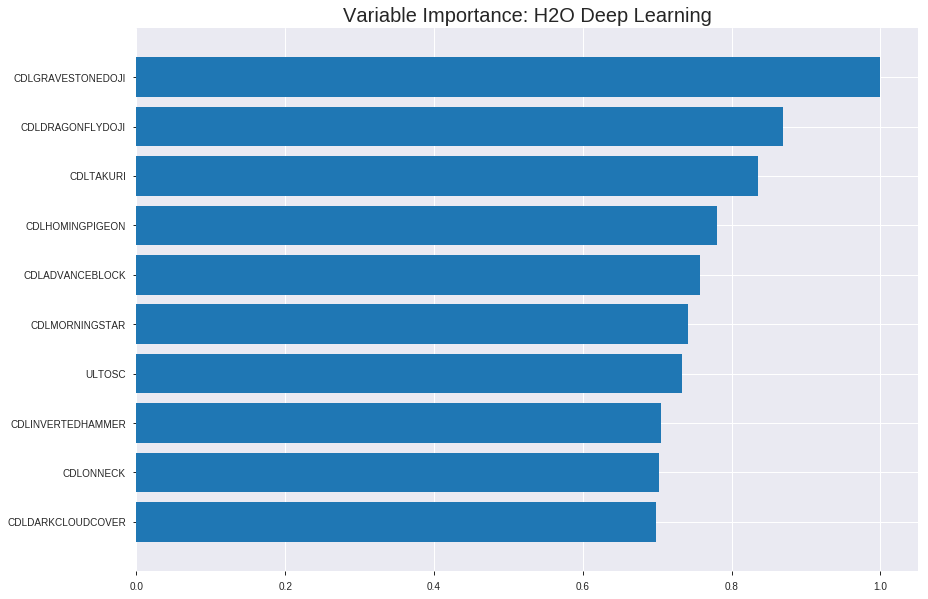

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190822_101855_model_3


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.2067443125749352
RMSE: 0.4546914476597676
LogLoss: 0.6486531926402329
Mean Per-Class Error: 0.2966859428932388
AUC: 0.7833761972441764
pr_auc: 0.7895562553901714
Gini: 0.5667523944883528
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.1320321614609422: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      381  466   0.5502   (466.0/847.0)
1      86   856   0.0913   (86.0/942.0)
Total  467  1322  0.3086   (552.0/1789.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.132032     0.756184  330
max f2                       0.0135168    0.862197  387
max f0point5                 0.56796      0.732545  168
max accuracy                 0.370504     0.704863  241
max precision                0.998034     1         0
max recall                   0.000138697  1         399
max specificity              0.998034     1         0
max absolute_mcc             0.56796      0.411482  168
max min_per_class_accuracy   0.409436     0.696576  226
max mean_per_class_accuracy  0.370504     0.703314  241

Gains/Lift Table: Avg response rate: 52.66 %, avg score: 43.10 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score       cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100615                   0.988049           1.79364   1.79364            0.944444         0.993461    0.944444                    0.993461            0.0180467       0.0180467                  79.3642   79.3642
    2        0.020123                    0.977419           1.89915   1.8464             1                0.98351     0.972222                    0.988485            0.0191083       0.037155                   89.9151   84.6397
    3        0.0301845                   0.971211           1.79364   1.82881            0.944444         0.974141    0.962963                    0.983704            0.0180467       0.0552017                  79.3642   82.8812
    4        0.0402459                   0.962488           1.58263   1.76727            0.833333         0.966832    0.930556                    0.979486            0.0159236       0.0711253                  58.2626   76.7265
    5        0.0503074                   0.954062           1.68813   1.75144            0.888889         0.957935    0.922222                    0.975176            0.0169851       0.0881104                  68.8134   75.1439
    6        0.100056                    0.894322           1.64309   1.69756            0.865169         0.924805    0.893855                    0.950131            0.081741        0.169851                   64.3085   69.7565
    7        0.150363                    0.819303           1.66703   1.68735            0.877778         0.85766     0.888476                    0.919193            0.0838641       0.253715                   66.7032   68.735
    8        0.200112                    0.75687            1.53639   1.64982            0.808989         0.788032    0.868715                    0.886586            0.0764331       0.330149                   53.6392   64.9821
    9        0.300168                    0.652265           1.35805   1.55256            0.715084         0.706264    0.817505                    0.826478            0.135881        0.46603                    35.8052   55.2565
    10       0.400224                    0.546826           1.22012   1.46945            0.642458         0.597202    0.773743                    0.769159            0.122081        0.58811                    22.0125   46.9455
    11       0.500279                    0.427887           0.96549   1.36866            0.50838          0.488937    0.72067                     0.713115            0.096603        0.684713                   -3.451    36.8662
    12       0.599776                    0.299207           1.01359   1.30976            0.533708         0.359543    0.689655                    0.654461            0.100849        0.785563                   1.35917   30.9759
    13       0.699832                    0.170541           0.901831  1.25144            0.47486          0.228389    0.658946                    0.593545            0.0902335       0.875796                   -9.81686  25.1437
    14       0.799888                    0.0656964          0.647197  1.17585            0.340782         0.118281    0.619147                    0.534095            0.0647558       0.940552                   -35.2803  17.5854
    15       0.899944                    0.0109246          0.435001  1.09349            0.22905          0.0353328   0.575776                    0.478643            0.0435244       0.984076                   -56.4999  9.34862
    16       1                           4.13039e-07        0.159147  1                  0.0837989        0.00278806  0.526551  



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.17850075304621812
RMSE: 0.4224934946791703
LogLoss: 0.5428394356878905
Mean Per-Class Error: 0.2684719177447742
AUC: 0.8091441010281902
pr_auc: 0.8235277682701165
Gini: 0.6182882020563805
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3259623290786119: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      89   144  0.618    (144.0/233.0)
1      8    270  0.0288   (8.0/278.0)
Total  97   414  0.2975   (152.0/511.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.325962     0.780347  319
max f2                       0.325962     0.884666  319
max f0point5                 0.643932     0.766063  181
max accuracy                 0.606975     0.729941  208
max precision                0.997982     1         0
max recall                   0.00224013   1         398
max specificity              0.997982     1         0
max absolute_mcc             0.643932     0.462899  181
max min_per_class_accuracy   0.614473     0.725322  203
max mean_per_class_accuracy  0.643932     0.731528  181

Gains/Lift Table: Avg response rate: 54.40 %, avg score: 58.06 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117417                   0.993278           1.83813   1.83813            1                0.995877   1                           0.995877            0.0215827       0.0215827                  83.8129   83.8129
    2        0.0215264                   0.988365           1.4705    1.67103            0.8              0.990712   0.909091                    0.993529            0.0143885       0.0359712                  47.0504   67.1027
    3        0.0313112                   0.980684           1.83813   1.72325            1                0.983571   0.9375                      0.990417            0.0179856       0.0539568                  83.8129   72.3246
    4        0.0410959                   0.97856            1.83813   1.7506             1                0.980009   0.952381                    0.987939            0.0179856       0.0719424                  83.8129   75.06
    5        0.0508806                   0.974875           1.83813   1.76743            1                0.977029   0.961538                    0.985841            0.0179856       0.0899281                  83.8129   76.7432
    6        0.101761                    0.950061           1.69673   1.73208            0.923077         0.963393   0.942308                    0.974617            0.0863309       0.176259                   69.6735   73.2084
    7        0.150685                    0.917994           1.61755   1.6949             0.88             0.932142   0.922078                    0.960827            0.0791367       0.255396                   61.7554   69.4899
    8        0.201566                    0.868611           1.55534   1.65967            0.846154         0.897135   0.902913                    0.944749            0.0791367       0.334532                   55.534    65.967
    9        0.30137                     0.765532           1.44167   1.58748            0.784314         0.807713   0.863636                    0.899367            0.143885        0.478417                   44.167    58.7475
    10       0.401174                    0.690901           1.22542   1.4974             0.666667         0.724175   0.814634                    0.855782            0.122302        0.600719                   22.542    49.7403
    11       0.500978                    0.619793           1.04521   1.40732            0.568627         0.650956   0.765625                    0.814977            0.104317        0.705036                   4.52109   40.7318
    12       0.600783                    0.564325           0.82896   1.31124            0.45098          0.596053   0.713355                    0.778609            0.0827338       0.78777                    -17.104   31.1239
    13       0.700587                    0.466788           0.901044  1.2528             0.490196         0.519831   0.681564                    0.741744            0.0899281       0.877698                   -9.89561  25.2803
    14       0.800391                    0.341047           0.792919  1.19546            0.431373         0.401424   0.650367                    0.699308            0.0791367       0.956835                   -20.7081  19.5458
    15       0.900196                    0.0600533          0.252292  1.09089            0.137255         0.190615   0.593478                    0.642909            0.0251799       0.982014                   -74.7708  9.08899
    16       1                           0.00075133         0.180209  1                  0.0980392        0.0182791  0.544031                    0.


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-22 10:21:54  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-22 10:21:56  2 min 55.280 sec  322 obs/sec       0.302963  1             542        0.657201         8.36021             -0.73254       0.568011        0.193179           1.17213          0.446618                         0.603391           5.25704               -0.467704        0.596034          0.389167             1.48801            0.418787
    2019-08-22 10:22:08  3 min  7.753 sec  480 obs/sec       3.46003   12            6190       0.500431         1.66725             -0.00455569    0.776247        0.459889           1.79364          0.291783                         0.494328           1.33526               0.0149215        0.803548          0.732741             1.83813            0.25636
    2019-08-22 10:22:21  3 min 20.411 sec  500 obs/sec       6.86082   24            12274      0.537265         1.80083             -0.157879      0.758063        0.689353           1.79364          0.329234                         0.49678            1.29526               0.00512147       0.779726          0.712072             1.53177            0.283757
    2019-08-22 10:22:32  3 min 31.352 sec  506 obs/sec       9.76411   34            17468      0.564932         2.2532              -0.280201      0.705526        0.514911           1.58263          0.362214                         0.536863           1.75221               -0.1619          0.735465          0.681974             1.53177            0.338552
    2019-08-22 10:22:43  3 min 42.023 sec  511 obs/sec       12.6065   44            22553      0.451565         0.81735             0.18205        0.812771        0.62633            1.68813          0.273337                         0.478459           0.81738               0.0771529        0.803802          0.802006             1.83813            0.313112
    2019-08-22 10:22:53  3 min 52.666 sec  515 obs/sec       15.4639   54            27665      0.435872         0.642801            0.237912       0.807309        0.753496           1.79364          0.283399                         0.436879           0.647734              0.23058          0.80564           0.80317              1.53177            0.27593
    2019-08-22 10:23:04  4 min  3.502 sec  509 obs/sec       18.1001   63            32381      0.496153         0.838774            0.0125431      0.770709        0.784422           1.79364          0.338737                         0.474963           0.685032              0.0905895        0.765137          0.794649             1.83813            0.330724
    2019-08-22 10:23:15  4 min 14.345 sec  517 obs/sec       21.2091   74            37943      0.454691         0.648653            0.170684       0.783376        0.789556           1.79364          0.308552                         0.422493           0.542839              0.280417         0.809144          0.823528             1.83813            0.297456
    2019-08-22 10:23:26  

Variable Importances: 


variable                 relative_importance    scaled_importance    percentage
-----------------------  ---------------------  -------------------  ---------------------
CDLGRAVESTONEDOJI        1.0                    1.0                  0.003518873722428047
CDLDRAGONFLYDOJI         0.8692784905433655     0.8692784905433655   0.0030588812378449667
CDLTAKURI                0.8359631896018982     0.8359631896018982   0.002941648900807255
CDLHOMINGPIGEON          0.7807483673095703     0.7807483673095703   0.002747354913554248
CDLADVANCEBLOCK          0.7567989826202393     0.7567989826202393   0.0026630800531026403
---                      ---                    ---                  ---
BBANDS_middleband_8_0_2  0.22686095535755157    0.22686095535755157  0.0007982950544526106
BBANDS_lowerband_14_1_4  0.22617898881435394    0.22617898881435394  0.0007958953003041773
BBANDS_middleband_8_2_5  0.22610177099704742    0.22610177099704742  0.0007956235805559542
BBANDS_lowerband_12_6_2  0.22163763642311096    0.22163763642311096  0.0007799148547103466
BBANDS_lowerband_30_6_2  0.22113920748233795    0.22113920748233795  0.0007781609462081628


See the whole table with table.as_data_frame()


('accuracy', 0.78125)

('F1', 0.7703703703703704)

('auc', 0.8436484082684168)

('logloss', 0.5036906145059494)

('mean_per_class_error', 0.21873274857388214)

('rmse', 0.40766479522047894)

('mse', 0.16619058526215502)

deeplearning prediction progress: |███████████████████████████████████████| 100%


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


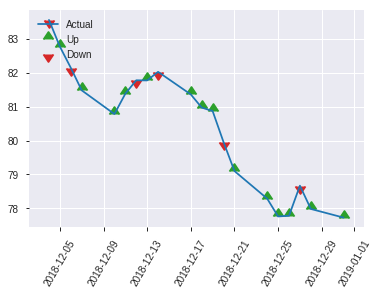


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.16619058526215502
RMSE: 0.40766479522047894
LogLoss: 0.5036906145059494
Mean Per-Class Error: 0.21873274857388214
AUC: 0.8436484082684168
pr_auc: 0.804878835609417
Gini: 0.6872968165368336
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.44816422379692594: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      90   47   0.3431   (47.0/137.0)
1      15   104  0.1261   (15.0/119.0)
Total  105  151  0.2422   (62.0/256.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.448164     0.77037   150
max f2                       0.376034     0.85997   180
max f0point5                 0.612714     0.767677  93
max accuracy                 0.536437     0.78125   122
max precision                0.998117     1         0
max recall                   0.067956     1         230
max specificity              0.998117     1         0
max absolute_mcc             0.536437     0.561571  122
max min_per_class_accuracy   0.536437     0.781022  122
max mean_per_class_accuracy  0.536437     0.781267  122

Gains/Lift Table: Avg response rate: 46.48 %, avg score: 51.14 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117188                   0.978909           2.15126    2.15126            1                0.988668   1                           0.988668            0.0252101       0.0252101                  115.126   115.126
    2        0.0234375                   0.965647           2.15126    2.15126            1                0.97087    1                           0.979769            0.0252101       0.0504202                  115.126   115.126
    3        0.03125                     0.954798           2.15126    2.15126            1                0.963176   1                           0.975621            0.0168067       0.0672269                  115.126   115.126
    4        0.0429688                   0.94875            2.15126    2.15126            1                0.949637   1                           0.968534            0.0252101       0.092437                   115.126   115.126
    5        0.0507812                   0.941904           1.07563    1.98578            0.5              0.946978   0.923077                    0.965218            0.00840336      0.10084                    7.56303   98.5779
    6        0.101562                    0.909636           1.65482    1.8203             0.769231         0.928575   0.846154                    0.946896            0.0840336       0.184874                   65.4816   82.0297
    7        0.152344                    0.857732           1.8203     1.8203             0.846154         0.887214   0.846154                    0.927002            0.092437        0.277311                   82.0297   82.0297
    8        0.203125                    0.775273           2.15126    1.90304            1                0.808554   0.884615                    0.89739             0.109244        0.386555                   115.126   90.3038
    9        0.300781                    0.670191           1.54891    1.78806            0.72             0.720714   0.831169                    0.840028            0.151261        0.537815                   54.8908   78.8061
    10       0.402344                    0.592238           1.24111    1.65               0.576923         0.625164   0.76699                     0.78579             0.12605         0.663866                   24.1112   64.9996
    11       0.5                         0.527071           1.29076    1.57983            0.6              0.559653   0.734375                    0.741623            0.12605         0.789916                   29.0756   57.9832
    12       0.601562                    0.440933           0.827408   1.4528             0.384615         0.48631    0.675325                    0.698518            0.0840336       0.87395                    -17.2592  45.2799
    13       0.699219                    0.383847           0.688403   1.34604            0.32             0.411641   0.625698                    0.658451            0.0672269       0.941176                   -31.1597  34.604
    14       0.800781                    0.263574           0.248222   1.2068             0.115385         0.325754   0.560976                    0.616256            0.0252101       0.966387                   -75.1778  20.6805
    15       0.898438                    0.0690823          0.258151   1.10369            0.12             0.15191    0.513043                    0.565783            0.0252101       0.991597                   -74.1849  10.369
    16       1                           0.00075918         0.0827408  1                  0.0384615        0.0302156  0.464844   

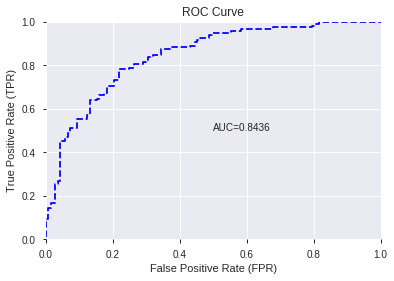

This function is available for GLM models only


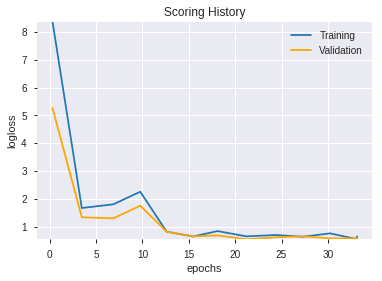

--2019-08-22 10:47:11--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.132.19
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.132.19|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 368257676 (351M) [application/zip]
Saving to: ‘h2o-3.24.0.5.zip’

h2o-3.24.0.5.zip    100%[===================>] 351.20M  12.9MB/s    in 28s     

2019-08-22 10:47:41 (12.3 MB/s) - ‘h2o-3.24.0.5.zip’ saved [368257676/368257676]

Archive:  h2o-3.24.0.5.zip
   creating: h2o-3.24.0.5/
   creating: h2o-3.24.0.5/bindings/
   creating: h2o-3.24.0.5/bindings/java/
 extracting: h2o-3.24.0.5/bindings/java/h2o-bindings-3.24.0.zip  
  inflating: h2o-3.24.0.5/h2o.jar    
   creating: h2o-3.24.0.5/python/
  inflating: h2o-3.24.0.5/python/h2o-3.24.0.5-py2.py3-none-any.whl  
   creating: h2o-3.24.0.5/R/
  inflating: h2o-3.24.0.5/R/h2o_3.24.0.5.tar.gz  
ERROR: Unk

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190822_101855_model_3',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190822_101855_model_3',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_2_sid_a945',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl

In [10]:
# DeepLearning
features_list = model_train(feature_name='All',model_algo="DeepLearning")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190822_104752_model_5  0.850702  0.542075              0.215083  0.424930  0.180565
1  DeepLearning_grid_1_AutoML_20190822_104752_model_8  0.843771  0.551575              0.228363  0.430847  0.185629
2               DeepLearning_1_AutoML_20190822_104752  0.843035  0.613699              0.238760  0.463525  0.214855
3  DeepLearning_grid_1_AutoML_20190822_104752_model_6  0.834632  0.578113              0.241520  0.444030  0.197163
4  DeepLearning_grid_1_AutoML_20190822_104752_model_9  0.828620  0.541235              0.241183  0.428166  0.183326
5  DeepLearning_grid_1_AutoML_20190822_104752_model_4  0.807520  0.626714              0.249371  0.428535  0.183642
6  DeepLearning_grid_1_AutoML_20190822_104752_model_1  0.791449  0.724716              0.271606  0.486337  0.236524
7  DeepLearning_grid_1_AutoML_20190822_104752_model_3  0.790775  0.562472              0.324143  0.434452  0.188749
8  DeepLearning_grid_1_AutoML_20190822_104752_model_7  0.786358  0.585246              0.343832  0.437997  0.191841
9  DeepLearning_grid_1_AutoML_20190822_104752_model_2  0.784886  0.570213              0.323039  0.434688  0.188954

variable  relative_importance  scaled_importance  percentage
0         STOCHF_fastk             1.000000           1.000000    0.029953
1    CDLGRAVESTONEDOJI             0.962802           0.962802    0.028839
2                CCI_8             0.937205           0.937205    0.028072
3            CDLTAKURI             0.900398           0.900398    0.026970
4     CDLDRAGONFLYDOJI             0.883589           0.883589    0.026466
5               ULTOSC             0.879061           0.879061    0.026331
6                  SIN             0.827958           0.827958    0.024800
7              WILLR_8             0.797438           0.797438    0.023886
8         aroondown_14             0.790449           0.790449    0.023677
9         HT_TRENDMODE             0.749246           0.749246    0.022442
10           PLUS_DI_8             0.729225           0.729225    0.021843
11         CDLBELTHOLD             0.715758           0.715758    0.021439
12           CORREL_14             0.707430           0.707430    0.021190
13                 EXP             0.693839           0.693839    0.020783
14        weekday_name             0.690693           0.690693    0.020689
15           CORREL_12             0.687021           0.687021    0.020579
16     CDLADVANCEBLOCK             0.672520           0.672520    0.020144
17                COSH             0.670177           0.670177    0.020074
18              SAREXT             0.669989           0.669989    0.020068
19              TRANGE             0.667866           0.667866    0.020005
20        CDLTHRUSTING             0.658732           0.658732    0.019731
21              CCI_12             0.655953           0.655953    0.019648
22                SINH             0.642061           0.642061    0.019232
23           CDLHAMMER             0.639231           0.639231    0.019147
24   CDLINVERTEDHAMMER             0.635729           0.635729    0.019042
25      is_quarter_end             0.631904           0.631904    0.018928
26          PLUS_DI_12             0.628966           0.628966    0.018840
27     CDLLADDERBOTTOM             0.624530           0.624530    0.018707
28  CDLCLOSINGMARUBOZU             0.624127           0.624127    0.018695
29     CDLSHOOTINGSTAR             0.613382           0.613382    0.018373
30      CDLMORNINGSTAR             0.613210           0.613210    0.018368
31  CDLSEPARATINGLINES             0.610763           0.610763    0.018294
32    CDLABANDONEDBABY             0.600288           0.600288    0.017981
33     CDLUNIQUE3RIVER             0.598203           0.598203    0.017918
34           CDLINNECK             0.595855           0.595855    0.017848
35      is_month_start             0.594713           0.594713    0.017814
36         CDLMARUBOZU             0.592882           0.592882    0.017759
37   CDLDARKCLOUDCOVER             0.591956           0.591956    0.017731
38           CDLONNECK             0.588151           0.588151    0.017617
39        is_month_end             0.585188           0.585188    0.017528
40  CDLMORNINGDOJISTAR             0.565405           0.565405    0.016936
41       CDLHIKKAKEMOD             0.564354           0.564354    0.016904
42    is_quarter_start             0.563696           0.563696    0.016885
43       CDLHANGINGMAN             0.555954           0.555954    0.016653
44      CDLEVENINGSTAR             0.553427           0.553427    0.016577
45          CDL3INSIDE             0.538835           0.538835    0.016140
46     CDLHOMINGPIGEON             0.534634           0.534634    0.016014
47  CDLEVENINGDOJISTAR             0.531172           0.531172    0.015910
48    CDLCOUNTERATTACK             0.522559           0.522559    0.015652
49      CDLMATCHINGLOW             0.496688           0.496688    0.014877

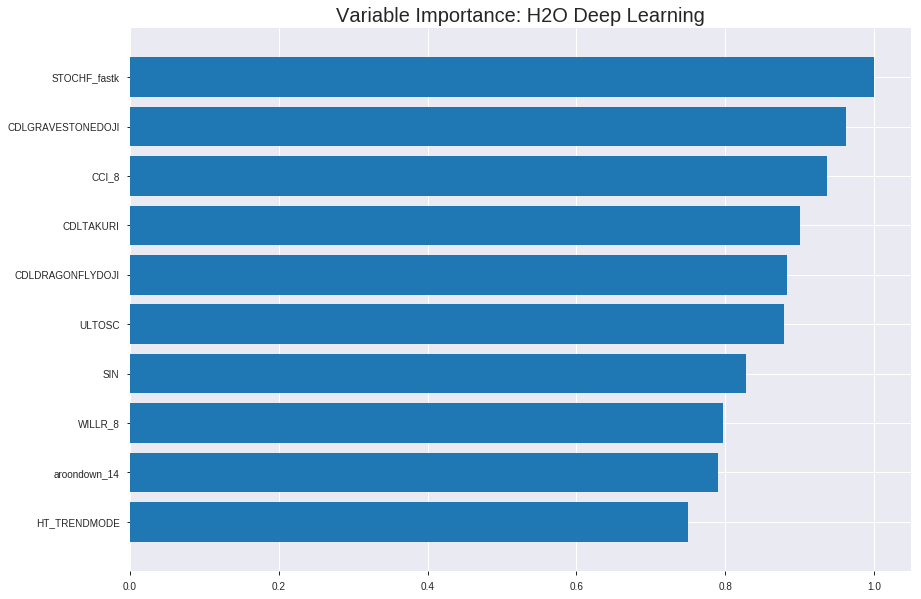

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190822_104752_model_5


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.1828038496752877
RMSE: 0.42755566851029786
LogLoss: 0.5376824440971945
Mean Per-Class Error: 0.28066336288687177
AUC: 0.7998549896349548
pr_auc: 0.8106748637030307
Gini: 0.5997099792699097
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4405917983424453: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      373  474   0.5596   (474.0/847.0)
1      60   882   0.0637   (60.0/942.0)
Total  433  1356  0.2985   (534.0/1789.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.440592     0.767624  258
max f2                       0.148137     0.86989   344
max f0point5                 0.57095      0.731765  178
max accuracy                 0.533734     0.723868  205
max precision                0.99569      1         0
max recall                   0.0156861    1         397
max specificity              0.99569      1         0
max absolute_mcc             0.533734     0.446535  205
max min_per_class_accuracy   0.560505     0.707006  186
max mean_per_class_accuracy  0.533734     0.719337  205

Gains/Lift Table: Avg response rate: 52.66 %, avg score: 54.61 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100615                   0.987478           1.89915    1.89915            1                0.99208    1                           0.99208             0.0191083       0.0191083                  89.9151   89.9151
    2        0.020123                    0.982788           1.89915    1.89915            1                0.984855   1                           0.988467            0.0191083       0.0382166                  89.9151   89.9151
    3        0.0301845                   0.976607           1.89915    1.89915            1                0.979759   1                           0.985565            0.0191083       0.0573248                  89.9151   89.9151
    4        0.0402459                   0.971982           1.89915    1.89915            1                0.974162   1                           0.982714            0.0191083       0.0764331                  89.9151   89.9151
    5        0.0503074                   0.965957           1.79364    1.87805            0.944444         0.969234   0.988889                    0.980018            0.0180467       0.0944798                  79.3642   87.8049
    6        0.100056                    0.934477           1.7071     1.79305            0.898876         0.953026   0.944134                    0.966598            0.0849257       0.179406                   70.7102   79.3053
    7        0.150363                    0.791489           1.58263    1.72265            0.833333         0.876851   0.907063                    0.936571            0.0796178       0.259023                   58.2626   72.265
    8        0.200112                    0.7124             1.62175    1.69756            0.853933         0.746116   0.893855                    0.889223            0.0806794       0.339703                   62.1747   69.7565
    9        0.300168                    0.632463           1.31561    1.57025            0.692737         0.66854    0.826816                    0.815662            0.131635        0.471338                   31.5613   57.0248
    10       0.400224                    0.588368           1.14586    1.46415            0.603352         0.610119   0.77095                     0.764276            0.11465         0.585987                   14.5856   46.415
    11       0.500279                    0.562326           1.11403    1.39413            0.586592         0.573959   0.734078                    0.726213            0.111465        0.697452                   11.4027   39.4125
    12       0.599776                    0.5318             1.07761    1.34162            0.567416         0.54807    0.706431                    0.696661            0.107219        0.804671                   7.7608    34.1618
    13       0.699832                    0.488871           0.870002   1.27419            0.458101         0.513129   0.670927                    0.670421            0.0870488       0.89172                    -12.9998  27.4191
    14       0.799888                    0.388666           0.594148   1.18913            0.312849         0.446782   0.626136                    0.642447            0.059448        0.951168                   -40.5852  18.9126
    15       0.899944                    0.13199            0.403172   1.10174            0.212291         0.245676   0.580124                    0.598334            0.0403397       0.991507                   -59.6828  10.1743
    16       1                           0.00307513         0.0848782  1                  0.0446927        0.0763273  0.526551   



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.18018788432525812
RMSE: 0.4244854347622049
LogLoss: 0.5333835437745451
Mean Per-Class Error: 0.2655695186340199
AUC: 0.8091826967610461
pr_auc: 0.8327048469643024
Gini: 0.6183653935220923
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.47194107086544: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      100  133  0.5708   (133.0/233.0)
1      17   261  0.0612   (17.0/278.0)
Total  117  394  0.2935   (150.0/511.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.471941     0.776786  295
max f2                       0.391214     0.874674  318
max f0point5                 0.619784     0.768206  162
max accuracy                 0.57526      0.733855  209
max precision                0.992906     1         0
max recall                   0.0767086    1         382
max specificity              0.992906     1         0
max absolute_mcc             0.598602     0.467901  181
max min_per_class_accuracy   0.584132     0.729614  198
max mean_per_class_accuracy  0.598602     0.73443   181

Gains/Lift Table: Avg response rate: 54.40 %, avg score: 58.73 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117417                   0.988876           1.83813   1.83813            1                0.990969   1                           0.990969            0.0215827       0.0215827                  83.8129   83.8129
    2        0.0215264                   0.986436           1.83813   1.83813            1                0.987797   1                           0.989527            0.0179856       0.0395683                  83.8129   83.8129
    3        0.0313112                   0.98412            1.83813   1.83813            1                0.985049   1                           0.988128            0.0179856       0.057554                   83.8129   83.8129
    4        0.0410959                   0.980855           1.83813   1.83813            1                0.982791   1                           0.986857            0.0179856       0.0755396                  83.8129   83.8129
    5        0.0508806                   0.979267           1.4705    1.76743            0.8              0.980091   0.961538                    0.985556            0.0143885       0.0899281                  47.0504   76.7432
    6        0.101761                    0.963377           1.69673   1.73208            0.923077         0.971339   0.942308                    0.978447            0.0863309       0.176259                   69.6735   73.2084
    7        0.150685                    0.936714           1.7646    1.74264            0.96             0.950887   0.948052                    0.969499            0.0863309       0.26259                    76.4604   74.2642
    8        0.201566                    0.859239           1.41395   1.65967            0.769231         0.907047   0.902913                    0.953735            0.0719424       0.334532                   41.3946   65.967
    9        0.30137                     0.669659           1.51375   1.61135            0.823529         0.737475   0.876623                    0.882116            0.151079        0.485612                   51.3754   61.1347
    10       0.401174                    0.62565            1.11729   1.48844            0.607843         0.646795   0.809756                    0.823573            0.111511        0.597122                   11.7294   48.8437
    11       0.500978                    0.59               1.11729   1.4145             0.607843         0.6054     0.769531                    0.780109            0.111511        0.708633                   11.7294   41.4498
    12       0.600783                    0.560203           0.937086  1.33519            0.509804         0.575897   0.726384                    0.746184            0.0935252       0.802158                   -6.29144  33.5189
    13       0.700587                    0.52515            0.684793  1.24253            0.372549         0.544464   0.675978                    0.717448            0.0683453       0.870504                   -31.5207  24.2534
    14       0.800391                    0.436837           0.82896   1.19096            0.45098          0.486706   0.647922                    0.688675            0.0827338       0.953237                   -17.104   19.0964
    15       0.900196                    0.14918            0.288334  1.09089            0.156863         0.269566   0.593478                    0.642209            0.028777        0.982014                   -71.1666  9.08899
    16       1                           0.0282354          0.180209  1                  0.0980392        0.0916341  0.544031                    


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-22 10:51:06  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-22 10:51:08  1 min 22.982 sec  1050 obs/sec      1         1             1789       0.45817          0.607542            0.157948       0.754429        0.777347           1.89915          0.356065                         0.445632           0.580078              0.19944          0.799511          0.825483             1.83813            0.291585
    2019-08-22 10:51:14  1 min 29.274 sec  1924 obs/sec      8         8             14312      0.427556         0.537682            0.266717       0.799855        0.810675           1.89915          0.298491                         0.424485           0.533384              0.273615         0.809183          0.832705             1.83813            0.293542
    2019-08-22 10:51:20  1 min 35.218 sec  2236 obs/sec      16        16            28624      0.424399         0.525814            0.277504       0.812139        0.826155           1.89915          0.281722                         0.433987           0.560537              0.240733         0.79738           0.817161             1.83813            0.295499
    2019-08-22 10:51:26  1 min 41.351 sec  2437 obs/sec      25        25            44725      0.417822         0.511428            0.299723       0.821175        0.837113           1.89915          0.265511                         0.44102            0.580368              0.215924         0.791791          0.809957             1.83813            0.287671
    2019-08-22 10:51:32  1 min 47.314 sec  2564 obs/sec      34        34            60826      0.41061          0.496868            0.323692       0.837201        0.852683           1.89915          0.276132                         0.44815            0.605632              0.190368         0.776832          0.797598             1.83813            0.291585
    2019-08-22 10:51:38  1 min 53.650 sec  2671 obs/sec      44        44            78716      0.396744         0.466813            0.368597       0.85572         0.860802           1.89915          0.258245                         0.446953           0.61271               0.194687         0.773057          0.785612             1.83813            0.291585
    2019-08-22 10:51:39  1 min 54.255 sec  2669 obs/sec      44        44            78716      0.427556         0.537682            0.266717       0.799855        0.810675           1.89915          0.298491                         0.424485           0.533384              0.273615         0.809183          0.832705             1.83813            0.293542

Variable Importances: 


variable            relative_importance    scaled_importance    percentage
------------------  ---------------------  -------------------  --------------------
STOCHF_fastk        1.0                    1.0                  0.02995338247296507
CDLGRAVESTONEDOJI   0.962801992893219      0.962801992893219    0.028839176338863588
CCI_8               0.9372054934501648     0.9372054934501648   0.028072474601076747
CDLTAKURI           0.9003980755805969     0.9003980755805969   0.02696996793578733
CDLDRAGONFLYDOJI    0.8835886716842651     0.8835886716842651   0.026466469431737954
---                 ---                    ---                  ---
CDL3INSIDE          0.5388347506523132     0.5388347506523132   0.016139923376013502
CDLHOMINGPIGEON     0.5346338152885437     0.5346338152885437   0.01601409115231831
CDLEVENINGDOJISTAR  0.5311723351478577     0.5311723351478577   0.015910408113741767
CDLCOUNTERATTACK    0.5225585103034973     0.5225585103034973   0.015652394923623515
CDLMATCHINGLOW      0.4966876804828644     0.4966876804828644   0.014877476063113106


See the whole table with table.as_data_frame()


('accuracy', 0.796875)

('F1', 0.7717842323651452)

('auc', 0.8507023247255106)

('logloss', 0.5420753619581993)

('mean_per_class_error', 0.20744648224253215)

('rmse', 0.4249298517406112)

('mse', 0.18056537890029783)

deeplearning prediction progress: |███████████████████████████████████████| 100%


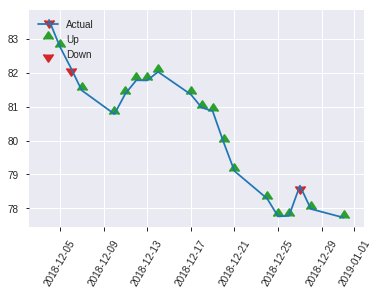


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.18056537890029783
RMSE: 0.4249298517406112
LogLoss: 0.5420753619581993
Mean Per-Class Error: 0.20744648224253215
AUC: 0.8507023247255106
pr_auc: 0.8090849672695399
Gini: 0.7014046494510211
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5655507390776835: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      108  29   0.2117   (29.0/137.0)
1      26   93   0.2185   (26.0/119.0)
Total  134  122  0.2148   (55.0/256.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.565551     0.771784  121
max f2                       0.395799     0.844347  204
max f0point5                 0.604185     0.808679  96
max accuracy                 0.604185     0.796875  96
max precision                0.995512     1         0
max recall                   0.11114      1         234
max specificity              0.995512     1         0
max absolute_mcc             0.604185     0.595892  96
max min_per_class_accuracy   0.565551     0.781513  121
max mean_per_class_accuracy  0.5926       0.792554  106

Gains/Lift Table: Avg response rate: 46.48 %, avg score: 56.11 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117188                   0.991101           1.43417    1.43417            0.666667         0.993765   0.666667                    0.993765            0.0168067       0.0168067                  43.4174   43.4174
    2        0.0234375                   0.988665           1.43417    1.43417            0.666667         0.990095   0.666667                    0.99193             0.0168067       0.0336134                  43.4174   43.4174
    3        0.03125                     0.987637           2.15126    1.61345            1                0.988036   0.75                        0.990956            0.0168067       0.0504202                  115.126   61.3445
    4        0.0429688                   0.978023           2.15126    1.76012            1                0.982919   0.818182                    0.988764            0.0252101       0.0756303                  115.126   76.0122
    5        0.0507812                   0.973924           2.15126    1.8203             1                0.975877   0.846154                    0.986782            0.0168067       0.092437                   115.126   82.0297
    6        0.101562                    0.95331            2.15126    1.98578            1                0.963524   0.923077                    0.975153            0.109244        0.201681                   115.126   98.5779
    7        0.152344                    0.922591           1.8203     1.93062            0.846154         0.940194   0.897436                    0.9635              0.092437        0.294118                   82.0297   93.0618
    8        0.203125                    0.728278           2.15126    1.98578            1                0.826639   0.923077                    0.929285            0.109244        0.403361                   115.126   98.5779
    9        0.300781                    0.635017           1.72101    1.89981            0.8              0.662224   0.883117                    0.842577            0.168067        0.571429                   72.1008   89.9814
    10       0.402344                    0.597189           1.32385    1.75443            0.615385         0.613596   0.815534                    0.784776            0.134454        0.705882                   32.3853   75.4426
    11       0.5                         0.56075            0.860504   1.57983            0.4              0.578352   0.734375                    0.744459            0.0840336       0.789916                   -13.9496  57.9832
    12       0.601562                    0.541649           0.744667   1.43883            0.346154         0.551922   0.668831                    0.711952            0.0756303       0.865546                   -25.5333  43.883
    13       0.699219                    0.506058           0.516303   1.30999            0.24             0.525779   0.608939                    0.685951            0.0504202       0.915966                   -48.3697  30.9985
    14       0.800781                    0.395799           0.496445   1.2068             0.230769         0.478125   0.560976                    0.659592            0.0504202       0.966387                   -50.3555  20.6805
    15       0.898438                    0.137384           0.258151   1.10369            0.12             0.251465   0.513043                    0.615231            0.0252101       0.991597                   -74.1849  10.369
    16       1                           0.0229609          0.0827408  1                  0.0384615        0.0822523  0.464844   

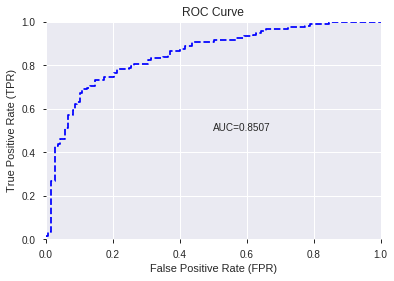

This function is available for GLM models only


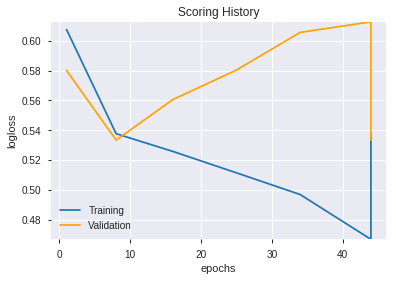

--2019-08-22 10:55:44--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.186.59
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.186.59|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190822_104752_model_5',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190822_104752_model_5',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_10_sid_a945',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['STOCHF_fastk',
 'CDLGRAVESTONEDOJI',
 'CCI_8',
 'CDLTAKURI',
 'CDLDRAGONFLYDOJI',
 'ULTOSC',
 'SIN',
 'WILLR_8',
 'aroondown_14',
 'HT_TRENDMODE',
 'PLUS_DI_8',
 'CDLBELTHOLD',
 'CORREL_14',
 'EXP',
 'weekday_name',
 'CORREL_12',
 'CDLADVANCEBLOCK',
 'COSH',
 'SAREXT',
 'TRANGE',
 'CDLTHRUSTING',
 'CCI_12',
 'SINH',
 'CDLHAMMER',
 'CDLINVERTEDHAMMER',
 'is_quarter_end',
 'PLUS_DI_12',
 'CDLLADDERBOTTOM',
 'CDLCLOSINGMARUBOZU',
 'CDLSHOOTINGSTAR',
 'CDLMORNINGSTAR',
 'CDLSEPARATINGLINES',
 'CDLABANDONEDBABY',
 'CDLUNIQUE3RIVER',
 'CDLINNECK',
 'is_month_start',
 'CDLMARUBOZU',
 'CDLDARKCLOUDCOVER',
 'CDLONNECK',
 'is_month_end',
 'CDLMORNINGDOJISTAR',
 'CDLHIKKAKEMOD',
 'is_quarter_start',
 'CDLHANGINGMAN',
 'CDLEVENINGSTAR',
 'CDL3INSIDE',
 'CDLHOMINGPIGEON',
 'CDLEVENINGDOJISTAR',
 'CDLCOUNTERATTACK',
 'CDLMATCHINGLOW']

In [11]:
# DeepLearning with top DeepLearning features
model_train(feature_name='DLF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190822_105552_model_1  0.861375  0.488553              0.213427  0.403009  0.162416

variable  relative_importance  scaled_importance  percentage
0                CCI_8             1.073727           1.000000    0.123066
1    CDLGRAVESTONEDOJI             0.881767           0.821220    0.101064
2            PLUS_DI_8             0.870758           0.810967    0.099803
3              WILLR_8             0.634038           0.590502    0.072671
4            CDLTAKURI             0.632336           0.588917    0.072476
5           PLUS_DI_12             0.629965           0.586709    0.072204
6         STOCHF_fastk             0.625506           0.582556    0.071693
7      CDLSHOOTINGSTAR             0.271710           0.253053    0.031142
8    CDLINVERTEDHAMMER             0.258510           0.240759    0.029629
9        CDLHANGINGMAN             0.188523           0.175578    0.021608
10    CDLDRAGONFLYDOJI             0.186421           0.173620    0.021367
11     CDLLADDERBOTTOM             0.186375           0.173578    0.021362
12           CDLINNECK             0.182345           0.169824    0.020900
13        aroondown_14             0.164406           0.153117    0.018844
14     CDLUNIQUE3RIVER             0.156570           0.145819    0.017945
15  CDLCLOSINGMARUBOZU             0.141340           0.131635    0.016200
16     CDLHOMINGPIGEON             0.134003           0.124801    0.015359
17                 SIN             0.111654           0.103987    0.012797
18     CDLADVANCEBLOCK             0.103468           0.096363    0.011859
19       CDLHIKKAKEMOD             0.097316           0.090634    0.011154
20      CDLMORNINGSTAR             0.093940           0.087489    0.010767
21           CDLHAMMER             0.075219           0.070054    0.008621
22              ULTOSC             0.072492           0.067514    0.008309
23          CDL3INSIDE             0.072397           0.067426    0.008298
24  CDLEVENINGDOJISTAR             0.071899           0.066962    0.008241
25           CORREL_14             0.065257           0.060777    0.007480
26    CDLCOUNTERATTACK             0.061522           0.057298    0.007051
27         CDLBELTHOLD             0.059610           0.055517    0.006832
28              TRANGE             0.057683           0.053722    0.006611
29  CDLMORNINGDOJISTAR             0.051332           0.047807    0.005883
30  CDLSEPARATINGLINES             0.047168           0.043929    0.005406
31           CORREL_12             0.045980           0.042823    0.005270
32           CDLONNECK             0.045358           0.042244    0.005199
33        is_month_end             0.044481           0.041426    0.005098
34              SAREXT             0.044467           0.041414    0.005097
35   CDLDARKCLOUDCOVER             0.042540           0.039619    0.004876
36    CDLABANDONEDBABY             0.039156           0.036467    0.004488
37      is_month_start             0.039049           0.036368    0.004476
38      is_quarter_end             0.038621           0.035969    0.004427
39              CCI_12             0.027741           0.025836    0.003180
40    is_quarter_start             0.022393           0.020856    0.002567
41         CDLMARUBOZU             0.021423           0.019952    0.002455
42        CDLTHRUSTING             0.016226           0.015112    0.001860
43      CDLEVENINGSTAR             0.009731           0.009063    0.001115
44                COSH             0.007756           0.007224    0.000889
45                 EXP             0.005602           0.005217    0.000642
46                SINH             0.004898           0.004562    0.000561
47        weekday_name             0.004067           0.003787    0.000466
48      CDLMATCHINGLOW             0.004053           0.003775    0.000465
49        HT_TRENDMODE             0.002001           0.001864    0.000229

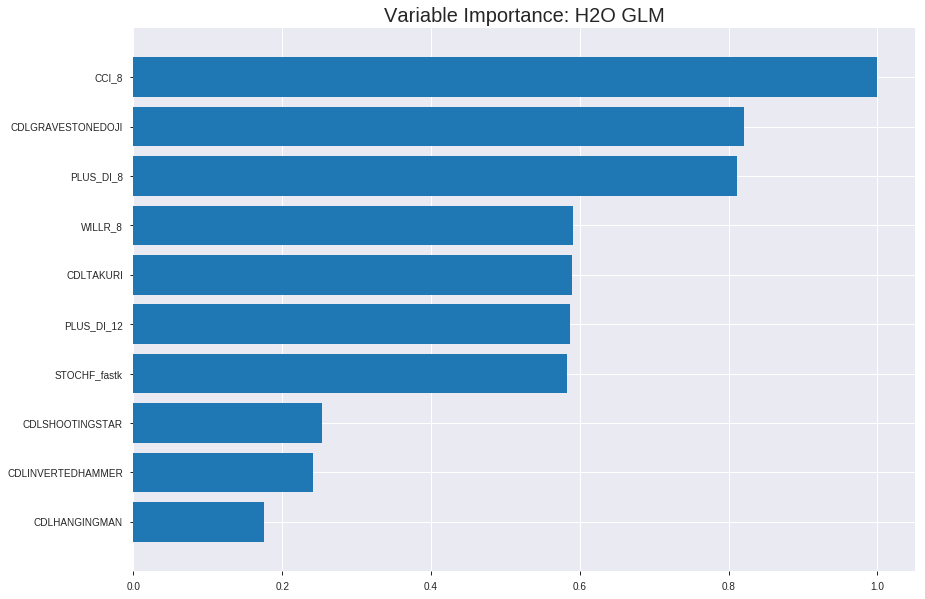

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190822_105552_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.18066399395274235
RMSE: 0.42504587276286115
LogLoss: 0.5333750483847717
Null degrees of freedom: 1788
Residual degrees of freedom: 1738
Null deviance: 2475.0335207517455
Residual deviance: 1908.4159231207132
AIC: 2010.4159231207132
AUC: 0.8006571212998543
pr_auc: 0.8136845394281887
Gini: 0.6013142425997087
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3655209762131081: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      389  458   0.5407   (458.0/847.0)
1      67   875   0.0711   (67.0/942.0)
Total  456  1333  0.2935   (525.0/1789.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.365521     0.769231  272
max f2                       0.24878      0.868161  314
max f0point5                 0.596889     0.747068  165
max accuracy                 0.462422     0.715484  230
max precision                0.9996       1         0
max recall                   0.0348466    1         388
max specificity              0.9996       1         0
max absolute_mcc             0.365521     0.444694  272
max min_per_class_accuracy   0.538499     0.707202  193
max mean_per_class_accuracy  0.587409     0.717294  168

Gains/Lift Table: Avg response rate: 52.66 %, avg score: 52.66 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100615                   0.985275           1.89915   1.89915            1                0.991256   1                           0.991256            0.0191083       0.0191083                  89.9151   89.9151
    2        0.020123                    0.978868           1.89915   1.89915            1                0.981569   1                           0.986412            0.0191083       0.0382166                  89.9151   89.9151
    3        0.0301845                   0.973887           1.89915   1.89915            1                0.976823   1                           0.983216            0.0191083       0.0573248                  89.9151   89.9151
    4        0.0402459                   0.960714           1.79364   1.87277            0.944444         0.96832    0.986111                    0.979492            0.0180467       0.0753715                  79.3642   87.2774
    5        0.0503074                   0.954339           1.89915   1.87805            1                0.957865   0.988889                    0.975167            0.0191083       0.0944798                  89.9151   87.8049
    6        0.100056                    0.893538           1.7071    1.79305            0.898876         0.92546    0.944134                    0.950452            0.0849257       0.179406                   70.7102   79.3053
    7        0.150363                    0.820604           1.51932   1.70147            0.8              0.857696   0.895911                    0.919418            0.0764331       0.255839                   51.9321   70.147
    8        0.200112                    0.748619           1.64309   1.68696            0.865169         0.780724   0.888268                    0.884939            0.081741        0.33758                    64.3085   68.6955
    9        0.300168                    0.667235           1.33683   1.57025            0.703911         0.704647   0.826816                    0.824841            0.133758        0.471338                   33.6832   57.0248
    10       0.400224                    0.605685           1.28378   1.49863            0.675978         0.636234   0.789106                    0.77769             0.12845         0.599788                   28.3783   49.8632
    11       0.500279                    0.544818           1.00793   1.40049            0.530726         0.573878   0.73743                     0.736927            0.100849        0.700637                   0.792917  40.0491
    12       0.599776                    0.481588           0.928237  1.32215            0.488764         0.512772   0.696179                    0.699742            0.0923567       0.792994                   -7.17634  32.2149
    13       0.699832                    0.40992            0.95488   1.26964            0.502793         0.446678   0.66853                     0.663561            0.0955414       0.888535                   -4.51197  26.964
    14       0.799888                    0.295253           0.657806  1.19311            0.346369         0.357602   0.628232                    0.62529             0.0658174       0.954352                   -34.2194  19.3107
    15       0.899944                    0.114371           0.297074  1.09349            0.156425         0.204467   0.575776                    0.578502            0.029724        0.984076                   -70.2926  9.34862
    16       1                           0.000332271        0.159147  1                  0.0837989        0.0592801  0.526551                    0



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.17045560240226965
RMSE: 0.4128626919476615
LogLoss: 0.5090250634399037
Null degrees of freedom: 510
Residual degrees of freedom: 460
Null deviance: 705.0556929735951
Residual deviance: 520.2236148355817
AIC: 622.2236148355817
AUC: 0.8302559669002996
pr_auc: 0.8548870548518144
Gini: 0.6605119338005991
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5227201169133081: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      147  86   0.3691   (86.0/233.0)
1      41   237  0.1475   (41.0/278.0)
Total  188  323  0.2485   (127.0/511.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.52272      0.788686  242
max f2                       0.129489     0.879365  358
max f0point5                 0.662832     0.796089  151
max accuracy                 0.52272      0.751468  242
max precision                0.996727     1         0
max recall                   0.00878674   1         398
max specificity              0.996727     1         0
max absolute_mcc             0.645975     0.509133  161
max min_per_class_accuracy   0.582654     0.746781  202
max mean_per_class_accuracy  0.634735     0.751536  168

Gains/Lift Table: Avg response rate: 54.40 %, avg score: 57.94 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117417                   0.986712           1.83813   1.83813            1                0.989739   1                           0.989739            0.0215827       0.0215827                  83.8129   83.8129
    2        0.0215264                   0.982971           1.83813   1.83813            1                0.985089   1                           0.987625            0.0179856       0.0395683                  83.8129   83.8129
    3        0.0313112                   0.980361           1.83813   1.83813            1                0.981877   1                           0.985829            0.0179856       0.057554                   83.8129   83.8129
    4        0.0410959                   0.975983           1.83813   1.83813            1                0.976963   1                           0.983718            0.0179856       0.0755396                  83.8129   83.8129
    5        0.0508806                   0.971844           1.83813   1.83813            1                0.973935   1                           0.981837            0.0179856       0.0935252                  83.8129   83.8129
    6        0.101761                    0.943943           1.76743   1.80278            0.961538         0.957287   0.980769                    0.969562            0.0899281       0.183453                   76.7432   80.2781
    7        0.150685                    0.915895           1.61755   1.74264            0.88             0.931236   0.948052                    0.957119            0.0791367       0.26259                    61.7554   74.2642
    8        0.201566                    0.863618           1.55534   1.69536            0.846154         0.896611   0.92233                     0.941845            0.0791367       0.341727                   55.534    69.5362
    9        0.30137                     0.744373           1.51375   1.63522            0.823529         0.795579   0.88961                     0.893406            0.151079        0.492806                   51.3754   63.5219
    10       0.401174                    0.654979           1.33354   1.56017            0.72549          0.696687   0.84878                     0.844466            0.133094        0.625899                   33.3545   56.0168
    11       0.500978                    0.590426           0.973127  1.44322            0.529412         0.622285   0.785156                    0.800204            0.0971223       0.723022                   -2.68726  44.3219
    12       0.600783                    0.545034           0.865002  1.34716            0.470588         0.569006   0.732899                    0.761796            0.0863309       0.809353                   -13.4998  34.7163
    13       0.700587                    0.468936           0.720835  1.25794            0.392157         0.509709   0.684358                    0.725884            0.0719424       0.881295                   -27.9165  25.7938
    14       0.800391                    0.328778           0.720835  1.19096            0.392157         0.417984   0.647922                    0.687491            0.0719424       0.953237                   -27.9165  19.0964
    15       0.900196                    0.133674           0.360418  1.09888            0.196078         0.221873   0.597826                    0.635868            0.0359712       0.989209                   -63.9582  9.88818
    16       1                           0.0059284          0.108125  1                  0.0588235        0.0695921  0.544031                   


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train      deviance_test
---  -------------------  ----------  -----------  --------  ------------  ------------------  ------------------
     2019-08-22 10:55:52  0.000 sec   2            .17E2     51            1.3671344216744614  1.360956737111869
     2019-08-22 10:55:52  0.048 sec   4            .11E2     51            1.3580705367656893  1.3505395077142313
     2019-08-22 10:55:52  0.086 sec   6            .66E1     51            1.344726680061182   1.3352200276290156
     2019-08-22 10:55:52  0.126 sec   8            .41E1     51            1.325989429946351   1.3137564226405933
     2019-08-22 10:55:52  0.167 sec   10           .25E1     51            1.3013331729929731  1.2856103128408096
---  ---                  ---         ---          ---       ---           ---                 ---
     2019-08-22 10:55:53  0.558 sec   45           .3E-3     51            1.0668177086976482  1.0190331941210125
     2019-08-22 10:55:53  0.567 sec   46           .19E-3    51            1.0667792623127426  1.018608194576711
     2019-08-22 10:55:53  0.580 sec   47           .11E-3    51            1.0667617980638278  1.0183348331185313
     2019-08-22 10:55:53  0.597 sec   48           .71E-4    51            1.0667538976501603  1.0181663487633121
     2019-08-22 10:55:53  0.609 sec   49           .44E-4    51            1.0667500967695436  1.0180501268798074


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.79296875)

('F1', 0.7773279352226722)

('auc', 0.8613752070171133)

('logloss', 0.48855328466762094)

('mean_per_class_error', 0.21109611727902844)

('rmse', 0.40300883828951917)

('mse', 0.1624161237394678)

glm prediction progress: |████████████████████████████████████████████████| 100%


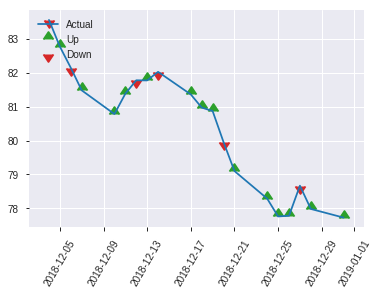


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.1624161237394678
RMSE: 0.40300883828951917
LogLoss: 0.48855328466762094
Null degrees of freedom: 255
Residual degrees of freedom: 205
Null deviance: 357.52774107262724
Residual deviance: 250.13928174982192
AIC: 352.1392817498219
AUC: 0.8613752070171133
pr_auc: 0.8349143809470967
Gini: 0.7227504140342267
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5599098783917322: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      105  32   0.2336   (32.0/137.0)
1      23   96   0.1933   (23.0/119.0)
Total  128  128  0.2148   (55.0/256.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.55991      0.777328  127
max f2                       0.281557     0.85044   205
max f0point5                 0.672452     0.819672  76
max accuracy                 0.62179      0.792969  101
max precision                0.991744     1         0
max recall                   0.128304     1         225
max specificity              0.991744     1         0
max absolute_mcc             0.62179      0.585275  101
max min_per_class_accuracy   0.56496      0.781022  122
max mean_per_class_accuracy  0.604149     0.788904  107

Gains/Lift Table: Avg response rate: 46.48 %, avg score: 53.15 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117188                   0.983498           2.15126   2.15126            1                0.988374   1                           0.988374            0.0252101       0.0252101                  115.126   115.126
    2        0.0234375                   0.978963           1.43417   1.79272            0.666667         0.980139   0.833333                    0.984257            0.0168067       0.0420168                  43.4174   79.2717
    3        0.03125                     0.97704            2.15126   1.88235            1                0.977989   0.875                       0.98269             0.0168067       0.0588235                  115.126   88.2353
    4        0.0429688                   0.972861           2.15126   1.95569            1                0.97569    0.909091                    0.980781            0.0252101       0.0840336                  115.126   95.5691
    5        0.0507812                   0.966546           2.15126   1.98578            1                0.967593   0.923077                    0.978752            0.0168067       0.10084                    115.126   98.5779
    6        0.101562                    0.933686           2.15126   2.06852            1                0.948262   0.961538                    0.963507            0.109244        0.210084                   115.126   106.852
    7        0.152344                    0.854027           1.98578   2.04094            0.923077         0.897852   0.948718                    0.941622            0.10084         0.310924                   98.5779   104.094
    8        0.203125                    0.760667           1.98578   2.02715            0.923077         0.794509   0.942308                    0.904844            0.10084         0.411765                   98.5779   102.715
    9        0.300781                    0.672053           1.80706   1.95569            0.84             0.712425   0.909091                    0.84237             0.176471        0.588235                   80.7059   95.5691
    10       0.402344                    0.61399            1.15837   1.75443            0.538462         0.642447   0.815534                    0.791904            0.117647        0.705882                   15.8371   75.4426
    11       0.5                         0.557862           1.03261   1.61345            0.48             0.584928   0.75                        0.751479            0.10084         0.806723                   3.2605    61.3445
    12       0.601562                    0.490979           0.744667  1.46677            0.346154         0.518546   0.681818                    0.712153            0.0756303       0.882353                   -25.5333  46.6769
    13       0.699219                    0.390024           0.344202  1.30999            0.16             0.446746   0.608939                    0.675085            0.0336134       0.915966                   -65.5798  30.9985
    14       0.800781                    0.285015           0.496445  1.2068             0.230769         0.348888   0.560976                    0.633713            0.0504202       0.966387                   -50.3555  20.6805
    15       0.898438                    0.114551           0.344202  1.11304            0.16             0.194301   0.517391                    0.585951            0.0336134       1                          -65.5798  11.3043
    16       1                           9.47134e-05        0         1                  0                0.0497868  0.464844                   

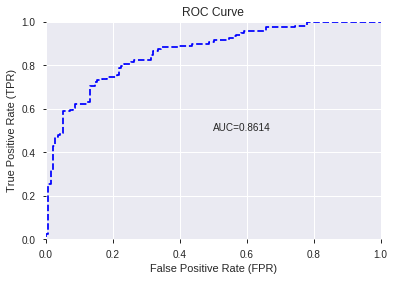

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


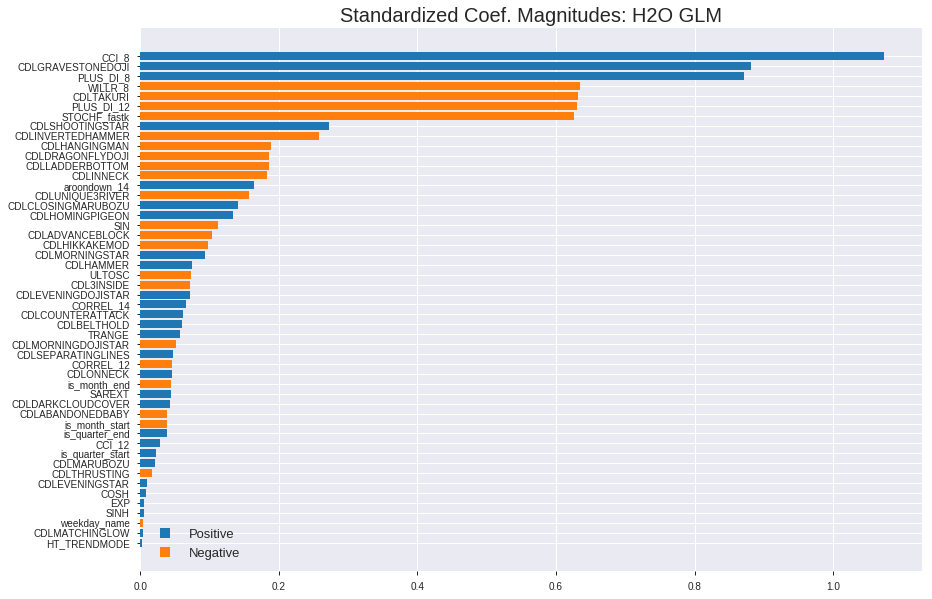

'log_likelihood'
--2019-08-22 10:55:59--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.1.56
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.1.56|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190822_105552_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190822_105552_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_18_sid_a945',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_18_s

['CCI_8',
 'CDLGRAVESTONEDOJI',
 'PLUS_DI_8',
 'WILLR_8',
 'CDLTAKURI',
 'PLUS_DI_12',
 'STOCHF_fastk',
 'CDLSHOOTINGSTAR',
 'CDLINVERTEDHAMMER',
 'CDLHANGINGMAN',
 'CDLDRAGONFLYDOJI',
 'CDLLADDERBOTTOM',
 'CDLINNECK',
 'aroondown_14',
 'CDLUNIQUE3RIVER',
 'CDLCLOSINGMARUBOZU',
 'CDLHOMINGPIGEON',
 'SIN',
 'CDLADVANCEBLOCK',
 'CDLHIKKAKEMOD',
 'CDLMORNINGSTAR',
 'CDLHAMMER',
 'ULTOSC',
 'CDL3INSIDE',
 'CDLEVENINGDOJISTAR',
 'CORREL_14',
 'CDLCOUNTERATTACK',
 'CDLBELTHOLD',
 'TRANGE',
 'CDLMORNINGDOJISTAR',
 'CDLSEPARATINGLINES',
 'CORREL_12',
 'CDLONNECK',
 'is_month_end',
 'SAREXT',
 'CDLDARKCLOUDCOVER',
 'CDLABANDONEDBABY',
 'is_month_start',
 'is_quarter_end',
 'CCI_12',
 'is_quarter_start',
 'CDLMARUBOZU',
 'CDLTHRUSTING',
 'CDLEVENINGSTAR',
 'COSH',
 'EXP',
 'SINH',
 'weekday_name',
 'CDLMATCHINGLOW',
 'HT_TRENDMODE']

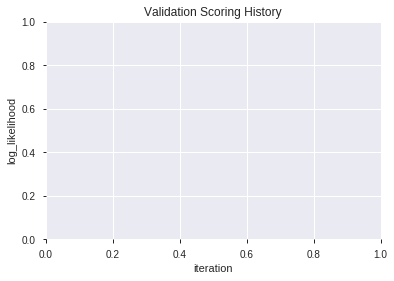

In [12]:
# GLM with top DeepLearning features
model_train(feature_name='DLF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190822_105606_model_4  0.861559  0.503441              0.209225  0.407186  0.165800
1  XGBoost_grid_1_AutoML_20190822_105606_model_2  0.859596  0.501479              0.204134  0.406947  0.165606
2  XGBoost_grid_1_AutoML_20190822_105606_model_6  0.858308  0.499470              0.224161  0.407083  0.165716
3  XGBoost_grid_1_AutoML_20190822_105606_model_1  0.857818  0.504484              0.234006  0.407831  0.166326
4               XGBoost_2_AutoML_20190822_105606  0.855487  0.496461              0.224039  0.404334  0.163486
5  XGBoost_grid_1_AutoML_20190822_105606_model_3  0.851929  0.504533              0.209103  0.409775  0.167916
6               XGBoost_3_AutoML_20190822_105606  0.850702  0.506719              0.231460  0.410295  0.168342
7               XGBoost_1_AutoML_20190822_105606  0.850641  0.502597              0.202478  0.406944  0.165603
8  XGBoost_grid_1_AutoML_20190822_105606_model_7  0.848924  0.500501              0.211311  0.407152  0.165772
9  XGBoost_grid_1_AutoML_20190822_105606_model_5  0.835184  0.509444              0.289640  0.414898  0.172140

variable  relative_importance  scaled_importance  percentage
0   CDLGRAVESTONEDOJI           830.964539           1.000000    0.142683
1           CDLTAKURI           788.068481           0.948378    0.135317
2        STOCHF_fastk           739.042542           0.889379    0.126899
3    CDLDRAGONFLYDOJI           654.060547           0.787110    0.112307
4               CCI_8           643.496704           0.774397    0.110493
5              ULTOSC           319.041443           0.383941    0.054782
6        aroondown_14           280.101318           0.337080    0.048095
7           PLUS_DI_8           243.312866           0.292808    0.041779
8                 SIN           241.035217           0.290067    0.041388
9             WILLR_8           215.092728           0.258847    0.036933
10               COSH           207.001358           0.249110    0.035544
11          CORREL_12           165.638336           0.199333    0.028441
12             TRANGE           123.627991           0.148776    0.021228
13         PLUS_DI_12           109.631783           0.131933    0.018825
14          CORREL_14            97.470581           0.117298    0.016736
15             CCI_12            70.546242           0.084897    0.012113
16             SAREXT            64.069496           0.077103    0.011001
17       weekday_name            31.657217           0.038097    0.005436

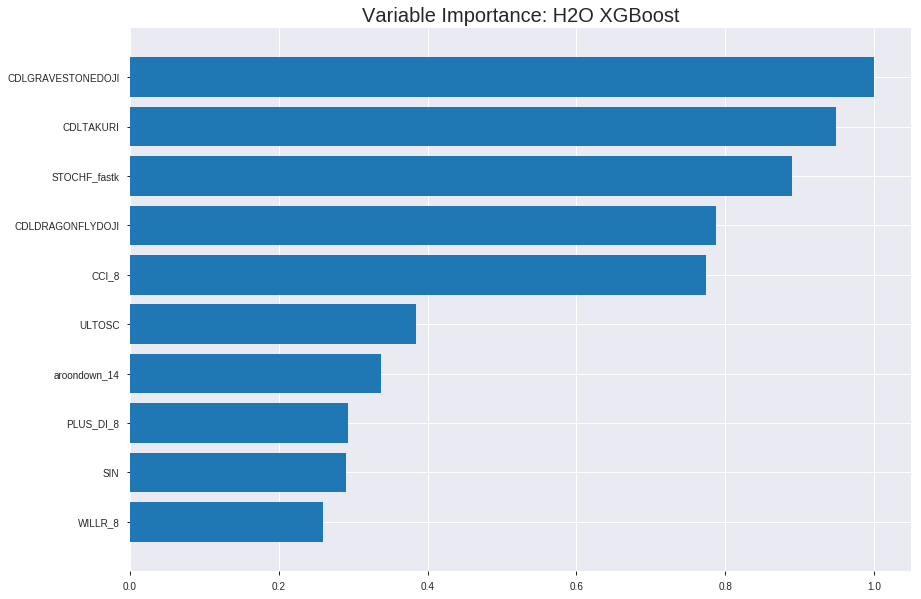

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190822_105606_model_4


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.16337360534543985
RMSE: 0.4041950090555793
LogLoss: 0.49834551506484076
Mean Per-Class Error: 0.23070936012453092
AUC: 0.8506462173225346
pr_auc: 0.8553514690024762
Gini: 0.7012924346450693
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4790052533149719: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      567  280   0.3306   (280.0/847.0)
1      132  810   0.1401   (132.0/942.0)
Total  699  1090  0.2303   (412.0/1789.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.479005     0.797244  224
max f2                       0.298741     0.874327  308
max f0point5                 0.582129     0.793004  170
max accuracy                 0.503345     0.772499  213
max precision                0.930191     1         0
max recall                   0.103831     1         386
max specificity              0.930191     1         0
max absolute_mcc             0.503345     0.543956  213
max min_per_class_accuracy   0.537875     0.766234  193
max mean_per_class_accuracy  0.535082     0.769291  195

Gains/Lift Table: Avg response rate: 52.66 %, avg score: 52.63 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100615                   0.914196           1.89915   1.89915            1                0.921992  1                           0.921992            0.0191083       0.0191083                  89.9151   89.9151
    2        0.020123                    0.903734           1.89915   1.89915            1                0.907882  1                           0.914937            0.0191083       0.0382166                  89.9151   89.9151
    3        0.0301845                   0.897441           1.89915   1.89915            1                0.90085   1                           0.910241            0.0191083       0.0573248                  89.9151   89.9151
    4        0.0402459                   0.888702           1.68813   1.8464             0.888889         0.893304  0.972222                    0.906007            0.0169851       0.07431                    68.8134   84.6397
    5        0.0503074                   0.880105           1.89915   1.85695            1                0.884977  0.977778                    0.901801            0.0191083       0.0934183                  89.9151   85.6947
    6        0.100056                    0.845859           1.79246   1.82488            0.94382          0.864505  0.960894                    0.883257            0.089172        0.18259                    79.2457   82.4882
    7        0.150363                    0.789761           1.64593   1.76501            0.866667         0.818494  0.929368                    0.861589            0.0828025       0.265393                   64.5931   76.501
    8        0.200112                    0.743399           1.68576   1.74531            0.88764          0.768077  0.918994                    0.838342            0.0838641       0.349257                   68.5763   74.5309
    9        0.300168                    0.670175           1.52781   1.67281            0.804469         0.705817  0.880819                    0.794167            0.152866        0.502123                   52.7808   67.2809
    10       0.400224                    0.608745           1.35805   1.59412            0.715084         0.638643  0.839385                    0.755286            0.135881        0.638004                   35.8052   59.412
    11       0.500279                    0.551367           1.12464   1.50022            0.592179         0.58151   0.789944                    0.720531            0.112527        0.750531                   12.4637   50.0223
    12       0.599776                    0.484086           1.00292   1.41773            0.52809          0.517511  0.746505                    0.686852            0.0997877       0.850318                   0.29223   41.7726
    13       0.699832                    0.403913           0.657806  1.30908            0.346369         0.447544  0.689297                    0.652638            0.0658174       0.916136                   -34.2194  30.9079
    14       0.799888                    0.300117           0.48805   1.20638            0.256983         0.355614  0.63522                     0.615484            0.0488323       0.964968                   -51.195   20.6379
    15       0.899944                    0.15321            0.254635  1.10056            0.134078         0.220646  0.579503                    0.571586            0.0254777       0.990446                   -74.5365  10.0564
    16       1                           0.0715755          0.095488  1                  0.0502793        0.118978  0.526551                    0.5263             



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.17542855243858207
RMSE: 0.4188419181965698
LogLoss: 0.5245745592943788
Mean Per-Class Error: 0.25853737610769745
AUC: 0.8178512983604533
pr_auc: 0.8282148753743009
Gini: 0.6357025967209067
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.49563589692115784: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      136  97   0.4163   (97.0/233.0)
1      34   244  0.1223   (34.0/278.0)
Total  170  341  0.2564   (131.0/511.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.495636     0.788368  258
max f2                       0.337328     0.877538  316
max f0point5                 0.701445     0.768859  139
max accuracy                 0.526205     0.749511  242
max precision                0.933955     1         0
max recall                   0.111352     1         390
max specificity              0.933955     1         0
max absolute_mcc             0.526205     0.495402  242
max min_per_class_accuracy   0.613263     0.733813  195
max mean_per_class_accuracy  0.595736     0.741463  208

Gains/Lift Table: Avg response rate: 54.40 %, avg score: 58.04 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117417                   0.915921           1.53177   1.53177            0.833333         0.920816  0.833333                    0.920816            0.0179856       0.0179856                  53.1775   53.1775
    2        0.0215264                   0.912799           1.83813   1.67103            1                0.91426   0.909091                    0.917836            0.0179856       0.0359712                  83.8129   67.1027
    3        0.0313112                   0.909145           1.4705    1.60836            0.8              0.910827  0.875                       0.915646            0.0143885       0.0503597                  47.0504   60.8363
    4        0.0410959                   0.905589           1.83813   1.66307            1                0.907156  0.904762                    0.913624            0.0179856       0.0683453                  83.8129   66.307
    5        0.0508806                   0.898167           1.83813   1.69673            1                0.900634  0.923077                    0.911126            0.0179856       0.0863309                  83.8129   69.6735
    6        0.101761                    0.880335           1.76743   1.73208            0.961538         0.88891   0.942308                    0.900018            0.0899281       0.176259                   76.7432   73.2084
    7        0.150685                    0.858255           1.61755   1.6949             0.88             0.869162  0.922078                    0.89                0.0791367       0.255396                   61.7554   69.4899
    8        0.201566                    0.818805           1.69673   1.69536            0.923077         0.840551  0.92233                     0.877518            0.0863309       0.341727                   69.6735   69.5362
    9        0.30137                     0.739543           1.36959   1.58748            0.745098         0.773108  0.863636                    0.84294             0.136691        0.478417                   36.9587   58.7475
    10       0.401174                    0.68109            1.26146   1.50637            0.686275         0.71194   0.819512                    0.81035             0.125899        0.604317                   26.1461   50.637
    11       0.500978                    0.627876           1.00917   1.40732            0.54902          0.656422  0.765625                    0.779685            0.100719        0.705036                   0.916914  40.7318
    12       0.600783                    0.552903           0.973127  1.33519            0.529412         0.591538  0.726384                    0.748429            0.0971223       0.802158                   -2.68726  33.5189
    13       0.700587                    0.478732           0.901044  1.27334            0.490196         0.510991  0.692737                    0.714604            0.0899281       0.892086                   -9.89561  27.3341
    14       0.800391                    0.351441           0.61271   1.19096            0.333333         0.416956  0.647922                    0.677489            0.0611511       0.953237                   -38.729   19.0964
    15       0.900196                    0.167962           0.360418  1.09888            0.196078         0.253698  0.597826                    0.630503            0.0359712       0.989209                   -63.9582  9.88818
    16       1                           0.0778268          0.108125  1                  0.0588235        0.12826   0.544031                    0.580377           


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-22 10:56:19  5.271 sec   0                  0.5              0.693147            0.5             0                  1                0.473449                         0.5                0.693147              0.5               0                    1                  0.455969
    2019-08-22 10:56:19  5.384 sec   5                  0.475939         0.645798            0.790666        0.591258           1.74294          0.285634                         0.473308           0.640718              0.787075          0.508208             1.6727             0.289628
    2019-08-22 10:56:19  5.439 sec   10                 0.459618         0.613675            0.804259        0.604059           1.74294          0.297373                         0.457097           0.608666              0.785863          0.508162             1.6727             0.303327
    2019-08-22 10:56:19  5.505 sec   15                 0.448389         0.590837            0.80899         0.607393           1.74294          0.286752                         0.445353           0.584568              0.79359           0.513854             1.6727             0.305284
    2019-08-22 10:56:19  5.568 sec   20                 0.440273         0.573876            0.814491        0.612199           1.74294          0.267747                         0.438597           0.569734              0.793266          0.514127             1.6727             0.318982
    2019-08-22 10:56:19  5.636 sec   25                 0.4347           0.562211            0.818246        0.829016           1.89915          0.274455                         0.434341           0.560189              0.799217          0.812889             1.53177            0.299413
    2019-08-22 10:56:19  5.707 sec   30                 0.429704         0.551738            0.823532        0.828225           1.7992           0.262158                         0.430749           0.552181              0.803169          0.810095             1.60836            0.295499
    2019-08-22 10:56:19  5.779 sec   35                 0.425803         0.543464            0.828064        0.835534           1.89915          0.257127                         0.428631           0.547058              0.803972          0.816674             1.83813            0.291585
    2019-08-22 10:56:20  5.860 sec   40                 0.422202         0.53586             0.830651        0.838872           1.89915          0.252096                         0.42678            0.542607              0.805879          0.82136              1.83813            0.291585
    2019-08-22 10:56:20  5.939 sec   45                 0.419205         0.529599            0.834704        0.844205           1.89915          0.249301                         0.425598           0.539713              0.80689           0.826088             1.83813            0.297456
    2019-08-22 10:56:20  6.017 sec   50                 0.416449         0.523818            0.837563        0.846842           1.89915          0.243153                         0.423838           0.535853              0.810024          0.825957             1.83813            0.295499
    2019-08-22 10:56:20  6.111 sec   55                 0.4139           0.518276            0.838488        0.847515           1.89915          0.237563                         0.422271           0.532404              0.811583          0

Variable Importances: 


variable           relative_importance    scaled_importance    percentage
-----------------  ---------------------  -------------------  ------------
CDLGRAVESTONEDOJI  830.965                1                    0.142683
CDLTAKURI          788.068                0.948378             0.135317
STOCHF_fastk       739.043                0.889379             0.126899
CDLDRAGONFLYDOJI   654.061                0.78711              0.112307
CCI_8              643.497                0.774397             0.110493
ULTOSC             319.041                0.383941             0.0547818
aroondown_14       280.101                0.33708              0.0480955
PLUS_DI_8          243.313                0.292808             0.0417786
SIN                241.035                0.290067             0.0413875
WILLR_8            215.093                0.258847             0.036933
COSH               207.001                0.24911              0.0355437
CORREL_12          165.638                0.199333             0.0284413
TRANGE             123.628                0.148776             0.0212278
PLUS_DI_12         109.632                0.131933             0.0188246
CORREL_14          97.4706                0.117298             0.0167364
CCI_12             70.5462                0.0848968            0.0121133
SAREXT             64.0695                0.0771026            0.0110012
weekday_name       31.6572                0.038097             0.00543578

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.80078125)

('F1', 0.782258064516129)

('auc', 0.8615592222290376)

('logloss', 0.5034411875033598)

('mean_per_class_error', 0.20214071029871805)

('rmse', 0.40718585635841403)

('mse', 0.16580032161833497)

xgboost prediction progress: |████████████████████████████████████████████| 100%


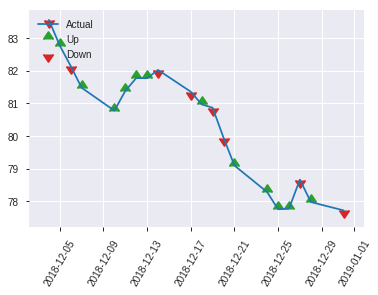


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.16580032161833497
RMSE: 0.40718585635841403
LogLoss: 0.5034411875033598
Mean Per-Class Error: 0.20214071029871805
AUC: 0.8615592222290376
pr_auc: 0.8371731200304808
Gini: 0.7231184444580752
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.563201367855072: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      105  32   0.2336   (32.0/137.0)
1      22   97   0.1849   (22.0/119.0)
Total  127  129  0.2109   (54.0/256.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.563201     0.782258  128
max f2                       0.309139     0.852941  203
max f0point5                 0.687208     0.827423  75
max accuracy                 0.615855     0.800781  105
max precision                0.92142      1         0
max recall                   0.132958     1         243
max specificity              0.92142      1         0
max absolute_mcc             0.615855     0.599867  105
max min_per_class_accuracy   0.572486     0.773723  123
max mean_per_class_accuracy  0.602799     0.797859  111

Gains/Lift Table: Avg response rate: 46.48 %, avg score: 53.99 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117188                   0.910393           2.15126    2.15126            1                0.916106  1                           0.916106            0.0252101       0.0252101                  115.126   115.126
    2        0.0234375                   0.899622           2.15126    2.15126            1                0.902915  1                           0.90951             0.0252101       0.0504202                  115.126   115.126
    3        0.03125                     0.896061           2.15126    2.15126            1                0.897823  1                           0.906588            0.0168067       0.0672269                  115.126   115.126
    4        0.0429688                   0.891708           2.15126    2.15126            1                0.894135  1                           0.903192            0.0252101       0.092437                   115.126   115.126
    5        0.0507812                   0.889015           2.15126    2.15126            1                0.889346  1                           0.901062            0.0168067       0.109244                   115.126   115.126
    6        0.101562                    0.86657            1.65482    1.90304            0.769231         0.875787  0.884615                    0.888424            0.0840336       0.193277                   65.4816   90.3038
    7        0.152344                    0.83582            1.98578    1.93062            0.923077         0.851974  0.897436                    0.876274            0.10084         0.294118                   98.5779   93.0618
    8        0.203125                    0.774728           2.15126    1.98578            1                0.804033  0.923077                    0.858214            0.109244        0.403361                   115.126   98.5779
    9        0.300781                    0.686336           1.89311    1.95569            0.88             0.720696  0.909091                    0.813565            0.184874        0.588235                   89.3109   95.5691
    10       0.402344                    0.621287           1.24111    1.77531            0.576923         0.655389  0.825243                    0.773637            0.12605         0.714286                   24.1112   77.5312
    11       0.5                         0.564638           0.946555   1.61345            0.44             0.591434  0.75                        0.738051            0.092437        0.806723                   -5.34454  61.3445
    12       0.601562                    0.498256           0.661926   1.4528             0.307692         0.526303  0.675325                    0.702301            0.0672269       0.87395                    -33.8074  45.2799
    13       0.699219                    0.426742           0.516303   1.322              0.24             0.459152  0.614525                    0.668342            0.0504202       0.92437                    -48.3697  32.2004
    14       0.800781                    0.305517           0.496445   1.2173             0.230769         0.37461   0.565854                    0.631088            0.0504202       0.97479                    -50.3555  21.7299
    15       0.898438                    0.156573           0.0860504  1.09434            0.04             0.219556  0.508696                    0.586356            0.00840336      0.983193                   -91.395   9.43369
    16       1                           0.0822309          0.165482   1                  0.0769231        0.128592  0.464844                   

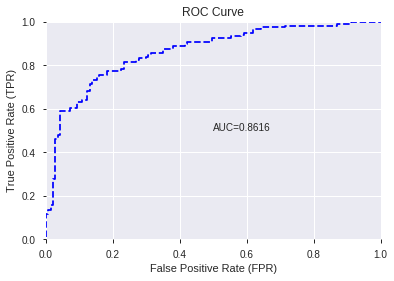

This function is available for GLM models only


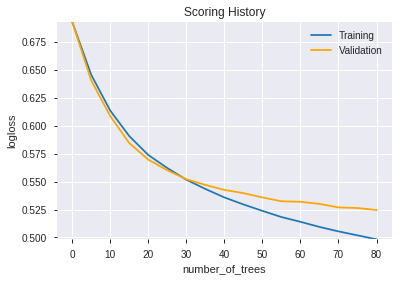

--2019-08-22 10:56:34--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.217.33.4
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.217.33.4|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genm

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190822_105606_model_4',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190822_105606_model_4',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_26_sid_a945',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['CDLGRAVESTONEDOJI',
 'CDLTAKURI',
 'STOCHF_fastk',
 'CDLDRAGONFLYDOJI',
 'CCI_8',
 'ULTOSC',
 'aroondown_14',
 'PLUS_DI_8',
 'SIN',
 'WILLR_8',
 'COSH',
 'CORREL_12',
 'TRANGE',
 'PLUS_DI_12',
 'CORREL_14',
 'CCI_12',
 'SAREXT',
 'weekday_name']

In [13]:
# XGBoost with top DeepLearning features
model_train(feature_name='DLF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse      mse
0  GLM_grid_1_AutoML_20190822_105643_model_1  0.878305  0.458137              0.184567  0.386549  0.14942

variable  relative_importance  scaled_importance    percentage
0                 STOCHF_fastk             0.812345           1.000000  1.240845e-02
1                         MULT             0.770787           0.948841  1.177366e-02
2            CDLGRAVESTONEDOJI             0.728975           0.897371  1.113499e-02
3                          Low             0.724059           0.891320  1.105990e-02
4                         High             0.703949           0.866565  1.075273e-02
...                        ...                  ...                ...           ...
1020  BBANDS_middleband_24_1_4             0.000231           0.000284  3.525419e-06
1021                  TRIMA_12             0.000224           0.000276  3.420388e-06
1022   BBANDS_upperband_12_3_2             0.000215           0.000265  3.291448e-06
1023                   MA_20_3             0.000095           0.000116  1.445097e-06
1024                   MA_24_1             0.000013           0.000015  1.909627e-07

[1025 rows x 4 columns]

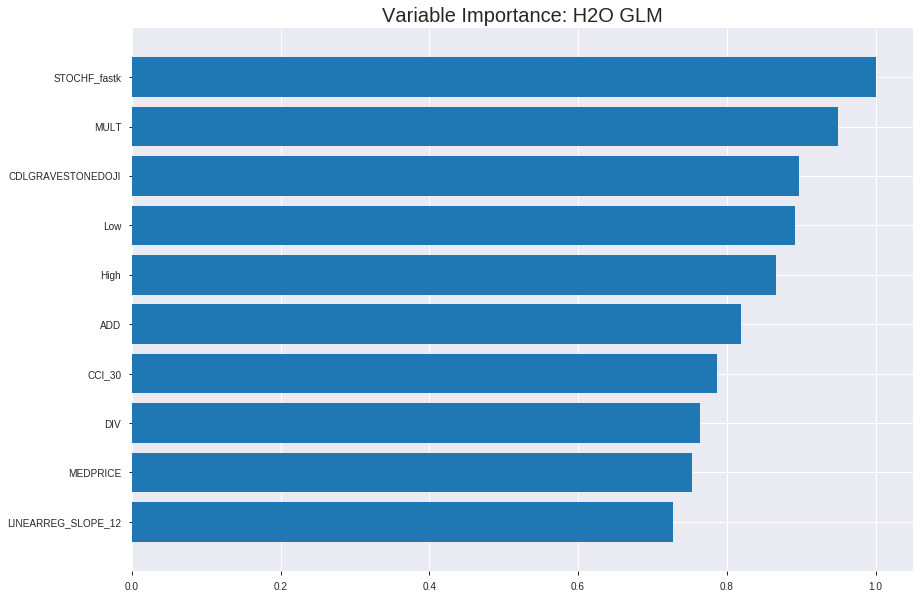

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190822_105643_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.15308000532320112
RMSE: 0.3912543997493205
LogLoss: 0.46734598639715863
Null degrees of freedom: 1788
Residual degrees of freedom: 763
Null deviance: 2475.0335207517455
Residual deviance: 1672.1639393290336
AIC: 3724.1639393290334
AUC: 0.859120613029125
pr_auc: 0.8627320192163519
Gini: 0.71824122605825
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4827747392319116: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      600  247   0.2916   (247.0/847.0)
1      148  794   0.1571   (148.0/942.0)
Total  748  1041  0.2208   (395.0/1789.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.482775     0.800807  219
max f2                       0.198084     0.882071  321
max f0point5                 0.606645     0.802158  170
max accuracy                 0.484156     0.779206  218
max precision                0.998352     1         0
max recall                   0.01978      1         391
max specificity              0.998352     1         0
max absolute_mcc             0.482775     0.558027  219
max min_per_class_accuracy   0.549289     0.774947  194
max mean_per_class_accuracy  0.538679     0.776429  198

Gains/Lift Table: Avg response rate: 52.66 %, avg score: 52.66 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100615                   0.991504           1.89915    1.89915            1                0.994463   1                           0.994463            0.0191083       0.0191083                  89.9151   89.9151
    2        0.020123                    0.983349           1.89915    1.89915            1                0.987644   1                           0.991054            0.0191083       0.0382166                  89.9151   89.9151
    3        0.0301845                   0.975562           1.89915    1.89915            1                0.978691   1                           0.986933            0.0191083       0.0573248                  89.9151   89.9151
    4        0.0402459                   0.96809            1.79364    1.87277            0.944444         0.972      0.986111                    0.9832              0.0180467       0.0753715                  79.3642   87.2774
    5        0.0503074                   0.95983            1.89915    1.87805            1                0.963572   0.988889                    0.979274            0.0191083       0.0944798                  89.9151   87.8049
    6        0.100056                    0.914149           1.74978    1.81427            0.921348         0.936032   0.955307                    0.957774            0.0870488       0.181529                   74.9779   81.4272
    7        0.150363                    0.859748           1.70924    1.77913            0.9              0.885641   0.936803                    0.93364             0.0859873       0.267516                   70.9236   77.913
    8        0.200112                    0.811954           1.64309    1.74531            0.865169         0.834484   0.918994                    0.90899             0.081741        0.349257                   64.3085   74.5309
    9        0.300168                    0.719551           1.59147    1.69403            0.837989         0.765243   0.891993                    0.861074            0.159236        0.508493                   59.1467   69.4028
    10       0.400224                    0.645863           1.31561    1.59942            0.692737         0.681478   0.842179                    0.816175            0.131635        0.640127                   31.5613   59.9424
    11       0.500279                    0.561745           1.20951    1.52144            0.636872         0.603755   0.801117                    0.773691            0.121019        0.761146                   20.9515   52.1443
    12       0.599776                    0.466196           0.938906   1.42481            0.494382         0.512322   0.750233                    0.730332            0.0934183       0.854565                   -6.1094   42.4806
    13       0.699832                    0.360718           0.742685   1.32728            0.391061         0.417025   0.698882                    0.685538            0.07431         0.928875                   -25.7315  32.7282
    14       0.799888                    0.202466           0.435001   1.21567            0.22905          0.287011   0.640112                    0.635688            0.0435244       0.972399                   -56.4999  21.5669
    15       0.899944                    0.0847573          0.201586   1.10292            0.106145         0.135429   0.580745                    0.580069            0.0201699       0.992569                   -79.8414  10.2923
    16       1                           0.000764358        0.0742685  1                  0.0391061        0.0451902  0.526551  



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.17098030789572255
RMSE: 0.4134976516205655
LogLoss: 0.5130333987723205
Null degrees of freedom: 510
Residual degrees of freedom: -515
Null deviance: 705.0556929735951
Residual deviance: 524.3201335453115
AIC: 2576.3201335453114
AUC: 0.8243508197733659
pr_auc: 0.8462464431955171
Gini: 0.6487016395467318
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4894024335588528: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      153  80   0.3433   (80.0/233.0)
1      47   231  0.1691   (47.0/278.0)
Total  200  311  0.2485   (127.0/511.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.489402     0.78438   235
max f2                       0.14846      0.883676  345
max f0point5                 0.653742     0.783133  169
max accuracy                 0.489402     0.751468  235
max precision                0.997643     1         0
max recall                   0.00279183   1         398
max specificity              0.997643     1         0
max absolute_mcc             0.489402     0.497574  235
max min_per_class_accuracy   0.567196     0.733906  202
max mean_per_class_accuracy  0.489402     0.743794  235

Gains/Lift Table: Avg response rate: 54.40 %, avg score: 55.76 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117417                   0.993952           1.83813   1.83813            1                0.995349   1                           0.995349            0.0215827       0.0215827                  83.8129   83.8129
    2        0.0215264                   0.989343           1.83813   1.83813            1                0.990783   1                           0.993273            0.0179856       0.0395683                  83.8129   83.8129
    3        0.0313112                   0.981571           1.83813   1.83813            1                0.98503    1                           0.990697            0.0179856       0.057554                   83.8129   83.8129
    4        0.0410959                   0.976699           1.83813   1.83813            1                0.979346   1                           0.987994            0.0179856       0.0755396                  83.8129   83.8129
    5        0.0508806                   0.970592           1.83813   1.83813            1                0.974349   1                           0.98537             0.0179856       0.0935252                  83.8129   83.8129
    6        0.101761                    0.941684           1.69673   1.76743            0.923077         0.955416   0.961538                    0.970393            0.0863309       0.179856                   69.6735   76.7432
    7        0.150685                    0.908142           1.61755   1.71877            0.88             0.927401   0.935065                    0.956435            0.0791367       0.258993                   61.7554   71.877
    8        0.201566                    0.865899           1.69673   1.71321            0.923077         0.887956   0.932039                    0.939149            0.0863309       0.345324                   69.6735   71.3208
    9        0.30137                     0.776351           1.40563   1.61135            0.764706         0.818822   0.876623                    0.8993              0.140288        0.485612                   40.5628   61.1347
    10       0.401174                    0.675314           1.18938   1.50637            0.647059         0.733946   0.819512                    0.858163            0.118705        0.604317                   18.9378   50.637
    11       0.500978                    0.589524           1.11729   1.42886            0.607843         0.631384   0.777344                    0.812985            0.111511        0.715827                   11.7294   42.8858
    12       0.600783                    0.492708           1.04521   1.36513            0.568627         0.544064   0.742671                    0.768311            0.104317        0.820144                   4.52109   36.5125
    13       0.700587                    0.381515           0.648752  1.26307            0.352941         0.441493   0.687151                    0.721753            0.0647482       0.884892                   -35.1248  26.3072
    14       0.800391                    0.224853           0.684793  1.19096            0.372549         0.303259   0.647922                    0.669569            0.0683453       0.953237                   -31.5207  19.0964
    15       0.900196                    0.101305           0.360418  1.09888            0.196078         0.164491   0.597826                    0.613571            0.0359712       0.989209                   -63.9582  9.88818
    16       1                           0.00148356         0.108125  1                  0.0588235        0.0522934  0.544031                    0


Scoring History: 


timestamp            duration          iteration    lambda    predictors    deviance_train      deviance_test
---  -------------------  ----------------  -----------  --------  ------------  ------------------  ------------------
     2019-08-22 10:56:47  0.000 sec         2            .17E2     1021          1.3592369280662413  1.3536194770204326
     2019-08-22 10:56:50  2.289 sec         4            .12E2     1021          1.351719690680717   1.3455448218794703
     2019-08-22 10:56:52  4.600 sec         6            .91E1     1021          1.342027444641428   1.335047979887512
     2019-08-22 10:56:55  7.213 sec         8            .66E1     1022          1.3297883549689842  1.321760434196016
     2019-08-22 10:56:57  9.611 sec         10           .48E1     1026          1.3146871975952261  1.3054676815197517
---  ---                  ---               ---          ---       ---           ---                 ---
     2019-08-22 10:57:46  59.001 sec        52           .61E-2    1026          0.9651833193309697  1.0413259330882316
     2019-08-22 10:57:49  1 min  1.351 sec  54           .44E-2    1026          0.9572609375246793  1.0366319581598078
     2019-08-22 10:57:51  1 min  3.820 sec  56           .32E-2    1026          0.9496373750237581  1.0324591589855634
     2019-08-22 10:57:54  1 min  6.220 sec  58           .23E-2    1026          0.9421643167023088  1.028921552754267
     2019-08-22 10:57:56  1 min  8.586 sec  60           .17E-2    1026          0.9346919727943174  1.026066797544641


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.8125)

('F1', 0.8095238095238094)

('auc', 0.8783046065141386)

('logloss', 0.45813703124605004)

('mean_per_class_error', 0.1845672575599583)

('rmse', 0.3865494403535149)

('mse', 0.14942046983761556)

glm prediction progress: |████████████████████████████████████████████████| 100%


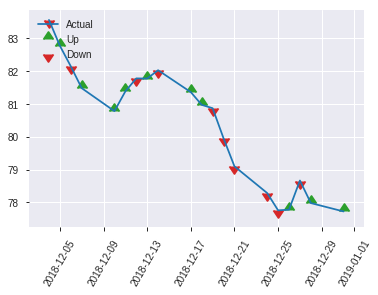


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.14942046983761556
RMSE: 0.3865494403535149
LogLoss: 0.45813703124605004
Null degrees of freedom: 255
Residual degrees of freedom: -770
Null deviance: 357.52774107262724
Residual deviance: 234.56615999797762
AIC: 2286.5661599979776
AUC: 0.8783046065141386
pr_auc: 0.852239414934208
Gini: 0.7566092130282771
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5481690992656671: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      106  31   0.2263   (31.0/137.0)
1      17   102  0.1429   (17.0/119.0)
Total  123  133  0.1875   (48.0/256.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.548169     0.809524  132
max f2                       0.31698      0.859729  186
max f0point5                 0.750609     0.812065  77
max accuracy                 0.548169     0.8125    132
max precision                0.994329     1         0
max recall                   0.0780641    1         236
max specificity              0.994329     1         0
max absolute_mcc             0.548169     0.629785  132
max min_per_class_accuracy   0.586494     0.798319  121
max mean_per_class_accuracy  0.548169     0.815433  132

Gains/Lift Table: Avg response rate: 46.48 %, avg score: 53.67 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117188                   0.990872           2.15126    2.15126            1                0.993685   1                           0.993685            0.0252101       0.0252101                  115.126   115.126
    2        0.0234375                   0.986778           2.15126    2.15126            1                0.988069   1                           0.990877            0.0252101       0.0504202                  115.126   115.126
    3        0.03125                     0.982721           1.07563    1.88235            0.5              0.983836   0.875                       0.989117            0.00840336      0.0588235                  7.56303   88.2353
    4        0.0429688                   0.978907           2.15126    1.95569            1                0.980777   0.909091                    0.986842            0.0252101       0.0840336                  115.126   95.5691
    5        0.0507812                   0.971988           2.15126    1.98578            1                0.975424   0.923077                    0.985086            0.0168067       0.10084                    115.126   98.5779
    6        0.101562                    0.940209           2.15126    2.06852            1                0.957279   0.961538                    0.971182            0.109244        0.210084                   115.126   106.852
    7        0.152344                    0.897749           2.15126    2.0961             1                0.919917   0.974359                    0.954094            0.109244        0.319328                   115.126   109.61
    8        0.203125                    0.836939           1.48933    1.94441            0.692308         0.864443   0.903846                    0.931681            0.0756303       0.394958                   48.9334   94.4409
    9        0.300781                    0.751881           1.89311    1.92775            0.88             0.792228   0.896104                    0.886404            0.184874        0.579832                   89.3109   92.7753
    10       0.402344                    0.672028           1.32385    1.77531            0.615385         0.707181   0.825243                    0.841163            0.134454        0.714286                   32.3853   77.5312
    11       0.5                         0.568237           1.11866    1.64706            0.52             0.618242   0.765625                    0.797624            0.109244        0.823529                   11.8655   64.7059
    12       0.601562                    0.449504           0.744667   1.49471            0.346154         0.511382   0.694805                    0.749297            0.0756303       0.89916                    -25.5333  49.4707
    13       0.699219                    0.338392           0.430252   1.34604            0.2              0.398662   0.625698                    0.700326            0.0420168       0.941176                   -56.9748  34.604
    14       0.800781                    0.20559            0.330963   1.2173             0.153846         0.280073   0.565854                    0.647026            0.0336134       0.97479                    -66.9037  21.7299
    15       0.898438                    0.096315           0.172101   1.10369            0.08             0.140374   0.513043                    0.591955            0.0168067       0.991597                   -82.7899  10.369
    16       1                           0.00404166         0.0827408  1                  0.0384615        0.0482493  0.464844    

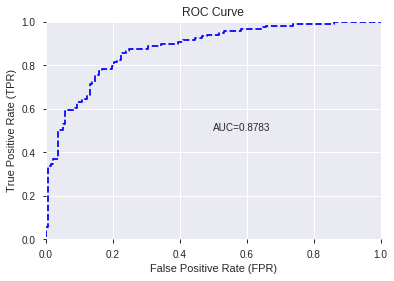

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


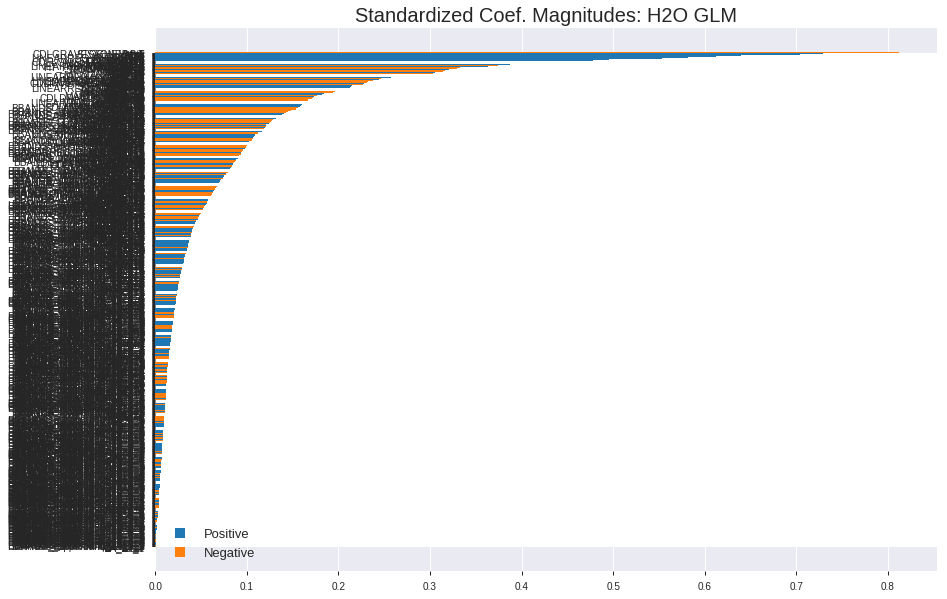

'log_likelihood'
--2019-08-22 10:58:27--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.104.43
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.104.43|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190822_105643_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190822_105643_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_34_sid_a945',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_34_s

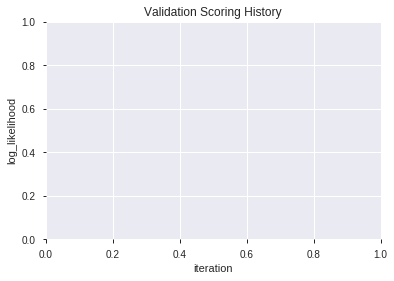

In [14]:
# GLM
glm_features = model_train(feature_name='All',model_algo="GLM")

In [15]:
# DeepLearning with top GLM features
model_train(feature_name='GLMF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

[]

In [16]:
# GLM with top GLM features
model_train(feature_name='GLMF',model_algo="GLM",features_list = features_list[:model_selected_features])

[]

In [17]:
# XGBoost with top GLM features
model_train(feature_name='GLMF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

[]

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190822_105835_model_2  0.874318  0.486979              0.194075  0.398732  0.158988
1  XGBoost_grid_1_AutoML_20190822_105835_model_6  0.864319  0.488344              0.198491  0.401059  0.160848
2  XGBoost_grid_1_AutoML_20190822_105835_model_3  0.859351  0.488501              0.209011  0.399837  0.159870
3               XGBoost_2_AutoML_20190822_105835  0.855119  0.489601              0.222168  0.400295  0.160236
4               XGBoost_3_AutoML_20190822_105835  0.854015  0.494833              0.233669  0.403877  0.163116
5  XGBoost_grid_1_AutoML_20190822_105835_model_4  0.851561  0.505017              0.225817  0.407370  0.165951
6  XGBoost_grid_1_AutoML_20190822_105835_model_7  0.850212  0.493657              0.215298  0.403074  0.162468
7  XGBoost_grid_1_AutoML_20190822_105835_model_1  0.847022  0.501378              0.219837  0.407470  0.166032
8               XGBoost_1_AutoML_20190822_105835  0.844814  0.503726              0.230234  0.408136  0.166575
9  XGBoost_grid_1_AutoML_20190822_105835_model_5  0.840459  0.501461              0.245170  0.411209  0.169093

variable  relative_importance  scaled_importance    percentage
0                  CDLTAKURI          1125.538330           1.000000  1.014730e-01
1          CDLGRAVESTONEDOJI          1018.923157           0.905276  9.186114e-02
2           CDLDRAGONFLYDOJI           820.692444           0.729155  7.398962e-02
3               STOCHF_fastk           648.346619           0.576032  5.845177e-02
4                      CCI_8           338.620667           0.300852  3.052839e-02
..                       ...                  ...                ...           ...
339                STDDEV_20             0.365653           0.000325  3.296552e-05
340                     fama             0.224897           0.000200  2.027559e-05
341  BBANDS_upperband_12_0_2             0.195663           0.000174  1.764003e-05
342                  weekday             0.006664           0.000006  6.007513e-07
343                   MA_8_4             0.003238           0.000003  2.919008e-07

[344 rows x 4 columns]

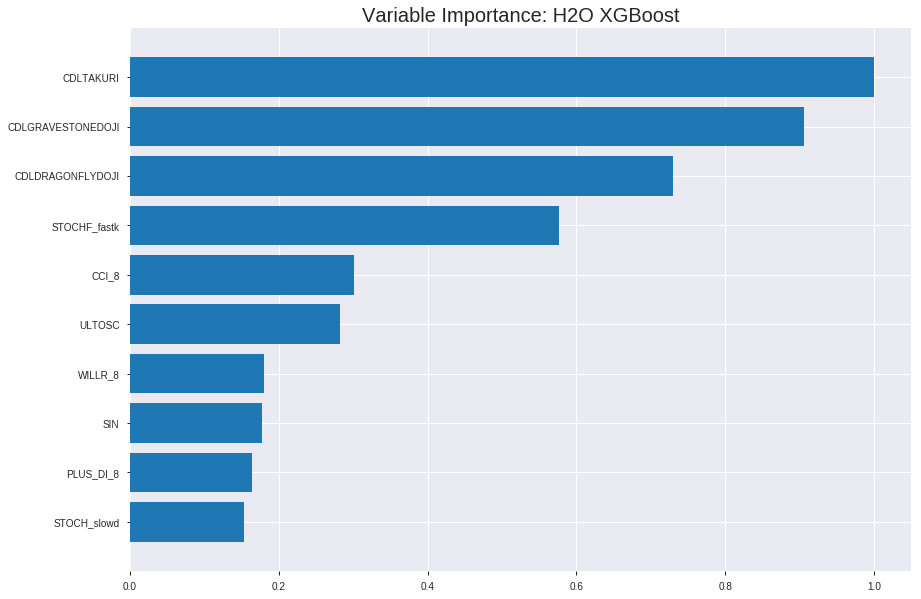

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190822_105835_model_2


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.1252704867548411
RMSE: 0.3539357099175514
LogLoss: 0.41084488107945316
Mean Per-Class Error: 0.11469480143481303
AUC: 0.9491573857526378
pr_auc: 0.9560265551211568
Gini: 0.8983147715052755
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5354776829481125: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      755  92   0.1086   (92.0/847.0)
1      116  826  0.1231   (116.0/942.0)
Total  871  918  0.1163   (208.0/1789.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.535478     0.888172  196
max f2                       0.458631     0.911693  238
max f0point5                 0.587875     0.912737  171
max accuracy                 0.54225      0.884293  192
max precision                0.945933     1         0
max recall                   0.117037     1         373
max specificity              0.945933     1         0
max absolute_mcc             0.54225      0.769526  192
max min_per_class_accuracy   0.532742     0.880042  198
max mean_per_class_accuracy  0.54225      0.885305  192

Gains/Lift Table: Avg response rate: 52.66 %, avg score: 52.50 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100615                   0.931354           1.89915    1.89915            1                0.937249  1                           0.937249            0.0191083       0.0191083                  89.9151   89.9151
    2        0.020123                    0.923802           1.89915    1.89915            1                0.927752  1                           0.932501            0.0191083       0.0382166                  89.9151   89.9151
    3        0.0301845                   0.9174             1.89915    1.89915            1                0.91995   1                           0.928317            0.0191083       0.0573248                  89.9151   89.9151
    4        0.0402459                   0.910816           1.89915    1.89915            1                0.914624  1                           0.924894            0.0191083       0.0764331                  89.9151   89.9151
    5        0.0503074                   0.902405           1.89915    1.89915            1                0.907381  1                           0.921391            0.0191083       0.0955414                  89.9151   89.9151
    6        0.100056                    0.853756           1.87781    1.88854            0.988764         0.882553  0.994413                    0.90208             0.0934183       0.18896                    87.7812   88.8541
    7        0.150363                    0.781995           1.85695    1.87797            0.977778         0.816941  0.988848                    0.873595            0.0934183       0.282378                   85.6947   87.7971
    8        0.200112                    0.738359           1.89915    1.88324            1                0.758385  0.99162                     0.844953            0.0944798       0.376858                   89.9151   88.3236
    9        0.300168                    0.679576           1.83549    1.86732            0.96648          0.708616  0.98324                     0.799507            0.183652        0.56051                    83.5492   86.7321
    10       0.400224                    0.615872           1.71878    1.83019            0.905028         0.64677   0.963687                    0.761323            0.171975        0.732484                   71.8784   83.0187
    11       0.500279                    0.54246            1.31561    1.72727            0.692737         0.580883  0.909497                    0.725235            0.131635        0.864119                   31.5613   72.7272
    12       0.599776                    0.4787             0.69351    1.55578            0.365169         0.513246  0.819199                    0.690068            0.0690021       0.933121                   -30.649   55.5781
    13       0.699832                    0.398028           0.318293   1.37886            0.167598         0.439408  0.726038                    0.654231            0.0318471       0.964968                   -68.1707  37.8856
    14       0.799888                    0.297632           0.275854   1.24088            0.145251         0.351012  0.653389                    0.616302            0.0276008       0.992569                   -72.4146  24.0885
    15       0.899944                    0.13627            0.0636587  1.11               0.0335196        0.226664  0.584472                    0.572982            0.00636943      0.998938                   -93.6341  11.0001
    16       1                           0.0597196          0.0106098  1                  0.00558659       0.093743  0.526551                   



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.17511490452960007
RMSE: 0.41846732791174995
LogLoss: 0.5241768300927857
Mean Per-Class Error: 0.2583521165899898
AUC: 0.8112977429215427
pr_auc: 0.821408407609436
Gini: 0.6225954858430853
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4258817434310913: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      115  118  0.5064   (118.0/233.0)
1      19   259  0.0683   (19.0/278.0)
Total  134  377  0.2681   (137.0/511.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.425882     0.79084   282
max f2                       0.326212     0.882546  312
max f0point5                 0.567399     0.757363  215
max accuracy                 0.534993     0.749511  232
max precision                0.942722     1         0
max recall                   0.101392     1         383
max specificity              0.942722     1         0
max absolute_mcc             0.534993     0.493639  232
max min_per_class_accuracy   0.594287     0.725322  199
max mean_per_class_accuracy  0.534993     0.741648  232

Gains/Lift Table: Avg response rate: 54.40 %, avg score: 56.81 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117417                   0.933908           1.83813   1.83813            1                0.937789  1                           0.937789            0.0215827       0.0215827                  83.8129   83.8129
    2        0.0215264                   0.924331           1.83813   1.83813            1                0.925964  1                           0.932414            0.0179856       0.0395683                  83.8129   83.8129
    3        0.0313112                   0.919574           1.83813   1.83813            1                0.921021  1                           0.928854            0.0179856       0.057554                   83.8129   83.8129
    4        0.0410959                   0.915751           1.4705    1.7506             0.8              0.917662  0.952381                    0.926189            0.0143885       0.0719424                  47.0504   75.06
    5        0.0508806                   0.909237           1.4705    1.69673            0.8              0.912247  0.923077                    0.923508            0.0143885       0.0863309                  47.0504   69.6735
    6        0.101761                    0.893494           1.69673   1.69673            0.923077         0.901096  0.923077                    0.912302            0.0863309       0.172662                   69.6735   69.6735
    7        0.150685                    0.860684           1.54403   1.64716            0.84             0.876672  0.896104                    0.900734            0.0755396       0.248201                   54.4029   64.7155
    8        0.201566                    0.785325           1.76743   1.67752            0.961538         0.822954  0.912621                    0.8811              0.0899281       0.338129                   76.7432   67.7516
    9        0.30137                     0.714418           1.18938   1.51586            0.647059         0.746691  0.824675                    0.836588            0.118705        0.456835                   18.9378   51.586
    10       0.401174                    0.66871            1.2975    1.46154            0.705882         0.688557  0.795122                    0.799761            0.129496        0.586331                   29.7503   46.1537
    11       0.500978                    0.606008           1.15334   1.40014            0.627451         0.634122  0.761719                    0.766763            0.115108        0.701439                   15.3336   40.0138
    12       0.600783                    0.539854           1.15334   1.35914            0.627451         0.573333  0.739414                    0.734629            0.115108        0.816547                   15.3336   35.9138
    13       0.700587                    0.457623           0.792919  1.27848            0.431373         0.500621  0.695531                    0.701293            0.0791367       0.895683                   -20.7081  27.8476
    14       0.800391                    0.353207           0.684793  1.20445            0.372549         0.408961  0.655257                    0.664841            0.0683453       0.964029                   -31.5207  20.4447
    15       0.900196                    0.159901           0.216251  1.09489            0.117647         0.24819   0.595652                    0.618647            0.0215827       0.985612                   -78.3749  9.48858
    16       1                           0.0634761          0.144167  1                  0.0784314        0.112124  0.544031                    0.568094            


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-22 10:59:04  4.963 sec   0                  0.5              0.693147            0.5             0                  1                0.473449                         0.5                0.693147              0.5               0                    1                  0.455969
    2019-08-22 10:59:05  6.157 sec   5                  0.47569          0.645391            0.833088        0.659234           1.85853          0.27725                          0.47755            0.64893               0.767245          0.557627             1.6496             0.311155
    2019-08-22 10:59:05  6.423 sec   10                 0.458178         0.611283            0.846028        0.684944           1.86583          0.24483                          0.461409           0.617184              0.778044          0.574196             1.71048            0.285714
    2019-08-22 10:59:06  6.676 sec   15                 0.444177         0.583705            0.857211        0.729261           1.88529          0.245947                         0.45008            0.594337              0.787268          0.618487             1.71559            0.279843
    2019-08-22 10:59:06  6.935 sec   20                 0.433732         0.562535            0.866602        0.756836           1.89915          0.22806                          0.442276           0.577895              0.794362          0.645902             1.6994             0.295499
    2019-08-22 10:59:06  7.197 sec   25                 0.424387         0.543702            0.874224        0.853349           1.89915          0.221353                         0.435502           0.56361               0.802436          0.743086             1.67829            0.299413
    2019-08-22 10:59:07  7.456 sec   30                 0.417887         0.529753            0.879713        0.866498           1.89915          0.215204                         0.432189           0.555739              0.802212          0.760056             1.62188            0.297456
    2019-08-22 10:59:07  7.720 sec   35                 0.411393         0.516152            0.883582        0.875802           1.89915          0.215204                         0.4295             0.549258              0.80205           0.775927             1.83813            0.295499
    2019-08-22 10:59:07  7.988 sec   40                 0.404319         0.502207            0.892549        0.902427           1.89915          0.191168                         0.427092           0.543872              0.803509          0.812508             1.83813            0.287671
    2019-08-22 10:59:07  8.263 sec   45                 0.397576         0.489078            0.899576        0.911621           1.89915          0.183902                         0.425024           0.539175              0.805717          0.816105             1.83813            0.287671
    2019-08-22 10:59:08  8.569 sec   50                 0.390919         0.476406            0.908097        0.916138           1.89915          0.177753                         0.423631           0.535996              0.805941          0.817194             1.83813            0.283757
    2019-08-22 10:59:08  8.857 sec   55                 0.38438          0.464189            0.91466         0.925475           1.89915          0.166574                         0.421651           0.531667              0.808434          0

Variable Importances: 


variable                 relative_importance    scaled_importance       percentage
-----------------------  ---------------------  ----------------------  ----------------------
CDLTAKURI                1125.538330078125      1.0                     0.10147304091108451
CDLGRAVESTONEDOJI        1018.9231567382812     0.9052762838095052      0.09186113738283648
CDLDRAGONFLYDOJI         820.6924438476562      0.7291554822399438      0.07398962407987537
STOCHF_fastk             648.3466186523438      0.5760324649337719      0.05845176588033749
CCI_8                    338.62066650390625     0.3008521855318798      0.03052838613066563
---                      ---                    ---                     ---
STDDEV_20                0.36565330624580383    0.0003248697058770299   3.2965516955231843e-05
fama                     0.22489672899246216    0.00019981259010241952  2.0275591130012576e-05
BBANDS_upperband_12_0_2  0.19566313922405243    0.0001738396054539264   1.7640033396193062e-05
weekday                  0.006663530133664608   5.9203049381730825e-06  6.007513451973328e-07
MA_8_4                   0.003237761789932847   2.8766339656403438e-06  2.9190079608163787e-07


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.8046875)

('F1', 0.7967479674796748)

('auc', 0.8743176102557811)

('logloss', 0.48697913306585755)

('mean_per_class_error', 0.19407471017604117)

('rmse', 0.3987324109800012)

('mse', 0.15898753556592454)

xgboost prediction progress: |████████████████████████████████████████████| 100%


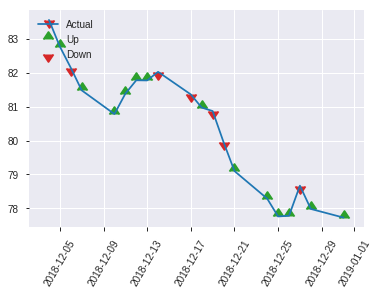


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.15898753556592454
RMSE: 0.3987324109800012
LogLoss: 0.48697913306585755
Mean Per-Class Error: 0.19407471017604117
AUC: 0.8743176102557811
pr_auc: 0.8372150689575886
Gini: 0.7486352205115623
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5301996469497681: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      108  29   0.2117   (29.0/137.0)
1      21   98   0.1765   (21.0/119.0)
Total  129  127  0.1953   (50.0/256.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.5302       0.796748  126
max f2                       0.454983     0.864486  165
max f0point5                 0.662485     0.816092  78
max accuracy                 0.5302       0.804688  126
max precision                0.944947     1         0
max recall                   0.209779     1         221
max specificity              0.944947     1         0
max absolute_mcc             0.5302       0.610355  126
max min_per_class_accuracy   0.55001      0.788321  122
max mean_per_class_accuracy  0.5302       0.805925  126

Gains/Lift Table: Avg response rate: 46.48 %, avg score: 53.04 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0117188                   0.927315           2.15126   2.15126            1                0.934912  1                           0.934912            0.0252101       0.0252101                  115.126    115.126
    2        0.0234375                   0.922423           2.15126   2.15126            1                0.923688  1                           0.9293              0.0252101       0.0504202                  115.126    115.126
    3        0.03125                     0.921485           1.07563   1.88235            0.5              0.92173   0.875                       0.927407            0.00840336      0.0588235                  7.56303    88.2353
    4        0.0429688                   0.919191           2.15126   1.95569            1                0.920558  0.909091                    0.925539            0.0252101       0.0840336                  115.126    95.5691
    5        0.0507812                   0.906585           1.07563   1.8203             0.5              0.91518   0.846154                    0.923946            0.00840336      0.092437                   7.56303    82.0297
    6        0.101562                    0.867286           2.15126   1.98578            1                0.889855  0.923077                    0.9069              0.109244        0.201681                   115.126    98.5779
    7        0.152344                    0.816196           1.98578   1.98578            0.923077         0.851915  0.923077                    0.888572            0.10084         0.302521                   98.5779    98.5779
    8        0.203125                    0.751381           2.15126   2.02715            1                0.779036  0.942308                    0.861188            0.109244        0.411765                   115.126    102.715
    9        0.300781                    0.666377           1.72101   1.92775            0.8              0.70648   0.896104                    0.810958            0.168067        0.579832                   72.1008    92.7753
    10       0.402344                    0.596868           0.992889  1.69177            0.461538         0.630015  0.786408                    0.765283            0.10084         0.680672                   -0.711054  69.1768
    11       0.5                         0.52746            1.46286   1.64706            0.68             0.562437  0.765625                    0.725665            0.142857        0.823529                   46.2857    64.7059
    12       0.601562                    0.485916           0.744667  1.49471            0.346154         0.505446  0.694805                    0.688485            0.0756303       0.89916                    -25.5333   49.4707
    13       0.699219                    0.409786           0.430252  1.34604            0.2              0.449653  0.625698                    0.655129            0.0420168       0.941176                   -56.9748   34.604
    14       0.800781                    0.336433           0.413704  1.22779            0.192308         0.372881  0.570732                    0.619331            0.0420168       0.983193                   -58.6296   22.7793
    15       0.898438                    0.134158           0.172101  1.11304            0.08             0.248204  0.517391                    0.578991            0.0168067       1                          -82.7899   11.3043
    16       1                           0.0740252          0         1                  0                0.100906  0.464844                    0

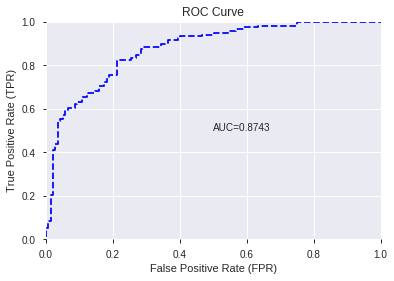

This function is available for GLM models only


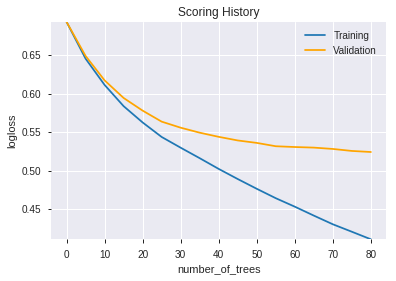

--2019-08-22 10:59:55--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.207.27
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.207.27|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoMode

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190822_105835_model_2',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190822_105835_model_2',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_42_sid_a945',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

In [18]:
# XGBoost
xgb_features = model_train(feature_name='All',model_algo="XGBoost")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190822_110002_model_5  0.842360  0.544397              0.224376  0.428064  0.183239
1  DeepLearning_grid_1_AutoML_20190822_110002_model_8  0.840581  0.560494              0.231123  0.431030  0.185787
2  DeepLearning_grid_1_AutoML_20190822_110002_model_6  0.834202  0.584853              0.225480  0.443844  0.196998
3               DeepLearning_1_AutoML_20190822_110002  0.829909  0.618400              0.234221  0.464851  0.216086
4  DeepLearning_grid_1_AutoML_20190822_110002_model_2  0.827026  0.549537              0.244066  0.431866  0.186508
5  DeepLearning_grid_1_AutoML_20190822_110002_model_9  0.824357  0.545906              0.229130  0.431428  0.186130
6  DeepLearning_grid_1_AutoML_20190822_110002_model_3  0.796479  0.566677              0.299914  0.436670  0.190681
7  DeepLearning_grid_1_AutoML_20190822_110002_model_1  0.789395  0.742650              0.288198  0.466788  0.217891
8  DeepLearning_grid_1_AutoML_20190822_110002_model_7  0.776974  0.618000              0.284641  0.439738  0.193369
9  DeepLearning_grid_1_AutoML_20190822_110002_model_4  0.735447  0.676429              0.380329  0.476402  0.226959

variable  relative_importance  scaled_importance  percentage
0    CDLGRAVESTONEDOJI             1.000000           1.000000    0.031171
1               ULTOSC             0.933773           0.933773    0.029106
2         STOCHF_fastk             0.925417           0.925417    0.028846
3     CDLDRAGONFLYDOJI             0.878203           0.878203    0.027374
4            CDLTAKURI             0.822048           0.822048    0.025624
5                  SIN             0.812958           0.812958    0.025341
6                CCI_8             0.798253           0.798253    0.024882
7         aroondown_14             0.788062           0.788062    0.024565
8              WILLR_8             0.759583           0.759583    0.023677
9         weekday_name             0.711578           0.711578    0.022180
10              SAREXT             0.701926           0.701926    0.021880
11         CDLBELTHOLD             0.693909           0.693909    0.021630
12        HT_TRENDMODE             0.689354           0.689354    0.021488
13  CDLCLOSINGMARUBOZU             0.672457           0.672457    0.020961
14                COSH             0.658295           0.658295    0.020520
15                SINH             0.651715           0.651715    0.020314
16           CORREL_12             0.649204           0.649204    0.020236
17           PLUS_DI_8             0.642111           0.642111    0.020015
18          PLUS_DI_12             0.641804           0.641804    0.020006
19           CORREL_14             0.641113           0.641113    0.019984
20              CCI_12             0.636627           0.636627    0.019844
21                 EXP             0.636188           0.636188    0.019830
22              TRANGE             0.614791           0.614791    0.019164
23   CDLINVERTEDHAMMER             0.609317           0.609317    0.018993
24      is_quarter_end             0.603858           0.603858    0.018823
25      CDLMORNINGSTAR             0.600025           0.600025    0.018703
26  CDLSEPARATINGLINES             0.599448           0.599448    0.018685
27     CDLADVANCEBLOCK             0.596972           0.596972    0.018608
28        CDLTHRUSTING             0.595045           0.595045    0.018548
29  CDLMORNINGDOJISTAR             0.591517           0.591517    0.018438
30    CDLABANDONEDBABY             0.588429           0.588429    0.018342
31        is_month_end             0.579862           0.579862    0.018075
32         CDLMARUBOZU             0.575688           0.575688    0.017945
33     CDLLADDERBOTTOM             0.572018           0.572018    0.017830
34           CDLHAMMER             0.571438           0.571438    0.017812
35           CDLINNECK             0.568981           0.568981    0.017736
36     CDLSHOOTINGSTAR             0.565057           0.565057    0.017613
37      CDLEVENINGSTAR             0.558187           0.558187    0.017399
38   CDLDARKCLOUDCOVER             0.554617           0.554617    0.017288
39    is_quarter_start             0.549599           0.549599    0.017131
40     CDLUNIQUE3RIVER             0.545720           0.545720    0.017011
41       CDLHIKKAKEMOD             0.545340           0.545340    0.016999
42  CDLEVENINGDOJISTAR             0.538647           0.538647    0.016790
43      is_month_start             0.538387           0.538387    0.016782
44           CDLONNECK             0.537546           0.537546    0.016756
45     CDLHOMINGPIGEON             0.525434           0.525434    0.016378
46    CDLCOUNTERATTACK             0.520682           0.520682    0.016230
47          CDL3INSIDE             0.517656           0.517656    0.016136
48      CDLMATCHINGLOW             0.489856           0.489856    0.015269
49       CDLHANGINGMAN             0.482648           0.482648    0.015044

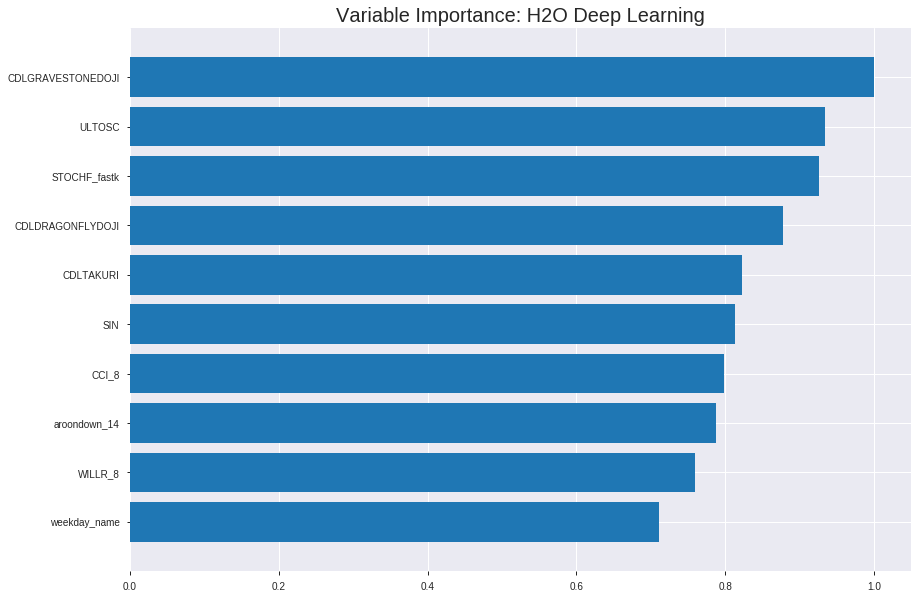

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190822_110002_model_5


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.18337773239139676
RMSE: 0.42822626307992456
LogLoss: 0.5373073605641066
Mean Per-Class Error: 0.28234470605634476
AUC: 0.8023353311425112
pr_auc: 0.8137544660228545
Gini: 0.6046706622850224
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4772952754089063: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      377  470   0.5549   (470.0/847.0)
1      68   874   0.0722   (68.0/942.0)
Total  445  1344  0.3007   (538.0/1789.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.477295     0.764654  256
max f2                       0.180175     0.870577  346
max f0point5                 0.58499      0.739653  177
max accuracy                 0.53149      0.720514  217
max precision                0.996934     1         0
max recall                   0.0947285    1         376
max specificity              0.996934     1         0
max absolute_mcc             0.53149      0.439093  217
max min_per_class_accuracy   0.554443     0.712314  200
max mean_per_class_accuracy  0.548248     0.717655  205

Gains/Lift Table: Avg response rate: 52.66 %, avg score: 55.64 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100615                   0.98421            1.89915    1.89915            1                0.991739   1                           0.991739            0.0191083       0.0191083                  89.9151   89.9151
    2        0.020123                    0.978867           1.89915    1.89915            1                0.981641   1                           0.98669             0.0191083       0.0382166                  89.9151   89.9151
    3        0.0301845                   0.970265           1.89915    1.89915            1                0.974645   1                           0.982675            0.0191083       0.0573248                  89.9151   89.9151
    4        0.0402459                   0.957518           1.89915    1.89915            1                0.96491    1                           0.978234            0.0191083       0.0764331                  89.9151   89.9151
    5        0.0503074                   0.948711           1.58263    1.83585            0.833333         0.952876   0.966667                    0.973162            0.0159236       0.0923567                  58.2626   83.5846
    6        0.100056                    0.905434           1.74978    1.79305            0.921348         0.928827   0.944134                    0.951119            0.0870488       0.179406                   74.9779   79.3053
    7        0.150363                    0.806644           1.62483    1.73677            0.855556         0.858829   0.914498                    0.920241            0.081741        0.261146                   62.4829   73.677
    8        0.200112                    0.721332           1.49371    1.67635            0.786517         0.75945    0.882682                    0.880268            0.07431         0.335456                   49.3714   67.6345
    9        0.300168                    0.64096            1.37927    1.57732            0.726257         0.679836   0.83054                     0.813457            0.138004        0.473461                   37.9271   57.7321
    10       0.400224                    0.589577           1.20951    1.48537            0.636872         0.613366   0.782123                    0.763434            0.121019        0.59448                    20.9515   48.5369
    11       0.500279                    0.556649           1.07159    1.40261            0.564246         0.571821   0.738547                    0.725112            0.107219        0.701699                   7.15878   40.2613
    12       0.599776                    0.527912           1.00292    1.33631            0.52809          0.542322   0.703635                    0.694789            0.0997877       0.801486                   0.29223   33.6308
    13       0.699832                    0.501395           0.859392   1.26812            0.452514         0.515932   0.667732                    0.669217            0.0859873       0.887473                   -14.0608  26.8123
    14       0.799888                    0.429961           0.657806   1.19178            0.346369         0.472622   0.627533                    0.644626            0.0658174       0.953291                   -34.2194  19.178
    15       0.899944                    0.17014            0.392562   1.10292            0.206704         0.311382   0.580745                    0.607576            0.0392781       0.992569                   -60.7438  10.2923
    16       1                           0.0106877          0.0742685  1                  0.0391061        0.0961256  0.526551   



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.1835548009667666
RMSE: 0.42843295971104584
LogLoss: 0.5391861773112939
Mean Per-Class Error: 0.2711890573378207
AUC: 0.8037098218420972
pr_auc: 0.8283274082074441
Gini: 0.6074196436841943
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5116950326309915: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      112  121  0.5193   (121.0/233.0)
1      27   251  0.0971   (27.0/278.0)
Total  139  372  0.2896   (148.0/511.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.511695     0.772308  275
max f2                       0.204044     0.874682  350
max f0point5                 0.701613     0.763403  117
max accuracy                 0.583897     0.727984  199
max precision                0.996948     1         0
max recall                   0.0826648    1         388
max specificity              0.996948     1         0
max absolute_mcc             0.583897     0.45595   199
max min_per_class_accuracy   0.583389     0.723022  200
max mean_per_class_accuracy  0.583897     0.728811  199

Gains/Lift Table: Avg response rate: 54.40 %, avg score: 59.18 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117417                   0.991173           1.83813   1.83813            1                0.994293  1                           0.994293            0.0215827       0.0215827                  83.8129   83.8129
    2        0.0215264                   0.981035           1.83813   1.83813            1                0.98338   1                           0.989332            0.0179856       0.0395683                  83.8129   83.8129
    3        0.0313112                   0.977601           1.4705    1.72325            0.8              0.979403  0.9375                      0.986229            0.0143885       0.0539568                  47.0504   72.3246
    4        0.0410959                   0.974077           1.83813   1.7506             1                0.974944  0.952381                    0.983542            0.0179856       0.0719424                  83.8129   75.06
    5        0.0508806                   0.971105           1.83813   1.76743            1                0.972605  0.961538                    0.981439            0.0179856       0.0899281                  83.8129   76.7432
    6        0.101761                    0.935338           1.69673   1.73208            0.923077         0.953601  0.942308                    0.96752             0.0863309       0.176259                   69.6735   73.2084
    7        0.150685                    0.901037           1.7646    1.74264            0.96             0.921487  0.948052                    0.952574            0.0863309       0.26259                    76.4604   74.2642
    8        0.201566                    0.844624           1.48464   1.67752            0.807692         0.876744  0.912621                    0.933433            0.0755396       0.338129                   48.4643   67.7516
    9        0.30137                     0.682868           1.44167   1.59941            0.784314         0.743262  0.87013                     0.870454            0.143885        0.482014                   44.167    59.9411
    10       0.401174                    0.622103           1.00917   1.45257            0.54902          0.649351  0.790244                    0.815448            0.100719        0.582734                   0.916914  45.2571
    11       0.500978                    0.589128           1.22542   1.40732            0.666667         0.6034    0.765625                    0.773204            0.122302        0.705036                   22.542    40.7318
    12       0.600783                    0.55453            0.901044  1.32321            0.490196         0.571556  0.71987                     0.739705            0.0899281       0.794964                   -9.89561  32.3214
    13       0.700587                    0.525318           0.865002  1.25794            0.470588         0.538861  0.684358                    0.711094            0.0863309       0.881295                   -13.4998  25.7938
    14       0.800391                    0.463942           0.61271   1.17748            0.333333         0.500857  0.640587                    0.684878            0.0611511       0.942446                   -38.729   17.7481
    15       0.900196                    0.204044           0.468543  1.09888            0.254902         0.319884  0.597826                    0.644412            0.0467626       0.989209                   -53.1457  9.88818
    16       1                           0.0126718          0.108125  1                  0.0588235        0.117576  0.544031                    0.591831           


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-22 11:03:31  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-22 11:03:33  1 min 42.907 sec  1093 obs/sec      1         1             1789       0.502604         0.71683             -0.0133004     0.723997        0.745536           1.89915          0.375629                         0.496645           0.697255              0.00566316       0.778769          0.810619             1.83813            0.309198
    2019-08-22 11:03:39  1 min 49.231 sec  1943 obs/sec      8         8             14312      0.428226         0.537307            0.264415       0.802335        0.813754           1.89915          0.300727                         0.428433           0.539186              0.260042         0.80371           0.828327             1.83813            0.289628
    2019-08-22 11:03:45  1 min 55.717 sec  2286 obs/sec      17        17            30413      0.427836         0.536247            0.265754       0.808846        0.822491           1.89915          0.27725                          0.439603           0.570789              0.220955         0.791745          0.816854             1.83813            0.307241
    2019-08-22 11:03:51  2 min  1.216 sec  2451 obs/sec      25        25            44725      0.418654         0.513557            0.296933       0.822157        0.839188           1.89915          0.276132                         0.440999           0.580185              0.215999         0.789113          0.793524             1.83813            0.2818
    2019-08-22 11:03:57  2 min  7.153 sec  2573 obs/sec      34        34            60826      0.404219         0.48244             0.344581       0.8407          0.85044            1.89915          0.270542                         0.440704           0.585556              0.217047         0.786759          0.807142             1.83813            0.285714
    2019-08-22 11:04:03  2 min 12.953 sec  2665 obs/sec      43        43            76927      0.395542         0.462307            0.372417       0.84986         0.866155           1.89915          0.27166                          0.438243           0.596262              0.225767         0.788256          0.797151             1.83813            0.283757
    2019-08-22 11:04:09  2 min 19.162 sec  2746 obs/sec      53        53            94817      0.384666         0.44082             0.406453       0.871275        0.882879           1.89915          0.243712                         0.443491           0.617659              0.207113         0.787646          0.803242             1.53177            0.273973
    2019-08-22 11:04:09  2 min 19.733 sec  2745 obs/sec      53        53            94817      0.428226         0.537307            0.264415       0.802335        0.813754           1.89915          0.300727                         0.428433           0.539186              0.260042         0.80371           0.828327             1.83813            0.289628

Variable Importances: 


variable           relative_importance    scaled_importance    percentage
-----------------  ---------------------  -------------------  --------------------
CDLGRAVESTONEDOJI  1.0                    1.0                  0.031170765328779198
ULTOSC             0.9337731003761292     0.9337731003761292   0.029106422182150902
STOCHF_fastk       0.9254165887832642     0.9254165887832642   0.028845943320322486
CDLDRAGONFLYDOJI   0.8782025575637817     0.8782025575637817   0.027374245832954343
CDLTAKURI          0.8220482468605042     0.8220482468605042   0.025623872991823126
---                ---                    ---                  ---
CDLHOMINGPIGEON    0.5254342555999756     0.5254342555999756   0.016378187877008624
CDLCOUNTERATTACK   0.520682156085968      0.520682156085968    0.01623006129823849
CDL3INSIDE         0.5176560282707214     0.5176560282707214   0.016135734578254547
CDLMATCHINGLOW     0.4898555874824524     0.4898555874824524   0.015269173562406792
CDLHANGINGMAN      0.48264768719673157    0.48264768719673157  0.015044497794087347


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.77734375)

('F1', 0.768)

('auc', 0.8423603017849476)

('logloss', 0.5443972643004591)

('mean_per_class_error', 0.22437588173955714)

('rmse', 0.4280637743436649)

('mse', 0.18323859490534405)

deeplearning prediction progress: |███████████████████████████████████████| 100%


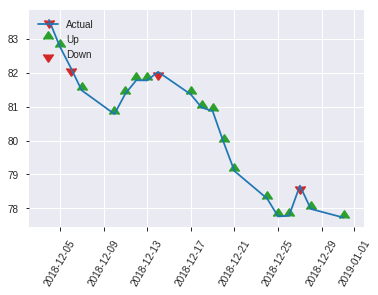


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.18323859490534405
RMSE: 0.4280637743436649
LogLoss: 0.5443972643004591
Mean Per-Class Error: 0.22437588173955714
AUC: 0.8423603017849476
pr_auc: 0.8079176406235974
Gini: 0.6847206035698952
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5610896156673771: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      102  35   0.2555   (35.0/137.0)
1      23   96   0.1933   (23.0/119.0)
Total  125  131  0.2266   (58.0/256.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.56109      0.768     130
max f2                       0.160905     0.842776  229
max f0point5                 0.618702     0.796178  87
max accuracy                 0.618702     0.777344  87
max precision                0.996121     1         0
max recall                   0.160905     1         229
max specificity              0.996121     1         0
max absolute_mcc             0.618702     0.562192  87
max min_per_class_accuracy   0.567709     0.759124  123
max mean_per_class_accuracy  0.56109      0.775624  130

Gains/Lift Table: Avg response rate: 46.48 %, avg score: 56.70 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117188                   0.992774           2.15126   2.15126            1                0.994668   1                           0.994668            0.0252101       0.0252101                  115.126   115.126
    2        0.0234375                   0.984389           1.43417   1.79272            0.666667         0.988647   0.833333                    0.991658            0.0168067       0.0420168                  43.4174   79.2717
    3        0.03125                     0.975524           1.07563   1.61345            0.5              0.977059   0.75                        0.988008            0.00840336      0.0504202                  7.56303   61.3445
    4        0.0429688                   0.963314           2.15126   1.76012            1                0.970785   0.818182                    0.983311            0.0252101       0.0756303                  115.126   76.0122
    5        0.0507812                   0.958449           2.15126   1.8203             1                0.961952   0.846154                    0.980025            0.0168067       0.092437                   115.126   82.0297
    6        0.101562                    0.925061           2.15126   1.98578            1                0.945189   0.923077                    0.962607            0.109244        0.201681                   115.126   98.5779
    7        0.152344                    0.86964            1.8203    1.93062            0.846154         0.902869   0.897436                    0.942694            0.092437        0.294118                   82.0297   93.0618
    8        0.203125                    0.714143           1.98578   1.94441            0.923077         0.812642   0.903846                    0.910181            0.10084         0.394958                   98.5779   94.4409
    9        0.300781                    0.646065           1.63496   1.84394            0.76             0.67891    0.857143                    0.835093            0.159664        0.554622                   63.4958   84.3938
    10       0.402344                    0.595579           1.15837   1.67088            0.538462         0.616227   0.776699                    0.779846            0.117647        0.672269                   15.8371   67.0882
    11       0.5                         0.562738           1.11866   1.56303            0.52             0.579742   0.726562                    0.740763            0.109244        0.781513                   11.8655   56.3025
    12       0.601562                    0.540486           0.579186  1.39692            0.269231         0.549826   0.649351                    0.708527            0.0588235       0.840336                   -42.0814  39.6922
    13       0.699219                    0.512088           0.774454  1.30999            0.36             0.531175   0.608939                    0.683757            0.0756303       0.915966                   -22.5546  30.9985
    14       0.800781                    0.45711            0.413704  1.19631            0.192308         0.490267   0.556098                    0.659217            0.0420168       0.957983                   -58.6296  19.6311
    15       0.898438                    0.158673           0.430252  1.11304            0.2              0.297768   0.517391                    0.619929            0.0420168       1                          -56.9748  11.3043
    16       1                           0.0364151          0         1                  0                0.0983576  0.464844                   

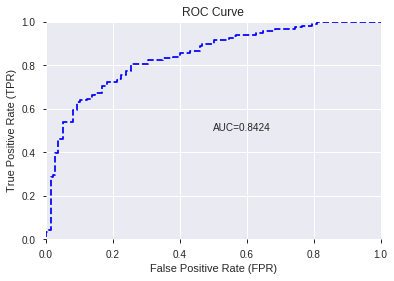

This function is available for GLM models only


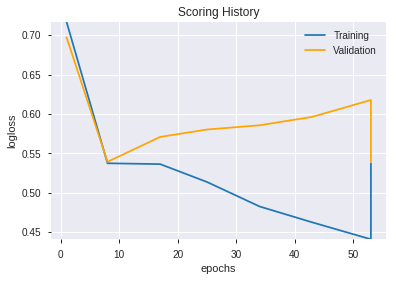

--2019-08-22 11:08:40--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.64.128
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.64.128|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190822_110002_model_5',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190822_110002_model_5',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_50_sid_a945',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['CDLGRAVESTONEDOJI',
 'ULTOSC',
 'STOCHF_fastk',
 'CDLDRAGONFLYDOJI',
 'CDLTAKURI',
 'SIN',
 'CCI_8',
 'aroondown_14',
 'WILLR_8',
 'weekday_name',
 'SAREXT',
 'CDLBELTHOLD',
 'HT_TRENDMODE',
 'CDLCLOSINGMARUBOZU',
 'COSH',
 'SINH',
 'CORREL_12',
 'PLUS_DI_8',
 'PLUS_DI_12',
 'CORREL_14',
 'CCI_12',
 'EXP',
 'TRANGE',
 'CDLINVERTEDHAMMER',
 'is_quarter_end',
 'CDLMORNINGSTAR',
 'CDLSEPARATINGLINES',
 'CDLADVANCEBLOCK',
 'CDLTHRUSTING',
 'CDLMORNINGDOJISTAR',
 'CDLABANDONEDBABY',
 'is_month_end',
 'CDLMARUBOZU',
 'CDLLADDERBOTTOM',
 'CDLHAMMER',
 'CDLINNECK',
 'CDLSHOOTINGSTAR',
 'CDLEVENINGSTAR',
 'CDLDARKCLOUDCOVER',
 'is_quarter_start',
 'CDLUNIQUE3RIVER',
 'CDLHIKKAKEMOD',
 'CDLEVENINGDOJISTAR',
 'is_month_start',
 'CDLONNECK',
 'CDLHOMINGPIGEON',
 'CDLCOUNTERATTACK',
 'CDL3INSIDE',
 'CDLMATCHINGLOW',
 'CDLHANGINGMAN']

In [19]:
# DeepLearning with top XGBoost features
model_train(feature_name='XGBF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190822_110847_model_1  0.861375  0.488553              0.213427  0.403009  0.162416

variable  relative_importance  scaled_importance  percentage
0                CCI_8             1.073727           1.000000    0.123066
1    CDLGRAVESTONEDOJI             0.881767           0.821220    0.101064
2            PLUS_DI_8             0.870758           0.810967    0.099803
3              WILLR_8             0.634038           0.590502    0.072671
4            CDLTAKURI             0.632336           0.588917    0.072476
5           PLUS_DI_12             0.629965           0.586709    0.072204
6         STOCHF_fastk             0.625506           0.582556    0.071693
7      CDLSHOOTINGSTAR             0.271710           0.253053    0.031142
8    CDLINVERTEDHAMMER             0.258510           0.240759    0.029629
9        CDLHANGINGMAN             0.188523           0.175578    0.021608
10    CDLDRAGONFLYDOJI             0.186421           0.173620    0.021367
11     CDLLADDERBOTTOM             0.186375           0.173578    0.021362
12           CDLINNECK             0.182345           0.169824    0.020900
13        aroondown_14             0.164406           0.153117    0.018844
14     CDLUNIQUE3RIVER             0.156570           0.145819    0.017945
15  CDLCLOSINGMARUBOZU             0.141340           0.131635    0.016200
16     CDLHOMINGPIGEON             0.134003           0.124801    0.015359
17                 SIN             0.111654           0.103987    0.012797
18     CDLADVANCEBLOCK             0.103468           0.096363    0.011859
19       CDLHIKKAKEMOD             0.097316           0.090634    0.011154
20      CDLMORNINGSTAR             0.093940           0.087489    0.010767
21           CDLHAMMER             0.075219           0.070054    0.008621
22              ULTOSC             0.072492           0.067514    0.008309
23          CDL3INSIDE             0.072397           0.067426    0.008298
24  CDLEVENINGDOJISTAR             0.071899           0.066962    0.008241
25           CORREL_14             0.065257           0.060777    0.007480
26    CDLCOUNTERATTACK             0.061522           0.057298    0.007051
27         CDLBELTHOLD             0.059610           0.055517    0.006832
28              TRANGE             0.057683           0.053722    0.006611
29  CDLMORNINGDOJISTAR             0.051332           0.047807    0.005883
30  CDLSEPARATINGLINES             0.047168           0.043929    0.005406
31           CORREL_12             0.045980           0.042823    0.005270
32           CDLONNECK             0.045358           0.042244    0.005199
33        is_month_end             0.044481           0.041426    0.005098
34              SAREXT             0.044467           0.041414    0.005097
35   CDLDARKCLOUDCOVER             0.042540           0.039619    0.004876
36    CDLABANDONEDBABY             0.039156           0.036467    0.004488
37      is_month_start             0.039049           0.036368    0.004476
38      is_quarter_end             0.038621           0.035969    0.004427
39              CCI_12             0.027741           0.025836    0.003180
40    is_quarter_start             0.022393           0.020856    0.002567
41         CDLMARUBOZU             0.021423           0.019952    0.002455
42        CDLTHRUSTING             0.016226           0.015112    0.001860
43      CDLEVENINGSTAR             0.009731           0.009063    0.001115
44                COSH             0.007756           0.007224    0.000889
45                 EXP             0.005602           0.005217    0.000642
46                SINH             0.004898           0.004562    0.000561
47        weekday_name             0.004067           0.003787    0.000466
48      CDLMATCHINGLOW             0.004053           0.003775    0.000465
49        HT_TRENDMODE             0.002001           0.001864    0.000229

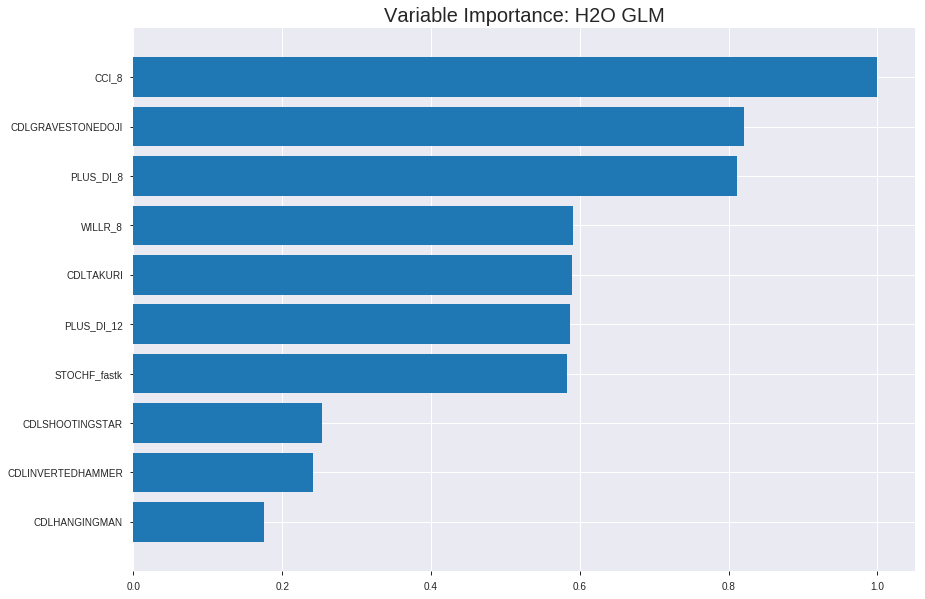

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190822_110847_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.18066399395274235
RMSE: 0.42504587276286115
LogLoss: 0.5333750483847717
Null degrees of freedom: 1788
Residual degrees of freedom: 1738
Null deviance: 2475.0335207517455
Residual deviance: 1908.4159231207132
AIC: 2010.4159231207132
AUC: 0.8006571212998543
pr_auc: 0.8136845394281887
Gini: 0.6013142425997087
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3655209762131081: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      389  458   0.5407   (458.0/847.0)
1      67   875   0.0711   (67.0/942.0)
Total  456  1333  0.2935   (525.0/1789.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.365521     0.769231  272
max f2                       0.24878      0.868161  314
max f0point5                 0.596889     0.747068  165
max accuracy                 0.462422     0.715484  230
max precision                0.9996       1         0
max recall                   0.0348466    1         388
max specificity              0.9996       1         0
max absolute_mcc             0.365521     0.444694  272
max min_per_class_accuracy   0.538499     0.707202  193
max mean_per_class_accuracy  0.587409     0.717294  168

Gains/Lift Table: Avg response rate: 52.66 %, avg score: 52.66 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100615                   0.985275           1.89915   1.89915            1                0.991256   1                           0.991256            0.0191083       0.0191083                  89.9151   89.9151
    2        0.020123                    0.978868           1.89915   1.89915            1                0.981569   1                           0.986412            0.0191083       0.0382166                  89.9151   89.9151
    3        0.0301845                   0.973887           1.89915   1.89915            1                0.976823   1                           0.983216            0.0191083       0.0573248                  89.9151   89.9151
    4        0.0402459                   0.960714           1.79364   1.87277            0.944444         0.96832    0.986111                    0.979492            0.0180467       0.0753715                  79.3642   87.2774
    5        0.0503074                   0.954339           1.89915   1.87805            1                0.957865   0.988889                    0.975167            0.0191083       0.0944798                  89.9151   87.8049
    6        0.100056                    0.893538           1.7071    1.79305            0.898876         0.92546    0.944134                    0.950452            0.0849257       0.179406                   70.7102   79.3053
    7        0.150363                    0.820604           1.51932   1.70147            0.8              0.857696   0.895911                    0.919418            0.0764331       0.255839                   51.9321   70.147
    8        0.200112                    0.748619           1.64309   1.68696            0.865169         0.780724   0.888268                    0.884939            0.081741        0.33758                    64.3085   68.6955
    9        0.300168                    0.667235           1.33683   1.57025            0.703911         0.704647   0.826816                    0.824841            0.133758        0.471338                   33.6832   57.0248
    10       0.400224                    0.605685           1.28378   1.49863            0.675978         0.636234   0.789106                    0.77769             0.12845         0.599788                   28.3783   49.8632
    11       0.500279                    0.544818           1.00793   1.40049            0.530726         0.573878   0.73743                     0.736927            0.100849        0.700637                   0.792917  40.0491
    12       0.599776                    0.481588           0.928237  1.32215            0.488764         0.512772   0.696179                    0.699742            0.0923567       0.792994                   -7.17634  32.2149
    13       0.699832                    0.40992            0.95488   1.26964            0.502793         0.446678   0.66853                     0.663561            0.0955414       0.888535                   -4.51197  26.964
    14       0.799888                    0.295253           0.657806  1.19311            0.346369         0.357602   0.628232                    0.62529             0.0658174       0.954352                   -34.2194  19.3107
    15       0.899944                    0.114371           0.297074  1.09349            0.156425         0.204467   0.575776                    0.578502            0.029724        0.984076                   -70.2926  9.34862
    16       1                           0.000332271        0.159147  1                  0.0837989        0.0592801  0.526551                    0



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.17045560240226965
RMSE: 0.4128626919476615
LogLoss: 0.5090250634399037
Null degrees of freedom: 510
Residual degrees of freedom: 460
Null deviance: 705.0556929735951
Residual deviance: 520.2236148355817
AIC: 622.2236148355817
AUC: 0.8302559669002996
pr_auc: 0.8548870548518144
Gini: 0.6605119338005991
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5227201169133081: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      147  86   0.3691   (86.0/233.0)
1      41   237  0.1475   (41.0/278.0)
Total  188  323  0.2485   (127.0/511.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.52272      0.788686  242
max f2                       0.129489     0.879365  358
max f0point5                 0.662832     0.796089  151
max accuracy                 0.52272      0.751468  242
max precision                0.996727     1         0
max recall                   0.00878674   1         398
max specificity              0.996727     1         0
max absolute_mcc             0.645975     0.509133  161
max min_per_class_accuracy   0.582654     0.746781  202
max mean_per_class_accuracy  0.634735     0.751536  168

Gains/Lift Table: Avg response rate: 54.40 %, avg score: 57.94 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117417                   0.986712           1.83813   1.83813            1                0.989739   1                           0.989739            0.0215827       0.0215827                  83.8129   83.8129
    2        0.0215264                   0.982971           1.83813   1.83813            1                0.985089   1                           0.987625            0.0179856       0.0395683                  83.8129   83.8129
    3        0.0313112                   0.980361           1.83813   1.83813            1                0.981877   1                           0.985829            0.0179856       0.057554                   83.8129   83.8129
    4        0.0410959                   0.975983           1.83813   1.83813            1                0.976963   1                           0.983718            0.0179856       0.0755396                  83.8129   83.8129
    5        0.0508806                   0.971844           1.83813   1.83813            1                0.973935   1                           0.981837            0.0179856       0.0935252                  83.8129   83.8129
    6        0.101761                    0.943943           1.76743   1.80278            0.961538         0.957287   0.980769                    0.969562            0.0899281       0.183453                   76.7432   80.2781
    7        0.150685                    0.915895           1.61755   1.74264            0.88             0.931236   0.948052                    0.957119            0.0791367       0.26259                    61.7554   74.2642
    8        0.201566                    0.863618           1.55534   1.69536            0.846154         0.896611   0.92233                     0.941845            0.0791367       0.341727                   55.534    69.5362
    9        0.30137                     0.744373           1.51375   1.63522            0.823529         0.795579   0.88961                     0.893406            0.151079        0.492806                   51.3754   63.5219
    10       0.401174                    0.654979           1.33354   1.56017            0.72549          0.696687   0.84878                     0.844466            0.133094        0.625899                   33.3545   56.0168
    11       0.500978                    0.590426           0.973127  1.44322            0.529412         0.622285   0.785156                    0.800204            0.0971223       0.723022                   -2.68726  44.3219
    12       0.600783                    0.545034           0.865002  1.34716            0.470588         0.569006   0.732899                    0.761796            0.0863309       0.809353                   -13.4998  34.7163
    13       0.700587                    0.468936           0.720835  1.25794            0.392157         0.509709   0.684358                    0.725884            0.0719424       0.881295                   -27.9165  25.7938
    14       0.800391                    0.328778           0.720835  1.19096            0.392157         0.417984   0.647922                    0.687491            0.0719424       0.953237                   -27.9165  19.0964
    15       0.900196                    0.133674           0.360418  1.09888            0.196078         0.221873   0.597826                    0.635868            0.0359712       0.989209                   -63.9582  9.88818
    16       1                           0.0059284          0.108125  1                  0.0588235        0.0695921  0.544031                   


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train      deviance_test
---  -------------------  ----------  -----------  --------  ------------  ------------------  ------------------
     2019-08-22 11:08:48  0.000 sec   2            .17E2     51            1.3671344216744614  1.360956737111869
     2019-08-22 11:08:48  0.015 sec   4            .11E2     51            1.3580705367656893  1.3505395077142313
     2019-08-22 11:08:48  0.029 sec   6            .66E1     51            1.344726680061182   1.3352200276290156
     2019-08-22 11:08:48  0.044 sec   8            .41E1     51            1.325989429946351   1.3137564226405933
     2019-08-22 11:08:48  0.061 sec   10           .25E1     51            1.3013331729929731  1.2856103128408096
---  ---                  ---         ---          ---       ---           ---                 ---
     2019-08-22 11:08:48  0.314 sec   45           .3E-3     51            1.0668177086976482  1.0190331941210125
     2019-08-22 11:08:48  0.324 sec   46           .19E-3    51            1.0667792623127426  1.018608194576711
     2019-08-22 11:08:48  0.333 sec   47           .11E-3    51            1.0667617980638278  1.0183348331185313
     2019-08-22 11:08:48  0.343 sec   48           .71E-4    51            1.0667538976501603  1.0181663487633121
     2019-08-22 11:08:48  0.352 sec   49           .44E-4    51            1.0667500967695436  1.0180501268798074


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.79296875)

('F1', 0.7773279352226722)

('auc', 0.8613752070171133)

('logloss', 0.48855328466762094)

('mean_per_class_error', 0.21109611727902844)

('rmse', 0.40300883828951917)

('mse', 0.1624161237394678)

glm prediction progress: |████████████████████████████████████████████████| 100%


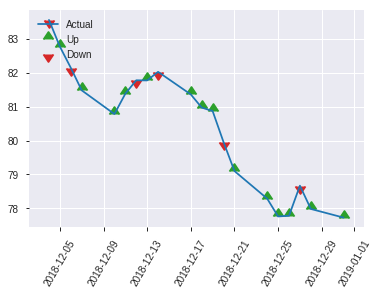


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.1624161237394678
RMSE: 0.40300883828951917
LogLoss: 0.48855328466762094
Null degrees of freedom: 255
Residual degrees of freedom: 205
Null deviance: 357.52774107262724
Residual deviance: 250.13928174982192
AIC: 352.1392817498219
AUC: 0.8613752070171133
pr_auc: 0.8349143809470967
Gini: 0.7227504140342267
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5599098783917322: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      105  32   0.2336   (32.0/137.0)
1      23   96   0.1933   (23.0/119.0)
Total  128  128  0.2148   (55.0/256.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.55991      0.777328  127
max f2                       0.281557     0.85044   205
max f0point5                 0.672452     0.819672  76
max accuracy                 0.62179      0.792969  101
max precision                0.991744     1         0
max recall                   0.128304     1         225
max specificity              0.991744     1         0
max absolute_mcc             0.62179      0.585275  101
max min_per_class_accuracy   0.56496      0.781022  122
max mean_per_class_accuracy  0.604149     0.788904  107

Gains/Lift Table: Avg response rate: 46.48 %, avg score: 53.15 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117188                   0.983498           2.15126   2.15126            1                0.988374   1                           0.988374            0.0252101       0.0252101                  115.126   115.126
    2        0.0234375                   0.978963           1.43417   1.79272            0.666667         0.980139   0.833333                    0.984257            0.0168067       0.0420168                  43.4174   79.2717
    3        0.03125                     0.97704            2.15126   1.88235            1                0.977989   0.875                       0.98269             0.0168067       0.0588235                  115.126   88.2353
    4        0.0429688                   0.972861           2.15126   1.95569            1                0.97569    0.909091                    0.980781            0.0252101       0.0840336                  115.126   95.5691
    5        0.0507812                   0.966546           2.15126   1.98578            1                0.967593   0.923077                    0.978752            0.0168067       0.10084                    115.126   98.5779
    6        0.101562                    0.933686           2.15126   2.06852            1                0.948262   0.961538                    0.963507            0.109244        0.210084                   115.126   106.852
    7        0.152344                    0.854027           1.98578   2.04094            0.923077         0.897852   0.948718                    0.941622            0.10084         0.310924                   98.5779   104.094
    8        0.203125                    0.760667           1.98578   2.02715            0.923077         0.794509   0.942308                    0.904844            0.10084         0.411765                   98.5779   102.715
    9        0.300781                    0.672053           1.80706   1.95569            0.84             0.712425   0.909091                    0.84237             0.176471        0.588235                   80.7059   95.5691
    10       0.402344                    0.61399            1.15837   1.75443            0.538462         0.642447   0.815534                    0.791904            0.117647        0.705882                   15.8371   75.4426
    11       0.5                         0.557862           1.03261   1.61345            0.48             0.584928   0.75                        0.751479            0.10084         0.806723                   3.2605    61.3445
    12       0.601562                    0.490979           0.744667  1.46677            0.346154         0.518546   0.681818                    0.712153            0.0756303       0.882353                   -25.5333  46.6769
    13       0.699219                    0.390024           0.344202  1.30999            0.16             0.446746   0.608939                    0.675085            0.0336134       0.915966                   -65.5798  30.9985
    14       0.800781                    0.285015           0.496445  1.2068             0.230769         0.348888   0.560976                    0.633713            0.0504202       0.966387                   -50.3555  20.6805
    15       0.898438                    0.114551           0.344202  1.11304            0.16             0.194301   0.517391                    0.585951            0.0336134       1                          -65.5798  11.3043
    16       1                           9.47134e-05        0         1                  0                0.0497868  0.464844                   

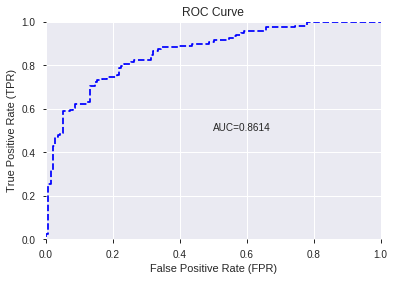

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


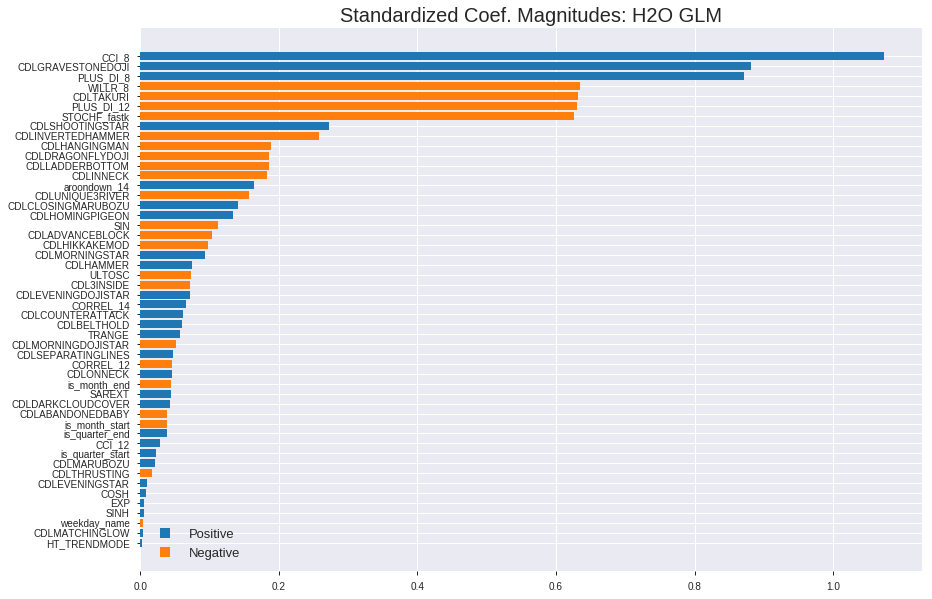

'log_likelihood'
--2019-08-22 11:08:53--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.112.211
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.112.211|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190822_110847_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190822_110847_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_58_sid_a945',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_58_s

['CCI_8',
 'CDLGRAVESTONEDOJI',
 'PLUS_DI_8',
 'WILLR_8',
 'CDLTAKURI',
 'PLUS_DI_12',
 'STOCHF_fastk',
 'CDLSHOOTINGSTAR',
 'CDLINVERTEDHAMMER',
 'CDLHANGINGMAN',
 'CDLDRAGONFLYDOJI',
 'CDLLADDERBOTTOM',
 'CDLINNECK',
 'aroondown_14',
 'CDLUNIQUE3RIVER',
 'CDLCLOSINGMARUBOZU',
 'CDLHOMINGPIGEON',
 'SIN',
 'CDLADVANCEBLOCK',
 'CDLHIKKAKEMOD',
 'CDLMORNINGSTAR',
 'CDLHAMMER',
 'ULTOSC',
 'CDL3INSIDE',
 'CDLEVENINGDOJISTAR',
 'CORREL_14',
 'CDLCOUNTERATTACK',
 'CDLBELTHOLD',
 'TRANGE',
 'CDLMORNINGDOJISTAR',
 'CDLSEPARATINGLINES',
 'CORREL_12',
 'CDLONNECK',
 'is_month_end',
 'SAREXT',
 'CDLDARKCLOUDCOVER',
 'CDLABANDONEDBABY',
 'is_month_start',
 'is_quarter_end',
 'CCI_12',
 'is_quarter_start',
 'CDLMARUBOZU',
 'CDLTHRUSTING',
 'CDLEVENINGSTAR',
 'COSH',
 'EXP',
 'SINH',
 'weekday_name',
 'CDLMATCHINGLOW',
 'HT_TRENDMODE']

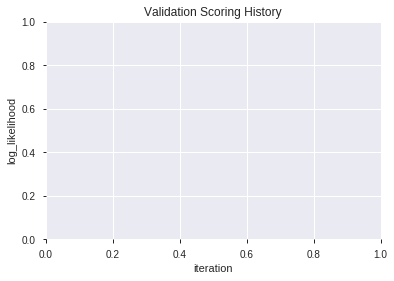

In [20]:
# GLM with top XGBoost features
model_train(feature_name='XGBF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190822_110901_model_4  0.861559  0.503441              0.209225  0.407186  0.165800
1  XGBoost_grid_1_AutoML_20190822_110901_model_2  0.859596  0.501479              0.204134  0.406947  0.165606
2  XGBoost_grid_1_AutoML_20190822_110901_model_6  0.858308  0.499470              0.224161  0.407083  0.165716
3  XGBoost_grid_1_AutoML_20190822_110901_model_1  0.857818  0.504484              0.234006  0.407831  0.166326
4               XGBoost_2_AutoML_20190822_110901  0.855487  0.496461              0.224039  0.404334  0.163486
5  XGBoost_grid_1_AutoML_20190822_110901_model_3  0.851929  0.504533              0.209103  0.409775  0.167916
6               XGBoost_3_AutoML_20190822_110901  0.850702  0.506719              0.231460  0.410295  0.168342
7               XGBoost_1_AutoML_20190822_110901  0.850641  0.502597              0.202478  0.406944  0.165603
8  XGBoost_grid_1_AutoML_20190822_110901_model_7  0.848924  0.500501              0.211311  0.407152  0.165772
9  XGBoost_grid_1_AutoML_20190822_110901_model_5  0.835184  0.509444              0.289640  0.414898  0.172140

variable  relative_importance  scaled_importance  percentage
0   CDLGRAVESTONEDOJI           830.964539           1.000000    0.142683
1           CDLTAKURI           788.068481           0.948378    0.135317
2        STOCHF_fastk           739.042542           0.889379    0.126899
3    CDLDRAGONFLYDOJI           654.060547           0.787110    0.112307
4               CCI_8           643.496704           0.774397    0.110493
5              ULTOSC           319.041443           0.383941    0.054782
6        aroondown_14           280.101318           0.337080    0.048095
7           PLUS_DI_8           243.312866           0.292808    0.041779
8                 SIN           241.035217           0.290067    0.041388
9             WILLR_8           215.092728           0.258847    0.036933
10               COSH           207.001358           0.249110    0.035544
11          CORREL_12           165.638336           0.199333    0.028441
12             TRANGE           123.627991           0.148776    0.021228
13         PLUS_DI_12           109.631783           0.131933    0.018825
14          CORREL_14            97.470581           0.117298    0.016736
15             CCI_12            70.546242           0.084897    0.012113
16             SAREXT            64.069496           0.077103    0.011001
17       weekday_name            31.657217           0.038097    0.005436

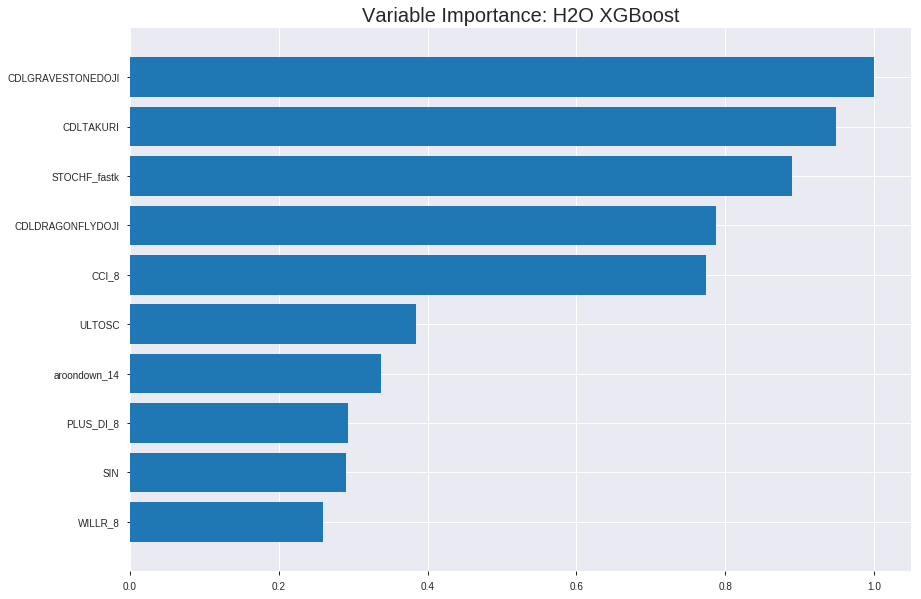

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190822_110901_model_4


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.16337360534543985
RMSE: 0.4041950090555793
LogLoss: 0.49834551506484076
Mean Per-Class Error: 0.23070936012453092
AUC: 0.8506462173225346
pr_auc: 0.8553514690024762
Gini: 0.7012924346450693
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4790052533149719: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      567  280   0.3306   (280.0/847.0)
1      132  810   0.1401   (132.0/942.0)
Total  699  1090  0.2303   (412.0/1789.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.479005     0.797244  224
max f2                       0.298741     0.874327  308
max f0point5                 0.582129     0.793004  170
max accuracy                 0.503345     0.772499  213
max precision                0.930191     1         0
max recall                   0.103831     1         386
max specificity              0.930191     1         0
max absolute_mcc             0.503345     0.543956  213
max min_per_class_accuracy   0.537875     0.766234  193
max mean_per_class_accuracy  0.535082     0.769291  195

Gains/Lift Table: Avg response rate: 52.66 %, avg score: 52.63 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100615                   0.914196           1.89915   1.89915            1                0.921992  1                           0.921992            0.0191083       0.0191083                  89.9151   89.9151
    2        0.020123                    0.903734           1.89915   1.89915            1                0.907882  1                           0.914937            0.0191083       0.0382166                  89.9151   89.9151
    3        0.0301845                   0.897441           1.89915   1.89915            1                0.90085   1                           0.910241            0.0191083       0.0573248                  89.9151   89.9151
    4        0.0402459                   0.888702           1.68813   1.8464             0.888889         0.893304  0.972222                    0.906007            0.0169851       0.07431                    68.8134   84.6397
    5        0.0503074                   0.880105           1.89915   1.85695            1                0.884977  0.977778                    0.901801            0.0191083       0.0934183                  89.9151   85.6947
    6        0.100056                    0.845859           1.79246   1.82488            0.94382          0.864505  0.960894                    0.883257            0.089172        0.18259                    79.2457   82.4882
    7        0.150363                    0.789761           1.64593   1.76501            0.866667         0.818494  0.929368                    0.861589            0.0828025       0.265393                   64.5931   76.501
    8        0.200112                    0.743399           1.68576   1.74531            0.88764          0.768077  0.918994                    0.838342            0.0838641       0.349257                   68.5763   74.5309
    9        0.300168                    0.670175           1.52781   1.67281            0.804469         0.705817  0.880819                    0.794167            0.152866        0.502123                   52.7808   67.2809
    10       0.400224                    0.608745           1.35805   1.59412            0.715084         0.638643  0.839385                    0.755286            0.135881        0.638004                   35.8052   59.412
    11       0.500279                    0.551367           1.12464   1.50022            0.592179         0.58151   0.789944                    0.720531            0.112527        0.750531                   12.4637   50.0223
    12       0.599776                    0.484086           1.00292   1.41773            0.52809          0.517511  0.746505                    0.686852            0.0997877       0.850318                   0.29223   41.7726
    13       0.699832                    0.403913           0.657806  1.30908            0.346369         0.447544  0.689297                    0.652638            0.0658174       0.916136                   -34.2194  30.9079
    14       0.799888                    0.300117           0.48805   1.20638            0.256983         0.355614  0.63522                     0.615484            0.0488323       0.964968                   -51.195   20.6379
    15       0.899944                    0.15321            0.254635  1.10056            0.134078         0.220646  0.579503                    0.571586            0.0254777       0.990446                   -74.5365  10.0564
    16       1                           0.0715755          0.095488  1                  0.0502793        0.118978  0.526551                    0.5263             



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.17542855243858207
RMSE: 0.4188419181965698
LogLoss: 0.5245745592943788
Mean Per-Class Error: 0.25853737610769745
AUC: 0.8178512983604533
pr_auc: 0.8282148753743009
Gini: 0.6357025967209067
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.49563589692115784: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      136  97   0.4163   (97.0/233.0)
1      34   244  0.1223   (34.0/278.0)
Total  170  341  0.2564   (131.0/511.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.495636     0.788368  258
max f2                       0.337328     0.877538  316
max f0point5                 0.701445     0.768859  139
max accuracy                 0.526205     0.749511  242
max precision                0.933955     1         0
max recall                   0.111352     1         390
max specificity              0.933955     1         0
max absolute_mcc             0.526205     0.495402  242
max min_per_class_accuracy   0.613263     0.733813  195
max mean_per_class_accuracy  0.595736     0.741463  208

Gains/Lift Table: Avg response rate: 54.40 %, avg score: 58.04 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117417                   0.915921           1.53177   1.53177            0.833333         0.920816  0.833333                    0.920816            0.0179856       0.0179856                  53.1775   53.1775
    2        0.0215264                   0.912799           1.83813   1.67103            1                0.91426   0.909091                    0.917836            0.0179856       0.0359712                  83.8129   67.1027
    3        0.0313112                   0.909145           1.4705    1.60836            0.8              0.910827  0.875                       0.915646            0.0143885       0.0503597                  47.0504   60.8363
    4        0.0410959                   0.905589           1.83813   1.66307            1                0.907156  0.904762                    0.913624            0.0179856       0.0683453                  83.8129   66.307
    5        0.0508806                   0.898167           1.83813   1.69673            1                0.900634  0.923077                    0.911126            0.0179856       0.0863309                  83.8129   69.6735
    6        0.101761                    0.880335           1.76743   1.73208            0.961538         0.88891   0.942308                    0.900018            0.0899281       0.176259                   76.7432   73.2084
    7        0.150685                    0.858255           1.61755   1.6949             0.88             0.869162  0.922078                    0.89                0.0791367       0.255396                   61.7554   69.4899
    8        0.201566                    0.818805           1.69673   1.69536            0.923077         0.840551  0.92233                     0.877518            0.0863309       0.341727                   69.6735   69.5362
    9        0.30137                     0.739543           1.36959   1.58748            0.745098         0.773108  0.863636                    0.84294             0.136691        0.478417                   36.9587   58.7475
    10       0.401174                    0.68109            1.26146   1.50637            0.686275         0.71194   0.819512                    0.81035             0.125899        0.604317                   26.1461   50.637
    11       0.500978                    0.627876           1.00917   1.40732            0.54902          0.656422  0.765625                    0.779685            0.100719        0.705036                   0.916914  40.7318
    12       0.600783                    0.552903           0.973127  1.33519            0.529412         0.591538  0.726384                    0.748429            0.0971223       0.802158                   -2.68726  33.5189
    13       0.700587                    0.478732           0.901044  1.27334            0.490196         0.510991  0.692737                    0.714604            0.0899281       0.892086                   -9.89561  27.3341
    14       0.800391                    0.351441           0.61271   1.19096            0.333333         0.416956  0.647922                    0.677489            0.0611511       0.953237                   -38.729   19.0964
    15       0.900196                    0.167962           0.360418  1.09888            0.196078         0.253698  0.597826                    0.630503            0.0359712       0.989209                   -63.9582  9.88818
    16       1                           0.0778268          0.108125  1                  0.0588235        0.12826   0.544031                    0.580377           


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-22 11:09:12  4.945 sec   0                  0.5              0.693147            0.5             0                  1                0.473449                         0.5                0.693147              0.5               0                    1                  0.455969
    2019-08-22 11:09:12  5.068 sec   5                  0.475939         0.645798            0.790666        0.591258           1.74294          0.285634                         0.473308           0.640718              0.787075          0.508208             1.6727             0.289628
    2019-08-22 11:09:12  5.123 sec   10                 0.459618         0.613675            0.804259        0.604059           1.74294          0.297373                         0.457097           0.608666              0.785863          0.508162             1.6727             0.303327
    2019-08-22 11:09:12  5.183 sec   15                 0.448389         0.590837            0.80899         0.607393           1.74294          0.286752                         0.445353           0.584568              0.79359           0.513854             1.6727             0.305284
    2019-08-22 11:09:12  5.245 sec   20                 0.440273         0.573876            0.814491        0.612199           1.74294          0.267747                         0.438597           0.569734              0.793266          0.514127             1.6727             0.318982
    2019-08-22 11:09:13  5.309 sec   25                 0.4347           0.562211            0.818246        0.829016           1.89915          0.274455                         0.434341           0.560189              0.799217          0.812889             1.53177            0.299413
    2019-08-22 11:09:13  5.374 sec   30                 0.429704         0.551738            0.823532        0.828225           1.7992           0.262158                         0.430749           0.552181              0.803169          0.810095             1.60836            0.295499
    2019-08-22 11:09:13  5.448 sec   35                 0.425803         0.543464            0.828064        0.835534           1.89915          0.257127                         0.428631           0.547058              0.803972          0.816674             1.83813            0.291585
    2019-08-22 11:09:13  5.528 sec   40                 0.422202         0.53586             0.830651        0.838872           1.89915          0.252096                         0.42678            0.542607              0.805879          0.82136              1.83813            0.291585
    2019-08-22 11:09:13  5.610 sec   45                 0.419205         0.529599            0.834704        0.844205           1.89915          0.249301                         0.425598           0.539713              0.80689           0.826088             1.83813            0.297456
    2019-08-22 11:09:13  5.688 sec   50                 0.416449         0.523818            0.837563        0.846842           1.89915          0.243153                         0.423838           0.535853              0.810024          0.825957             1.83813            0.295499
    2019-08-22 11:09:13  5.773 sec   55                 0.4139           0.518276            0.838488        0.847515           1.89915          0.237563                         0.422271           0.532404              0.811583          0

Variable Importances: 


variable           relative_importance    scaled_importance    percentage
-----------------  ---------------------  -------------------  ------------
CDLGRAVESTONEDOJI  830.965                1                    0.142683
CDLTAKURI          788.068                0.948378             0.135317
STOCHF_fastk       739.043                0.889379             0.126899
CDLDRAGONFLYDOJI   654.061                0.78711              0.112307
CCI_8              643.497                0.774397             0.110493
ULTOSC             319.041                0.383941             0.0547818
aroondown_14       280.101                0.33708              0.0480955
PLUS_DI_8          243.313                0.292808             0.0417786
SIN                241.035                0.290067             0.0413875
WILLR_8            215.093                0.258847             0.036933
COSH               207.001                0.24911              0.0355437
CORREL_12          165.638                0.199333             0.0284413
TRANGE             123.628                0.148776             0.0212278
PLUS_DI_12         109.632                0.131933             0.0188246
CORREL_14          97.4706                0.117298             0.0167364
CCI_12             70.5462                0.0848968            0.0121133
SAREXT             64.0695                0.0771026            0.0110012
weekday_name       31.6572                0.038097             0.00543578

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.80078125)

('F1', 0.782258064516129)

('auc', 0.8615592222290376)

('logloss', 0.5034411875033598)

('mean_per_class_error', 0.20214071029871805)

('rmse', 0.40718585635841403)

('mse', 0.16580032161833497)

xgboost prediction progress: |████████████████████████████████████████████| 100%


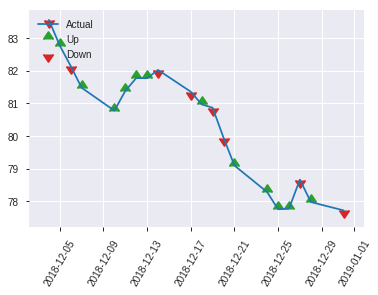


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.16580032161833497
RMSE: 0.40718585635841403
LogLoss: 0.5034411875033598
Mean Per-Class Error: 0.20214071029871805
AUC: 0.8615592222290376
pr_auc: 0.8371731200304808
Gini: 0.7231184444580752
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.563201367855072: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      105  32   0.2336   (32.0/137.0)
1      22   97   0.1849   (22.0/119.0)
Total  127  129  0.2109   (54.0/256.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.563201     0.782258  128
max f2                       0.309139     0.852941  203
max f0point5                 0.687208     0.827423  75
max accuracy                 0.615855     0.800781  105
max precision                0.92142      1         0
max recall                   0.132958     1         243
max specificity              0.92142      1         0
max absolute_mcc             0.615855     0.599867  105
max min_per_class_accuracy   0.572486     0.773723  123
max mean_per_class_accuracy  0.602799     0.797859  111

Gains/Lift Table: Avg response rate: 46.48 %, avg score: 53.99 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117188                   0.910393           2.15126    2.15126            1                0.916106  1                           0.916106            0.0252101       0.0252101                  115.126   115.126
    2        0.0234375                   0.899622           2.15126    2.15126            1                0.902915  1                           0.90951             0.0252101       0.0504202                  115.126   115.126
    3        0.03125                     0.896061           2.15126    2.15126            1                0.897823  1                           0.906588            0.0168067       0.0672269                  115.126   115.126
    4        0.0429688                   0.891708           2.15126    2.15126            1                0.894135  1                           0.903192            0.0252101       0.092437                   115.126   115.126
    5        0.0507812                   0.889015           2.15126    2.15126            1                0.889346  1                           0.901062            0.0168067       0.109244                   115.126   115.126
    6        0.101562                    0.86657            1.65482    1.90304            0.769231         0.875787  0.884615                    0.888424            0.0840336       0.193277                   65.4816   90.3038
    7        0.152344                    0.83582            1.98578    1.93062            0.923077         0.851974  0.897436                    0.876274            0.10084         0.294118                   98.5779   93.0618
    8        0.203125                    0.774728           2.15126    1.98578            1                0.804033  0.923077                    0.858214            0.109244        0.403361                   115.126   98.5779
    9        0.300781                    0.686336           1.89311    1.95569            0.88             0.720696  0.909091                    0.813565            0.184874        0.588235                   89.3109   95.5691
    10       0.402344                    0.621287           1.24111    1.77531            0.576923         0.655389  0.825243                    0.773637            0.12605         0.714286                   24.1112   77.5312
    11       0.5                         0.564638           0.946555   1.61345            0.44             0.591434  0.75                        0.738051            0.092437        0.806723                   -5.34454  61.3445
    12       0.601562                    0.498256           0.661926   1.4528             0.307692         0.526303  0.675325                    0.702301            0.0672269       0.87395                    -33.8074  45.2799
    13       0.699219                    0.426742           0.516303   1.322              0.24             0.459152  0.614525                    0.668342            0.0504202       0.92437                    -48.3697  32.2004
    14       0.800781                    0.305517           0.496445   1.2173             0.230769         0.37461   0.565854                    0.631088            0.0504202       0.97479                    -50.3555  21.7299
    15       0.898438                    0.156573           0.0860504  1.09434            0.04             0.219556  0.508696                    0.586356            0.00840336      0.983193                   -91.395   9.43369
    16       1                           0.0822309          0.165482   1                  0.0769231        0.128592  0.464844                   

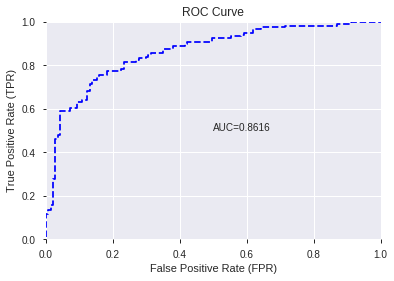

This function is available for GLM models only


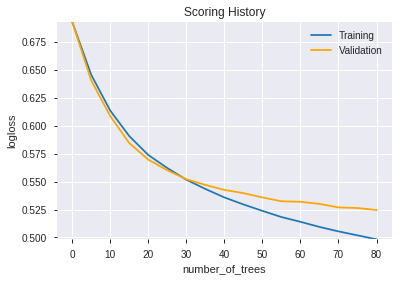

--2019-08-22 11:09:25--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.200.123
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.200.123|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at he

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190822_110901_model_4',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190822_110901_model_4',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_66_sid_a945',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['CDLGRAVESTONEDOJI',
 'CDLTAKURI',
 'STOCHF_fastk',
 'CDLDRAGONFLYDOJI',
 'CCI_8',
 'ULTOSC',
 'aroondown_14',
 'PLUS_DI_8',
 'SIN',
 'WILLR_8',
 'COSH',
 'CORREL_12',
 'TRANGE',
 'PLUS_DI_12',
 'CORREL_14',
 'CCI_12',
 'SAREXT',
 'weekday_name']

In [21]:
# XGBoost with top XGBoost features
model_train(feature_name='XGBF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

In [0]:
# PCA
try:
  del xgb_features,glm_features,dl_features
except:
  pass
gc.collect()

if features_to_include is True or 'PCA' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.pca import H2OPrincipalComponentAnalysisEstimator
      h2o_model = H2OPrincipalComponentAnalysisEstimator(seed=1, k=PCA_k, pca_method="GramSVD", max_iterations=10000)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OPrincipalComponentAnalysisEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [23]:
# DeepLearning with PCA
model_train(feature_name='PCA',model_algo="DeepLearning",training_frame=training_frame)

[]

In [24]:
# GLM with PCA
model_train(feature_name='PCA',model_algo="GLM",training_frame=training_frame)

[]

In [25]:
# XGBoost with PCA
model_train(feature_name='PCA',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# Generalized Low Rank
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'GLRM' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.glrm import H2OGeneralizedLowRankEstimator

      h2o_model = H2OGeneralizedLowRankEstimator(seed=1, k=GLRM_k)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OGeneralizedLowRankEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [27]:
# DeepLearning with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="DeepLearning",training_frame=training_frame)

[]

In [28]:
# GLM with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="GLM",training_frame=training_frame)

[]

In [29]:
# XGBoost with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# High Correlation Filter 
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'HCF' in features_to_include:
  corr_matrix = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).corr().abs()

  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

  features_list = [column for column in upper.columns if not any(upper[column] > HCF_threshold)]

  del corr_matrix, upper
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [31]:
# DeepLearning with low correlation features
model_train(feature_name='HCF',model_algo="DeepLearning",features_list=features_list)

[]

In [32]:
# GLM with low correlation features
model_train(feature_name='HCF',model_algo="GLM",features_list=features_list)

[]

In [33]:
# XGBoost with low correlation features
model_train(feature_name='HCF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
#	Low Variance Filter  
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'LVF' in features_to_include:
  df_variance = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).var()
  features_list = [column for column in df_variance.index if df_variance[column]  > LVF_threshold]

  del df_variance
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [35]:
# DeepLearning with Low Variance features  
model_train(feature_name='LVF',model_algo="DeepLearning",features_list=features_list)

[]

In [36]:
# GLM with Low Variance features  
model_train(feature_name='LVF',model_algo="GLM",features_list=features_list)

[]

In [37]:
# XGBoost with Low Variance features  
model_train(feature_name='LVF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select k best features
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'KBest' in features_to_include:
  from sklearn.feature_selection import SelectKBest
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectKBest(score_func=f_classif, k=select_k).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectKBest, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [39]:
# DeepLearning with Select k best features 
model_train(feature_name='KBest',model_algo="DeepLearning",features_list=features_list)

[]

In [40]:
# GLM with Select k best features
model_train(feature_name='KBest',model_algo="GLM",features_list=features_list)

[]

In [41]:
# XGBoost with Select k best features
model_train(feature_name='KBest',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select Percentile
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Percentile' in features_to_include:
  from sklearn.feature_selection import SelectPercentile
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectPercentile(score_func=f_classif, percentile=select_percentile).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectPercentile, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [43]:
# DeepLearning with Select Percentile features  
model_train(feature_name='Percentile',model_algo="DeepLearning",features_list=features_list)

[]

In [44]:
# GLM with Select Percentile features  
model_train(feature_name='Percentile',model_algo="GLM",features_list=features_list)

[]

In [45]:
# XGBoost with Select Percentile features  
model_train(feature_name='Percentile',model_algo="XGBoost",features_list=features_list)

[]

In [46]:
# Select Family-wise error
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Fwe' in features_to_include:
  from sklearn.feature_selection import SelectFwe
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectFwe(score_func=f_classif, alpha=select_alpha).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectFwe, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:114: UserWarning: Features [922] are constant.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:721: RuntimeWarning: invalid value encountered in less
  return (self.pvalues_ < self.alpha / len(self.pvalues_))


14

['CCI_8',
 'PLUS_DI_8',
 'PLUS_DM_8',
 'WILLR_8',
 'STOCHF_fastk',
 'ULTOSC',
 'CDLBELTHOLD',
 'CDLCLOSINGMARUBOZU',
 'CDLDRAGONFLYDOJI',
 'CDLGRAVESTONEDOJI',
 'CDLHANGINGMAN',
 'CDLINVERTEDHAMMER',
 'CDLSHOOTINGSTAR',
 'CDLTAKURI']

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0               DeepLearning_1_AutoML_20190822_110936  0.860946  0.540780              0.231246  0.426867  0.182215
1  DeepLearning_grid_1_AutoML_20190822_110936_model_1  0.851009  0.540095              0.209225  0.409679  0.167837
2  DeepLearning_grid_1_AutoML_20190822_110936_model_5  0.850457  0.510227              0.225265  0.410337  0.168376
3  DeepLearning_grid_1_AutoML_20190822_110936_model_6  0.850396  0.512573              0.211433  0.411707  0.169503
4  DeepLearning_grid_1_AutoML_20190822_110936_model_2  0.850334  0.522840              0.239649  0.412030  0.169769
5  DeepLearning_grid_1_AutoML_20190822_110936_model_7  0.847881  0.514934              0.203030  0.404871  0.163920
6  DeepLearning_grid_1_AutoML_20190822_110936_model_4  0.840397  0.507687              0.223824  0.406888  0.165558
7  DeepLearning_grid_1_AutoML_20190822_110936_model_3  0.826474  0.535764              0.259553  0.415743  0.172842

variable  relative_importance  scaled_importance  percentage
0                CCI_8             1.000000           1.000000    0.113075
1            CDLTAKURI             0.760114           0.760114    0.085950
2    CDLGRAVESTONEDOJI             0.729494           0.729494    0.082488
3         STOCHF_fastk             0.716152           0.716152    0.080979
4          CDLBELTHOLD             0.693246           0.693246    0.078389
5     CDLDRAGONFLYDOJI             0.673155           0.673155    0.076117
6              WILLR_8             0.625852           0.625852    0.070768
7   CDLCLOSINGMARUBOZU             0.577868           0.577868    0.065343
8            PLUS_DM_8             0.561432           0.561432    0.063484
9      CDLSHOOTINGSTAR             0.544068           0.544068    0.061521
10       CDLHANGINGMAN             0.531166           0.531166    0.060062
11           PLUS_DI_8             0.519793           0.519793    0.058776
12   CDLINVERTEDHAMMER             0.459423           0.459423    0.051949
13              ULTOSC             0.451895           0.451895    0.051098

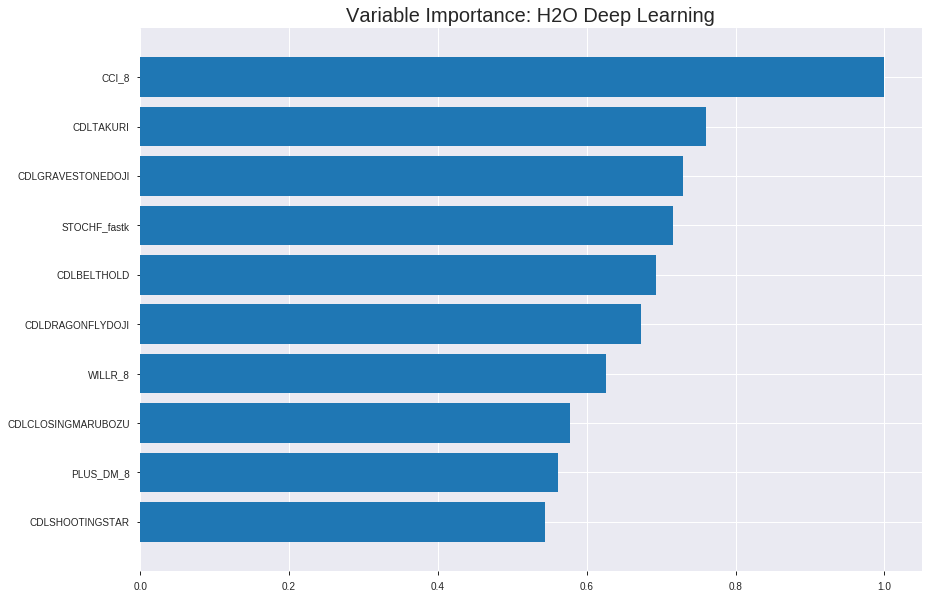

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_1_AutoML_20190822_110936


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.18923050144842266
RMSE: 0.435006323457973
LogLoss: 0.55683802161585
Mean Per-Class Error: 0.2838524629202105
AUC: 0.7951261728042273
pr_auc: 0.8032651016095432
Gini: 0.5902523456084545
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4993440108809285: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      434  413   0.4876   (413.0/847.0)
1      110  832   0.1168   (110.0/942.0)
Total  544  1245  0.2923   (523.0/1789.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.499344     0.76086   241
max f2                       0.255003     0.865906  332
max f0point5                 0.685131     0.742993  144
max accuracy                 0.63951      0.714366  168
max precision                0.992839     1         0
max recall                   0.0912497    1         386
max specificity              0.992839     1         0
max absolute_mcc             0.63951      0.432107  168
max min_per_class_accuracy   0.62017      0.70913   179
max mean_per_class_accuracy  0.63951      0.716148  168

Gains/Lift Table: Avg response rate: 52.66 %, avg score: 59.88 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100615                   0.981012           1.79364   1.79364            0.944444         0.987436  0.944444                    0.987436            0.0180467       0.0180467                  79.3642   79.3642
    2        0.020123                    0.97207            1.89915   1.8464             1                0.976576  0.972222                    0.982006            0.0191083       0.037155                   89.9151   84.6397
    3        0.0301845                   0.967046           1.79364   1.82881            0.944444         0.969217  0.962963                    0.977743            0.0180467       0.0552017                  79.3642   82.8812
    4        0.0402459                   0.962527           1.79364   1.82002            0.944444         0.965089  0.958333                    0.97458             0.0180467       0.0732484                  79.3642   82.0019
    5        0.0503074                   0.957692           1.89915   1.83585            1                0.960114  0.966667                    0.971686            0.0191083       0.0923567                  89.9151   83.5846
    6        0.100056                    0.929345           1.7071    1.77183            0.898876         0.945126  0.932961                    0.95848             0.0849257       0.177282                   70.7102   77.1833
    7        0.150363                    0.863496           1.60373   1.71559            0.844444         0.900277  0.903346                    0.939007            0.0806794       0.257962                   60.3727   71.559
    8        0.200112                    0.81531            1.4297    1.64452            0.752809         0.837188  0.865922                    0.913695            0.0711253       0.329087                   42.9698   64.4516
    9        0.300168                    0.737486           1.38988   1.55964            0.731844         0.77417   0.821229                    0.867186            0.139066        0.468153                   38.9881   55.9638
    10       0.400224                    0.682326           1.31561   1.49863            0.692737         0.708099  0.789106                    0.827414            0.131635        0.599788                   31.5613   49.8632
    11       0.500279                    0.624132           0.98671   1.39625            0.519553         0.652984  0.735196                    0.792528            0.0987261       0.698514                   -1.32904  39.6247
    12       0.599776                    0.569611           0.928237  1.31861            0.488764         0.596797  0.694315                    0.760058            0.0923567       0.79087                    -7.17634  31.8609
    13       0.699832                    0.496273           0.95488   1.26661            0.502793         0.531543  0.666933                    0.727387            0.0955414       0.886412                   -4.51197  26.6606
    14       0.799888                    0.390821           0.615367  1.18514            0.324022         0.450759  0.624039                    0.692785            0.0615711       0.947983                   -38.4633  18.5144
    15       0.899944                    0.219824           0.381952  1.09585            0.201117         0.309607  0.577019                    0.650183            0.0382166       0.9862                     -61.8048  9.58454
    16       1                           0.0448544          0.137927  1                  0.0726257        0.136562  0.526551                    0.598792          



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.1809177863377162
RMSE: 0.42534431504102205
LogLoss: 0.5373755762842783
Mean Per-Class Error: 0.2583135208571341
AUC: 0.8269444530212741
pr_auc: 0.8418194490104361
Gini: 0.6538889060425481
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5623305068885528: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      129  104  0.4464   (104.0/233.0)
1      29   249  0.1043   (29.0/278.0)
Total  158  353  0.2603   (133.0/511.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.562331     0.789223  263
max f2                       0.462429     0.882353  305
max f0point5                 0.709071     0.779896  162
max accuracy                 0.615553     0.74364   228
max precision                0.99098      1         0
max recall                   0.0792222    1         391
max specificity              0.99098      1         0
max absolute_mcc             0.569791     0.486229  258
max min_per_class_accuracy   0.667658     0.733813  194
max mean_per_class_accuracy  0.675559     0.741686  187

Gains/Lift Table: Avg response rate: 54.40 %, avg score: 64.27 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117417                   0.981666           1.83813   1.83813            1                0.984676  1                           0.984676            0.0215827       0.0215827                  83.8129   83.8129
    2        0.0215264                   0.975563           1.4705    1.67103            0.8              0.978985  0.909091                    0.98209             0.0143885       0.0359712                  47.0504   67.1027
    3        0.0313112                   0.972044           1.83813   1.72325            1                0.97342   0.9375                      0.97938             0.0179856       0.0539568                  83.8129   72.3246
    4        0.0410959                   0.969639           1.83813   1.7506             1                0.970902  0.952381                    0.977362            0.0179856       0.0719424                  83.8129   75.06
    5        0.0508806                   0.967926           1.4705    1.69673            0.8              0.968568  0.923077                    0.97567             0.0143885       0.0863309                  47.0504   69.6735
    6        0.101761                    0.954824           1.76743   1.73208            0.961538         0.961316  0.942308                    0.968493            0.0899281       0.176259                   76.7432   73.2084
    7        0.150685                    0.939221           1.7646    1.74264            0.96             0.947456  0.948052                    0.961663            0.0863309       0.26259                    76.4604   74.2642
    8        0.201566                    0.895305           1.55534   1.69536            0.846154         0.919112  0.92233                     0.950922            0.0791367       0.341727                   55.534    69.5362
    9        0.30137                     0.799581           1.51375   1.63522            0.823529         0.836138  0.88961                     0.912909            0.151079        0.492806                   51.3754   63.5219
    10       0.401174                    0.722634           1.11729   1.50637            0.607843         0.758158  0.819512                    0.87441             0.111511        0.604317                   11.7294   50.637
    11       0.500978                    0.674376           1.15334   1.43604            0.627451         0.696311  0.78125                     0.838929            0.115108        0.719424                   15.3336   43.6039
    12       0.600783                    0.618006           0.937086  1.35315            0.509804         0.644954  0.736156                    0.806705            0.0935252       0.81295                    -6.29144  35.3151
    13       0.700587                    0.554988           0.865002  1.28361            0.470588         0.588245  0.698324                    0.775584            0.0863309       0.899281                   -13.4998  28.361
    14       0.800391                    0.443718           0.61271   1.19995            0.333333         0.504755  0.652812                    0.741813            0.0611511       0.960432                   -38.729   19.9953
    15       0.900196                    0.242116           0.252292  1.09489            0.137255         0.340709  0.595652                    0.697343            0.0251799       0.985612                   -74.7708  9.48858
    16       1                           0.0244085          0.144167  1                  0.0784314        0.150119  0.544031                    0.642728            0


Scoring History: 


timestamp            duration    training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-22 11:09:36  0.000 sec                     0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-22 11:09:36  0.071 sec   57709 obs/sec     1         1             1789       0.453401         0.602485            0.175384       0.737777        0.750893           1.89915          0.354947                         0.43788            0.569876              0.227049         0.779703          0.800238             1.53177            0.297456
    2019-08-22 11:09:36  0.214 sec   114679 obs/sec    10        10            17890      0.435006         0.556838            0.240938       0.795126        0.803265           1.79364          0.292342                         0.425344           0.537376              0.270673         0.826944          0.841819             1.83813            0.260274

Variable Importances: 


variable            relative_importance    scaled_importance    percentage
------------------  ---------------------  -------------------  ------------
CCI_8               1                      1                    0.113075
CDLTAKURI           0.760114               0.760114             0.0859502
CDLGRAVESTONEDOJI   0.729494               0.729494             0.0824878
STOCHF_fastk        0.716152               0.716152             0.0809792
CDLBELTHOLD         0.693246               0.693246             0.078389
CDLDRAGONFLYDOJI    0.673155               0.673155             0.0761172
WILLR_8             0.625852               0.625852             0.0707685
CDLCLOSINGMARUBOZU  0.577868               0.577868             0.0653427
PLUS_DM_8           0.561432               0.561432             0.0634842
CDLSHOOTINGSTAR     0.544068               0.544068             0.0615207
CDLHANGINGMAN       0.531166               0.531166             0.0600618
PLUS_DI_8           0.519793               0.519793             0.0587758
CDLINVERTEDHAMMER   0.459423               0.459423             0.0519494
ULTOSC              0.451895               0.451895             0.0510982

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.79296875)

('F1', 0.7801418439716312)

('auc', 0.8609458381892903)

('logloss', 0.5407800647163948)

('mean_per_class_error', 0.21385634545789123)

('rmse', 0.4268667335142148)

('mse', 0.18221520818109566)

deeplearning prediction progress: |███████████████████████████████████████| 100%


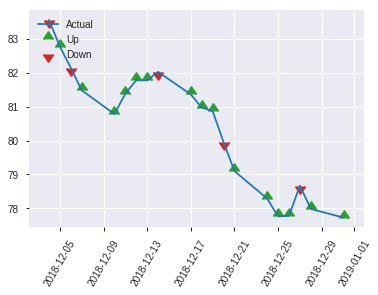


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.18221520818109566
RMSE: 0.4268667335142148
LogLoss: 0.5407800647163948
Mean Per-Class Error: 0.21385634545789123
AUC: 0.8609458381892903
pr_auc: 0.8281633141046705
Gini: 0.7218916763785805
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5564184389932801: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      84   53   0.3869   (53.0/137.0)
1      9    110  0.0756   (9.0/119.0)
Total  93   163  0.2422   (62.0/256.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.556418     0.780142  162
max f2                       0.556418     0.86072   162
max f0point5                 0.713958     0.813187  83
max accuracy                 0.676687     0.792969  95
max precision                0.990116     1         0
max recall                   0.228799     1         231
max specificity              0.990116     1         0
max absolute_mcc             0.676687     0.588455  95
max min_per_class_accuracy   0.636223     0.766423  123
max mean_per_class_accuracy  0.672213     0.786144  97

Gains/Lift Table: Avg response rate: 46.48 %, avg score: 60.63 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0117188                   0.984192           2.15126    2.15126            1                0.987323  1                           0.987323            0.0252101       0.0252101                  115.126    115.126
    2        0.0234375                   0.977899           2.15126    2.15126            1                0.980637  1                           0.98398             0.0252101       0.0504202                  115.126    115.126
    3        0.03125                     0.975239           2.15126    2.15126            1                0.976595  1                           0.982134            0.0168067       0.0672269                  115.126    115.126
    4        0.0429688                   0.972294           1.43417    1.95569            0.666667         0.973597  0.909091                    0.979805            0.0168067       0.0840336                  43.4174    95.5691
    5        0.0507812                   0.968749           1.07563    1.8203             0.5              0.972066  0.846154                    0.978615            0.00840336      0.092437                   7.56303    82.0297
    6        0.101562                    0.948875           2.15126    1.98578            1                0.95776   0.923077                    0.968187            0.109244        0.201681                   115.126    98.5779
    7        0.152344                    0.910524           1.8203     1.93062            0.846154         0.930963  0.897436                    0.955779            0.092437        0.294118                   82.0297    93.0618
    8        0.203125                    0.826348           2.15126    1.98578            1                0.875047  0.923077                    0.935596            0.109244        0.403361                   115.126    98.5779
    9        0.300781                    0.724566           1.63496    1.87188            0.76             0.759369  0.87013                     0.87838             0.159664        0.563025                   63.4958    87.1876
    10       0.402344                    0.665166           1.24111    1.71265            0.576923         0.696385  0.796117                    0.832439            0.12605         0.689076                   24.1112    71.2654
    11       0.5                         0.632868           0.946555   1.56303            0.44             0.646767  0.726562                    0.796175            0.092437        0.781513                   -5.34454   56.3025
    12       0.601562                    0.572724           0.992889   1.46677            0.461538         0.600043  0.681818                    0.763062            0.10084         0.882353                   -0.711054  46.6769
    13       0.699219                    0.514087           0.602353   1.34604            0.28             0.546343  0.625698                    0.732794            0.0588235       0.941176                   -39.7647   34.604
    14       0.800781                    0.397316           0.330963   1.2173             0.153846         0.45587   0.565854                    0.697672            0.0336134       0.97479                    -66.9037   21.7299
    15       0.898438                    0.256147           0.172101   1.10369            0.08             0.332225  0.513043                    0.657949            0.0168067       0.991597                   -82.7899   10.369
    16       1                           0.0512039          0.0827408  1                  0.0384615        0.149788  0.464844    

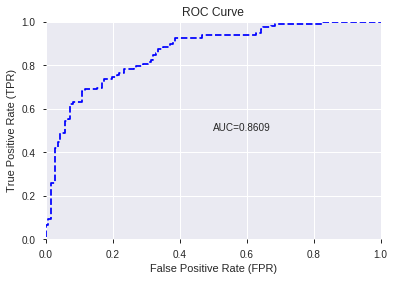

This function is available for GLM models only


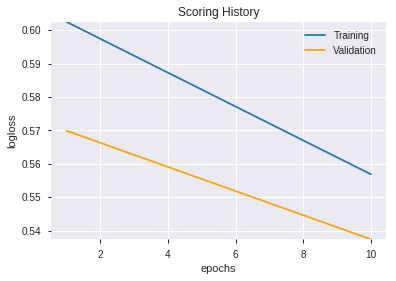

--2019-08-22 11:17:21--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.178.227
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.178.227|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_1_AutoML_20190822_110936',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_1_AutoML_20190822_110936',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_74_sid_a945',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_74_sid_a945'

['CCI_8',
 'CDLTAKURI',
 'CDLGRAVESTONEDOJI',
 'STOCHF_fastk',
 'CDLBELTHOLD',
 'CDLDRAGONFLYDOJI',
 'WILLR_8',
 'CDLCLOSINGMARUBOZU',
 'PLUS_DM_8',
 'CDLSHOOTINGSTAR',
 'CDLHANGINGMAN',
 'PLUS_DI_8',
 'CDLINVERTEDHAMMER',
 'ULTOSC']

In [47]:
# DeepLearning with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190822_111728_model_1  0.870515  0.485679              0.184997  0.400356  0.160285

variable  relative_importance  scaled_importance  percentage
0                CCI_8             1.059121           1.000000    0.210999
1    CDLGRAVESTONEDOJI             0.824048           0.778049    0.164168
2              WILLR_8             0.637412           0.601831    0.126986
3         STOCHF_fastk             0.564384           0.532880    0.112437
4            CDLTAKURI             0.511260           0.482721    0.101854
5     CDLDRAGONFLYDOJI             0.249487           0.235561    0.049703
6    CDLINVERTEDHAMMER             0.232457           0.219481    0.046310
7      CDLSHOOTINGSTAR             0.206040           0.194539    0.041048
8            PLUS_DM_8             0.203220           0.191876    0.040486
9        CDLHANGINGMAN             0.163726           0.154587    0.032618
10  CDLCLOSINGMARUBOZU             0.107719           0.101706    0.021460
11              ULTOSC             0.100516           0.094905    0.020025
12         CDLBELTHOLD             0.099109           0.093576    0.019745
13           PLUS_DI_8             0.061049           0.057641    0.012162

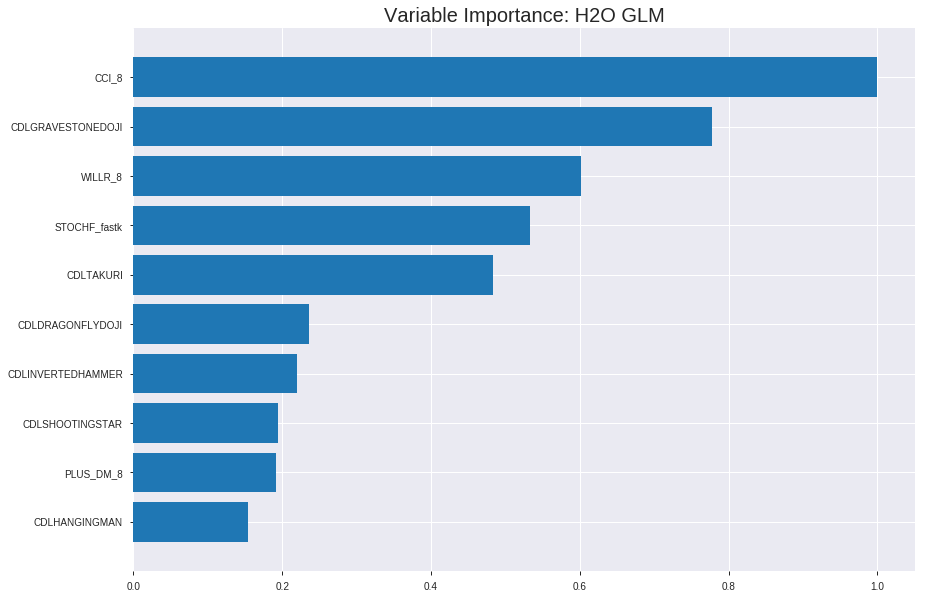

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190822_111728_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.1847493604352554
RMSE: 0.42982480202433104
LogLoss: 0.5433524531404166
Null degrees of freedom: 1788
Residual degrees of freedom: 1774
Null deviance: 2475.0335207517455
Residual deviance: 1944.1150773364106
AIC: 1974.1150773364106
AUC: 0.7910697679082161
pr_auc: 0.8051174513136309
Gini: 0.5821395358164323
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.38659612461569004: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      375  472   0.5573   (472.0/847.0)
1      74   868   0.0786   (74.0/942.0)
Total  449  1340  0.3052   (546.0/1789.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.386596     0.760736  268
max f2                       0.190211     0.866491  331
max f0point5                 0.580098     0.734196  168
max accuracy                 0.48848      0.711571  218
max precision                0.997009     1         0
max recall                   0.0230746    1         394
max specificity              0.997009     1         0
max absolute_mcc             0.463799     0.422402  231
max min_per_class_accuracy   0.534756     0.706021  193
max mean_per_class_accuracy  0.551457     0.710066  183

Gains/Lift Table: Avg response rate: 52.66 %, avg score: 52.66 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0100615                   0.980872           1.89915   1.89915            1                0.988346   1                           0.988346            0.0191083       0.0191083                  89.9151    89.9151
    2        0.020123                    0.975606           1.89915   1.89915            1                0.978211   1                           0.983278            0.0191083       0.0382166                  89.9151    89.9151
    3        0.0301845                   0.968492           1.89915   1.89915            1                0.97131    1                           0.979289            0.0191083       0.0573248                  89.9151    89.9151
    4        0.0402459                   0.958412           1.68813   1.8464             0.888889         0.962993   0.972222                    0.975215            0.0169851       0.07431                    68.8134    84.6397
    5        0.0503074                   0.946243           1.89915   1.85695            1                0.951826   0.977778                    0.970537            0.0191083       0.0934183                  89.9151    85.6947
    6        0.100056                    0.889229           1.66442   1.76122            0.876404         0.918241   0.927374                    0.944535            0.0828025       0.176221                   66.4424    76.1224
    7        0.150363                    0.799985           1.62483   1.71559            0.855556         0.843244   0.903346                    0.910646            0.081741        0.257962                   62.4829    71.559
    8        0.200112                    0.736504           1.45104   1.64982            0.764045         0.764638   0.868715                    0.874348            0.0721868       0.330149                   45.1037    64.9821
    9        0.300168                    0.655572           1.33683   1.54549            0.703911         0.69217    0.81378                     0.813622            0.133758        0.463907                   33.6832    54.5491
    10       0.400224                    0.601088           1.24134   1.46945            0.653631         0.627135   0.773743                    0.767               0.124204        0.58811                    24.1344    46.9455
    11       0.500279                    0.541188           1.07159   1.38988            0.564246         0.569028   0.731844                    0.727406            0.107219        0.695329                   7.15878    38.9881
    12       0.599776                    0.479515           0.992253  1.32392            0.522472         0.51194    0.697111                    0.691662            0.0987261       0.794055                   -0.774708  32.3919
    13       0.699832                    0.42226            0.816953  1.25144            0.430168         0.452036   0.658946                    0.657402            0.081741        0.875796                   -18.3047   25.1437
    14       0.799888                    0.331186           0.753294  1.18913            0.396648         0.383211   0.626136                    0.623105            0.0753715       0.951168                   -24.6706   18.9126
    15       0.899944                    0.118271           0.339513  1.09467            0.178771         0.216903   0.576398                    0.577943            0.0339703       0.985138                   -66.0487   9.46658
    16       1                           0.00452999         0.148537  1                  0.0782123        0.0643109  0.526551   



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.16816595458740774
RMSE: 0.4100804245357339
LogLoss: 0.5033829647351654
Null degrees of freedom: 510
Residual degrees of freedom: 496
Null deviance: 705.0556929735951
Residual deviance: 514.457389959339
AIC: 544.457389959339
AUC: 0.8337913360298885
pr_auc: 0.8532602087117572
Gini: 0.6675826720597771
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.519300426214337: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      146  87   0.3734   (87.0/233.0)
1      39   239  0.1403   (39.0/278.0)
Total  185  326  0.2466   (126.0/511.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.5193       0.791391  241
max f2                       0.150373     0.884419  350
max f0point5                 0.695115     0.784823  129
max accuracy                 0.5193       0.753425  241
max precision                0.991222     1         0
max recall                   0.0284876    1         395
max specificity              0.991222     1         0
max absolute_mcc             0.586977     0.505071  193
max min_per_class_accuracy   0.581985     0.73741   199
max mean_per_class_accuracy  0.586977     0.75352   193

Gains/Lift Table: Avg response rate: 54.40 %, avg score: 57.61 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117417                   0.983627           1.83813    1.83813            1                0.987161   1                           0.987161            0.0215827       0.0215827                  83.8129   83.8129
    2        0.0215264                   0.979845           1.83813    1.83813            1                0.981378   1                           0.984533            0.0179856       0.0395683                  83.8129   83.8129
    3        0.0313112                   0.977056           1.83813    1.83813            1                0.978241   1                           0.982566            0.0179856       0.057554                   83.8129   83.8129
    4        0.0410959                   0.971175           1.83813    1.83813            1                0.973905   1                           0.980504            0.0179856       0.0755396                  83.8129   83.8129
    5        0.0508806                   0.966588           1.83813    1.83813            1                0.968445   1                           0.978185            0.0179856       0.0935252                  83.8129   83.8129
    6        0.101761                    0.943578           1.69673    1.76743            0.923077         0.957197   0.961538                    0.967691            0.0863309       0.179856                   69.6735   76.7432
    7        0.150685                    0.911549           1.61755    1.71877            0.88             0.923266   0.935065                    0.953268            0.0791367       0.258993                   61.7554   71.877
    8        0.201566                    0.870746           1.55534    1.67752            0.846154         0.893088   0.912621                    0.938076            0.0791367       0.338129                   55.534    67.7516
    9        0.30137                     0.713729           1.58584    1.64716            0.862745         0.766644   0.896104                    0.881303            0.158273        0.496403                   58.5837   64.7155
    10       0.401174                    0.647553           1.18938    1.53327            0.647059         0.680698   0.834146                    0.831397            0.118705        0.615108                   18.9378   53.3269
    11       0.500978                    0.586577           1.15334    1.45758            0.627451         0.616064   0.792969                    0.788498            0.115108        0.730216                   15.3336   45.7579
    12       0.600783                    0.534221           0.792919   1.34716            0.431373         0.562602   0.732899                    0.750972            0.0791367       0.809353                   -20.7081  34.7163
    13       0.700587                    0.485043           0.82896    1.27334            0.45098          0.510705   0.692737                    0.716744            0.0827338       0.892086                   -17.104   27.3341
    14       0.800391                    0.364043           0.684793   1.19995            0.372549         0.432994   0.652812                    0.681362            0.0683453       0.960432                   -31.5207  19.9953
    15       0.900196                    0.140614           0.360418   1.10687            0.196078         0.232556   0.602174                    0.631603            0.0359712       0.996403                   -63.9582  10.6874
    16       1                           0.00825742         0.0360418  1                  0.0196078        0.0756473  0.544031  


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train      deviance_test
---  -------------------  ----------  -----------  --------  ------------  ------------------  ------------------
     2019-08-22 11:17:28  0.000 sec   2            .17E2     15            1.36811774293919    1.361390459559259
     2019-08-22 11:17:28  0.005 sec   4            .11E2     15            1.3595698642764351  1.3511603181244167
     2019-08-22 11:17:28  0.009 sec   6            .66E1     15            1.3469481022723526  1.3360469547602263
     2019-08-22 11:17:28  0.016 sec   8            .41E1     15            1.329155303499538   1.3147190827180604
     2019-08-22 11:17:28  0.020 sec   10           .25E1     15            1.3056324740806668  1.2864825452728976
---  ---                  ---         ---          ---       ---           ---                 ---
     2019-08-22 11:17:28  0.098 sec   43           .48E-3    15            1.0867430721165474  1.0071866482108862
     2019-08-22 11:17:28  0.101 sec   44           .3E-3     15            1.0867207692592047  1.0069944248144187
     2019-08-22 11:17:28  0.103 sec   45           .19E-3    15            1.086711030053749   1.0068774480794107
     2019-08-22 11:17:28  0.105 sec   46           .11E-3    15            1.086706784172388   1.0068100071403272
     2019-08-22 11:17:28  0.107 sec   47           .71E-4    15            1.0867049062808332  1.0067659294703308


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.8203125)

('F1', 0.7927927927927928)

('auc', 0.870514629209348)

('logloss', 0.48567923695627235)

('mean_per_class_error', 0.18499662638778136)

('rmse', 0.4003557583523547)

('mse', 0.16028473324588904)

glm prediction progress: |████████████████████████████████████████████████| 100%


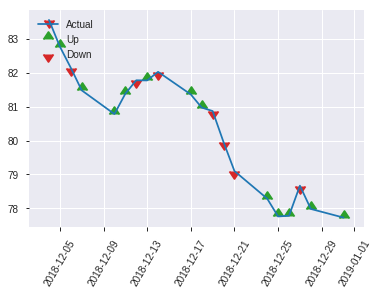


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.16028473324588904
RMSE: 0.4003557583523547
LogLoss: 0.48567923695627235
Null degrees of freedom: 255
Residual degrees of freedom: 241
Null deviance: 357.52774107262724
Residual deviance: 248.66776932161144
AIC: 278.66776932161144
AUC: 0.870514629209348
pr_auc: 0.8441757142906018
Gini: 0.7410292584186959
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5825353493240456: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      122  15   0.1095   (15.0/137.0)
1      31   88   0.2605   (31.0/119.0)
Total  153  103  0.1797   (46.0/256.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.582535     0.792793  102
max f2                       0.320381     0.846834  202
max f0point5                 0.582535     0.828625  102
max accuracy                 0.582535     0.820312  102
max precision                0.983273     1         0
max recall                   0.123028     1         227
max specificity              0.983273     1         0
max absolute_mcc             0.582535     0.640788  102
max min_per_class_accuracy   0.552793     0.79562   122
max mean_per_class_accuracy  0.582535     0.815003  102

Gains/Lift Table: Avg response rate: 46.48 %, avg score: 52.28 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117188                   0.973561           2.15126   2.15126            1                0.979598   1                           0.979598            0.0252101       0.0252101                  115.126   115.126
    2        0.0234375                   0.967904           1.43417   1.79272            0.666667         0.970538   0.833333                    0.975068            0.0168067       0.0420168                  43.4174   79.2717
    3        0.03125                     0.96466            2.15126   1.88235            1                0.965621   0.875                       0.972706            0.0168067       0.0588235                  115.126   88.2353
    4        0.0429688                   0.961746           2.15126   1.95569            1                0.963912   0.909091                    0.970308            0.0252101       0.0840336                  115.126   95.5691
    5        0.0507812                   0.957429           2.15126   1.98578            1                0.957556   0.923077                    0.968346            0.0168067       0.10084                    115.126   98.5779
    6        0.101562                    0.917854           2.15126   2.06852            1                0.938646   0.961538                    0.953496            0.109244        0.210084                   115.126   106.852
    7        0.152344                    0.839518           1.8203    1.98578            0.846154         0.885884   0.923077                    0.930959            0.092437        0.302521                   82.0297   98.5779
    8        0.203125                    0.721585           1.98578   1.98578            0.923077         0.772975   0.923077                    0.891463            0.10084         0.403361                   98.5779   98.5779
    9        0.300781                    0.645174           1.80706   1.92775            0.84             0.684005   0.896104                    0.824106            0.176471        0.579832                   80.7059   92.7753
    10       0.402344                    0.582535           1.57207   1.83797            0.730769         0.613542   0.854369                    0.770954            0.159664        0.739496                   57.2075   83.797
    11       0.5                         0.542823           0.774454  1.63025            0.36             0.564108   0.757812                    0.730555            0.0756303       0.815126                   -22.5546  63.0252
    12       0.601562                    0.490328           0.661926  1.46677            0.307692         0.512648   0.681818                    0.693765            0.0672269       0.882353                   -33.8074  46.6769
    13       0.699219                    0.398353           0.344202  1.30999            0.16             0.448022   0.608939                    0.659444            0.0336134       0.915966                   -65.5798  30.9985
    14       0.800781                    0.303899           0.496445  1.2068             0.230769         0.345835   0.560976                    0.619669            0.0504202       0.966387                   -50.3555  20.6805
    15       0.898438                    0.110022           0.344202  1.11304            0.16             0.210843   0.517391                    0.575231            0.0336134       1                          -65.5798  11.3043
    16       1                           0.0124477          0         1                  0                0.0588954  0.464844                    

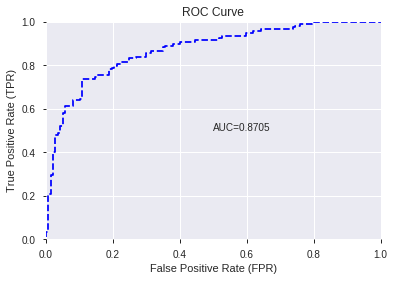

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


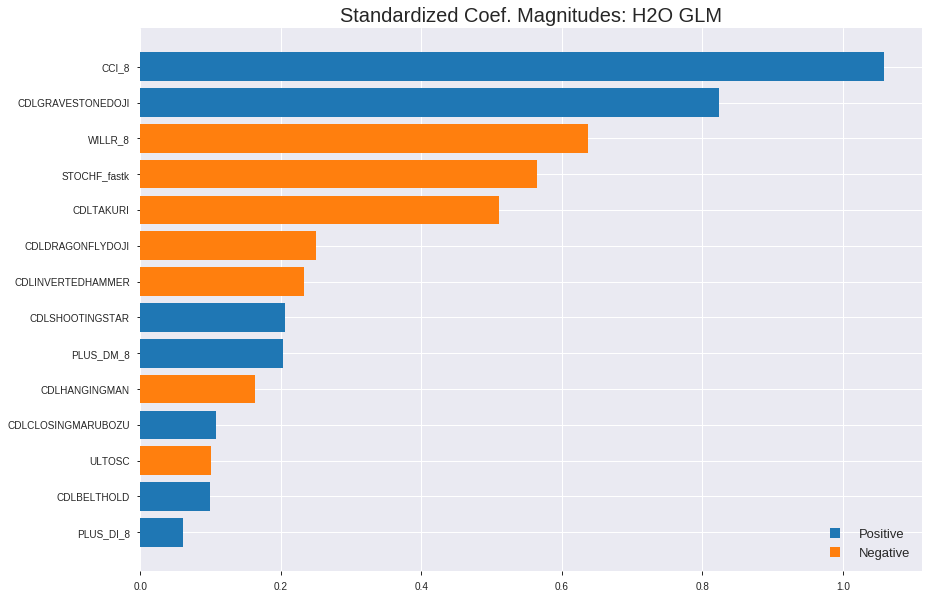

'log_likelihood'
--2019-08-22 11:17:34--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.237.91
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.237.91|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190822_111728_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190822_111728_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_82_sid_a945',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_82_s

['CCI_8',
 'CDLGRAVESTONEDOJI',
 'WILLR_8',
 'STOCHF_fastk',
 'CDLTAKURI',
 'CDLDRAGONFLYDOJI',
 'CDLINVERTEDHAMMER',
 'CDLSHOOTINGSTAR',
 'PLUS_DM_8',
 'CDLHANGINGMAN',
 'CDLCLOSINGMARUBOZU',
 'ULTOSC',
 'CDLBELTHOLD',
 'PLUS_DI_8']

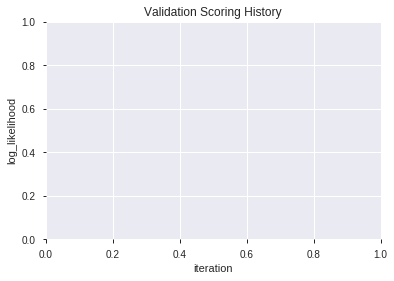

In [48]:
# GLM with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190822_111742_model_4  0.855517  0.490032              0.201037  0.399302  0.159442
1  XGBoost_grid_1_AutoML_20190822_111742_model_2  0.854505  0.489759              0.234006  0.400565  0.160453
2  XGBoost_grid_1_AutoML_20190822_111742_model_6  0.853340  0.487153              0.230908  0.399256  0.159405
3               XGBoost_2_AutoML_20190822_111742  0.853033  0.486819              0.228915  0.398340  0.158675
4  XGBoost_grid_1_AutoML_20190822_111742_model_3  0.852911  0.491245              0.216187  0.400771  0.160618
5               XGBoost_1_AutoML_20190822_111742  0.851806  0.485527              0.208888  0.396712  0.157381
6  XGBoost_grid_1_AutoML_20190822_111742_model_1  0.849598  0.492803              0.223486  0.401905  0.161528
7               XGBoost_3_AutoML_20190822_111742  0.846930  0.492258              0.214408  0.402713  0.162178
8  XGBoost_grid_1_AutoML_20190822_111742_model_7  0.846347  0.492347              0.238422  0.401973  0.161582
9  XGBoost_grid_1_AutoML_20190822_111742_model_5  0.828743  0.512092              0.237533  0.414346  0.171682

variable  relative_importance  scaled_importance  percentage
0  CDLGRAVESTONEDOJI           836.313660           1.000000    0.157358
1          CDLTAKURI           831.103088           0.993770    0.156378
2              CCI_8           808.351746           0.966565    0.152097
3       STOCHF_fastk           770.589111           0.921412    0.144992
4   CDLDRAGONFLYDOJI           619.479553           0.740726    0.116559
5             ULTOSC           384.376373           0.459608    0.072323
6          PLUS_DM_8           382.585480           0.457466    0.071986
7            WILLR_8           380.784546           0.455313    0.071647
8          PLUS_DI_8           301.134308           0.360073    0.056660

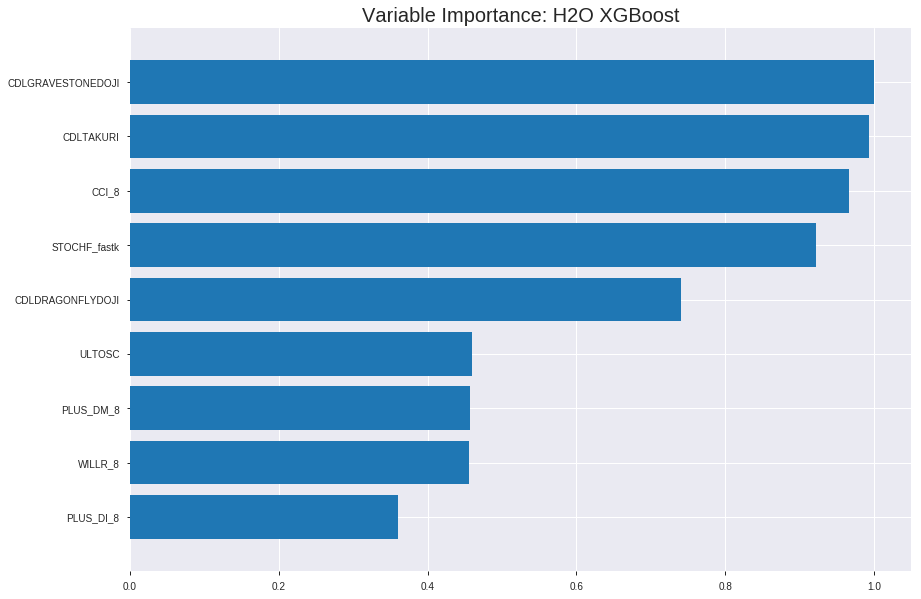

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190822_111742_model_4


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.1694312622358213
RMSE: 0.41162028890206726
LogLoss: 0.5109394060259299
Mean Per-Class Error: 0.24505059696142495
AUC: 0.8318155498236565
pr_auc: 0.842386328710128
Gini: 0.6636310996473129
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4117221891880035: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      458  389   0.4593   (389.0/847.0)
1      91   851   0.0966   (91.0/942.0)
Total  549  1240  0.2683   (480.0/1789.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.411722     0.780018  256
max f2                       0.188483     0.871534  341
max f0point5                 0.584881     0.776978  166
max accuracy                 0.523856     0.755729  198
max precision                0.93298      1         0
max recall                   0.0948859    1         389
max specificity              0.93298      1         0
max absolute_mcc             0.523856     0.509993  198
max min_per_class_accuracy   0.534837     0.750885  192
max mean_per_class_accuracy  0.523856     0.754949  198

Gains/Lift Table: Avg response rate: 52.66 %, avg score: 52.66 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100615                   0.918062           1.89915   1.89915            1                0.922718  1                           0.922718            0.0191083       0.0191083                  89.9151   89.9151
    2        0.020123                    0.910422           1.89915   1.89915            1                0.913366  1                           0.918042            0.0191083       0.0382166                  89.9151   89.9151
    3        0.0301845                   0.90553            1.89915   1.89915            1                0.907551  1                           0.914545            0.0191083       0.0573248                  89.9151   89.9151
    4        0.0402459                   0.900478           1.79364   1.87277            0.944444         0.902963  0.986111                    0.911649            0.0180467       0.0753715                  79.3642   87.2774
    5        0.0503074                   0.893421           1.89915   1.87805            1                0.897131  0.988889                    0.908746            0.0191083       0.0944798                  89.9151   87.8049
    6        0.100056                    0.845561           1.74978   1.81427            0.921348         0.870686  0.955307                    0.889822            0.0870488       0.181529                   74.9779   81.4272
    7        0.150363                    0.79888            1.68813   1.77207            0.888889         0.822647  0.933086                    0.867347            0.0849257       0.266454                   68.8134   77.207
    8        0.200112                    0.760095           1.55773   1.71878            0.820225         0.780887  0.905028                    0.845853            0.0774947       0.343949                   55.773    71.8784
    9        0.300168                    0.685373           1.4111    1.61622            0.743017         0.721167  0.851024                    0.804291            0.141189        0.485138                   41.1101   61.6223
    10       0.400224                    0.614887           1.34744   1.54903            0.709497         0.650215  0.815642                    0.765772            0.13482         0.619958                   34.7442   54.9028
    11       0.500279                    0.544299           1.19891   1.479              0.631285         0.582448  0.778771                    0.729107            0.119958        0.739915                   19.8905   47.9003
    12       0.599776                    0.477968           0.928237  1.38764            0.488764         0.512284  0.730662                    0.693138            0.0923567       0.832272                   -7.17634  38.7637
    13       0.699832                    0.406112           0.742685  1.29543            0.391061         0.439283  0.682109                    0.656844            0.07431         0.906582                   -25.7315  29.5427
    14       0.799888                    0.282658           0.49866   1.19576            0.26257          0.354829  0.62963                     0.619066            0.0498938       0.956476                   -50.134   19.5762
    15       0.899944                    0.142522           0.307684  1.09702            0.162011         0.201228  0.57764                     0.572611            0.0307856       0.987261                   -69.2316  9.7025
    16       1                           0.0702633          0.127317  1                  0.0670391        0.112851  0.526551                    0.526609           



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.1720942579794023
RMSE: 0.41484244958707195
LogLoss: 0.515632412909471
Mean Per-Class Error: 0.2563914533609164
AUC: 0.8214329823694693
pr_auc: 0.8388367380879215
Gini: 0.6428659647389385
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.34856003522872925: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      101  132  0.5665   (132.0/233.0)
1      14   264  0.0504   (14.0/278.0)
Total  115  396  0.2857   (146.0/511.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.34856      0.783383  302
max f2                       0.276081     0.88293   318
max f0point5                 0.640916     0.771757  167
max accuracy                 0.55051      0.747554  220
max precision                0.924726     1         0
max recall                   0.0779564    1         397
max specificity              0.924726     1         0
max absolute_mcc             0.55051      0.489128  220
max min_per_class_accuracy   0.595907     0.733813  193
max mean_per_class_accuracy  0.576239     0.743609  204

Gains/Lift Table: Avg response rate: 54.40 %, avg score: 56.99 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117417                   0.921152           1.83813   1.83813            1                0.922595  1                           0.922595            0.0215827       0.0215827                  83.8129   83.8129
    2        0.0215264                   0.916257           1.83813   1.83813            1                0.917465  1                           0.920263            0.0179856       0.0395683                  83.8129   83.8129
    3        0.0313112                   0.91376            1.83813   1.83813            1                0.915278  1                           0.918705            0.0179856       0.057554                   83.8129   83.8129
    4        0.0410959                   0.910063           1.83813   1.83813            1                0.912468  1                           0.91722             0.0179856       0.0755396                  83.8129   83.8129
    5        0.0508806                   0.907802           1.10288   1.69673            0.6              0.90872   0.923077                    0.915585            0.0107914       0.0863309                  10.2878   69.6735
    6        0.101761                    0.89004            1.69673   1.69673            0.923077         0.899564  0.923077                    0.907575            0.0863309       0.172662                   69.6735   69.6735
    7        0.150685                    0.863883           1.7646    1.71877            0.96             0.87728   0.935065                    0.897739            0.0863309       0.258993                   76.4604   71.877
    8        0.201566                    0.827127           1.69673   1.71321            0.923077         0.846335  0.932039                    0.884763            0.0863309       0.345324                   69.6735   71.3208
    9        0.30137                     0.748131           1.36959   1.59941            0.745098         0.779988  0.87013                     0.850065            0.136691        0.482014                   36.9587   59.9411
    10       0.401174                    0.6836             1.26146   1.51534            0.686275         0.713857  0.82439                     0.816179            0.125899        0.607914                   26.1461   51.5336
    11       0.500978                    0.612191           1.04521   1.42168            0.568627         0.646667  0.773438                    0.782409            0.104317        0.71223                    4.52109   42.1678
    12       0.600783                    0.532985           0.937086  1.34118            0.509804         0.57126   0.729642                    0.747332            0.0935252       0.805755                   -6.29144  34.1176
    13       0.700587                    0.443811           0.82896   1.26821            0.45098          0.486775  0.689944                    0.710214            0.0827338       0.888489                   -17.104   26.8207
    14       0.800391                    0.288695           0.648752  1.19096            0.352941         0.379251  0.647922                    0.668945            0.0647482       0.953237                   -35.1248  19.0964
    15       0.900196                    0.163282           0.324376  1.09489            0.176471         0.225941  0.595652                    0.619829            0.0323741       0.985612                   -67.5624  9.48858
    16       1                           0.0729718          0.144167  1                  0.0784314        0.119912  0.544031                    0.569935          


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-22 11:17:51  3.764 sec   0                  0.5              0.693147            0.5             0                  1                0.473449                         0.5                0.693147              0.5               0                    1                  0.455969
    2019-08-22 11:17:51  3.819 sec   5                  0.476111         0.646124            0.78827         0.588711           1.74294          0.297932                         0.473057           0.640241              0.791598          0.511851             1.6727             0.287671
    2019-08-22 11:17:51  3.860 sec   10                 0.459981         0.61434             0.799077        0.598064           1.74294          0.28284                          0.456134           0.606888              0.792123          0.512224             1.6727             0.318982
    2019-08-22 11:17:51  3.897 sec   15                 0.448649         0.591283            0.802348        0.600891           1.74294          0.288429                         0.444455           0.582938              0.796747          0.515322             1.6727             0.289628
    2019-08-22 11:17:51  3.943 sec   20                 0.440694         0.574568            0.80609         0.604171           1.74294          0.286193                         0.436853           0.566569              0.799495          0.518544             1.6727             0.318982
    2019-08-22 11:17:51  3.986 sec   25                 0.435318         0.56305             0.809859        0.787673           1.89915          0.27725                          0.432408           0.55642               0.801016          0.773611             1.60836            0.320939
    2019-08-22 11:17:51  4.038 sec   30                 0.430609         0.553065            0.814484        0.822337           1.7992           0.27725                          0.428628           0.548119              0.805894          0.820096             1.83813            0.293542
    2019-08-22 11:17:51  4.092 sec   35                 0.427766         0.546623            0.815798        0.825835           1.79364          0.28284                          0.426782           0.543375              0.806018          0.8202               1.83813            0.297456
    2019-08-22 11:17:51  4.153 sec   40                 0.425267         0.541027            0.81674         0.824177           1.89915          0.256568                         0.424953           0.538725              0.807214          0.82065              1.83813            0.297456
    2019-08-22 11:17:51  4.213 sec   45                 0.422186         0.534407            0.820917        0.828629           1.89915          0.264394                         0.422551           0.533428              0.810186          0.825615             1.83813            0.299413
    2019-08-22 11:17:51  4.275 sec   50                 0.419864         0.529361            0.822906        0.831192           1.89915          0.259363                         0.420316           0.528474              0.812973          0.818408             1.83813            0.293542
    2019-08-22 11:17:51  4.335 sec   55                 0.418176         0.525484            0.823539        0.832543           1.89915          0.247624                         0.419167           0.525502              0.814841          0

Variable Importances: 


variable           relative_importance    scaled_importance    percentage
-----------------  ---------------------  -------------------  ------------
CDLGRAVESTONEDOJI  836.314                1                    0.157358
CDLTAKURI          831.103                0.99377              0.156378
CCI_8              808.352                0.966565             0.152097
STOCHF_fastk       770.589                0.921412             0.144992
CDLDRAGONFLYDOJI   619.48                 0.740726             0.116559
ULTOSC             384.376                0.459608             0.072323
PLUS_DM_8          382.585                0.457466             0.071986
WILLR_8            380.785                0.455313             0.0716472
PLUS_DI_8          301.134                0.360073             0.0566605

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.8046875)

('F1', 0.7829787234042553)

('auc', 0.8555173894375269)

('logloss', 0.49003187595963016)

('mean_per_class_error', 0.20014721216953935)

('rmse', 0.3993020091990044)

('mse', 0.1594420945503618)

xgboost prediction progress: |████████████████████████████████████████████| 100%


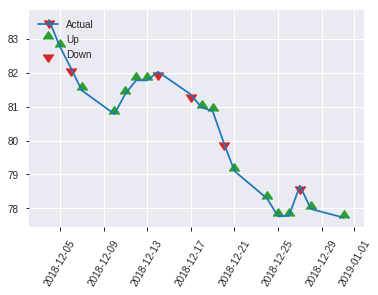


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.1594420945503618
RMSE: 0.3993020091990044
LogLoss: 0.49003187595963016
Mean Per-Class Error: 0.20014721216953935
AUC: 0.8555173894375269
pr_auc: 0.8261562928432126
Gini: 0.7110347788750537
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5531110763549805: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      113  24   0.1752   (24.0/137.0)
1      27   92   0.2269   (27.0/119.0)
Total  140  116  0.1992   (51.0/256.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.553111     0.782979  113
max f2                       0.230327     0.851528  207
max f0point5                 0.601567     0.815534  96
max accuracy                 0.601567     0.804688  96
max precision                0.925176     1         0
max recall                   0.105426     1         241
max specificity              0.925176     1         0
max absolute_mcc             0.601567     0.6108    96
max min_per_class_accuracy   0.526696     0.781513  119
max mean_per_class_accuracy  0.580445     0.799853  102

Gains/Lift Table: Avg response rate: 46.48 %, avg score: 50.64 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117188                   0.911562           2.15126   2.15126            1                0.91778   1                           0.91778             0.0252101       0.0252101                  115.126   115.126
    2        0.0234375                   0.905417           1.43417   1.79272            0.666667         0.908896  0.833333                    0.913338            0.0168067       0.0420168                  43.4174   79.2717
    3        0.03125                     0.900936           2.15126   1.88235            1                0.902278  0.875                       0.910573            0.0168067       0.0588235                  115.126   88.2353
    4        0.0429688                   0.897997           2.15126   1.95569            1                0.90002   0.909091                    0.907695            0.0252101       0.0840336                  115.126   95.5691
    5        0.0507812                   0.887913           2.15126   1.98578            1                0.893817  0.923077                    0.90556             0.0168067       0.10084                    115.126   98.5779
    6        0.101562                    0.857168           1.98578   1.98578            0.923077         0.87511   0.923077                    0.890335            0.10084         0.201681                   98.5779   98.5779
    7        0.152344                    0.828033           1.8203    1.93062            0.846154         0.843374  0.897436                    0.874681            0.092437        0.294118                   82.0297   93.0618
    8        0.203125                    0.778123           2.15126   1.98578            1                0.800007  0.923077                    0.856013            0.109244        0.403361                   115.126   98.5779
    9        0.300781                    0.661147           1.63496   1.87188            0.76             0.721017  0.87013                     0.812183            0.159664        0.563025                   63.4958   87.1876
    10       0.402344                    0.581416           1.48933   1.77531            0.692308         0.624683  0.825243                    0.764853            0.151261        0.714286                   48.9334   77.5312
    11       0.5                         0.507158           0.774454  1.57983            0.36             0.548515  0.734375                    0.722599            0.0756303       0.789916                   -22.5546  57.9832
    12       0.601562                    0.419168           0.744667  1.43883            0.346154         0.461799  0.668831                    0.678568            0.0756303       0.865546                   -25.5333  43.883
    13       0.699219                    0.350528           0.430252  1.29797            0.2              0.390662  0.603352                    0.638358            0.0420168       0.907563                   -56.9748  29.7967
    14       0.800781                    0.252138           0.579186  1.2068             0.269231         0.298465  0.560976                    0.595249            0.0588235       0.966387                   -42.0814  20.6805
    15       0.898438                    0.144454           0.172101  1.09434            0.08             0.190746  0.508696                    0.551282            0.0168067       0.983193                   -82.7899  9.43369
    16       1                           0.0739308          0.165482  1                  0.0769231        0.10937   0.464844                    0.5064            

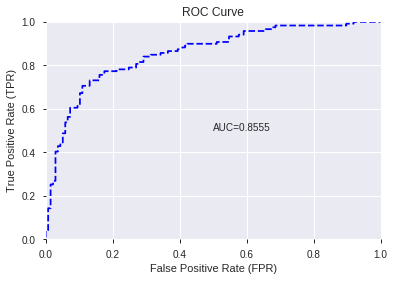

This function is available for GLM models only


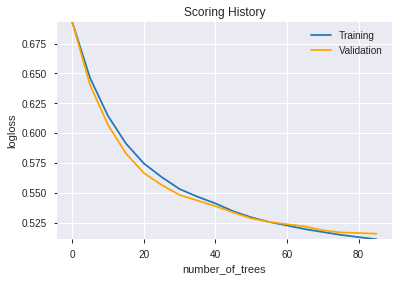

--2019-08-22 11:18:06--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.166.75
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.166.75|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.indexOf(String.java:1578)
	at java.base/java.lang.String.indexOf(String.java:1535)
	at java.base/java.lang.String.split(String.java:2274)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoMode

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190822_111742_model_4',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190822_111742_model_4',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_90_sid_a945',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['CDLGRAVESTONEDOJI',
 'CDLTAKURI',
 'CCI_8',
 'STOCHF_fastk',
 'CDLDRAGONFLYDOJI',
 'ULTOSC',
 'PLUS_DM_8',
 'WILLR_8',
 'PLUS_DI_8']

In [49]:
# XGBoost with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="XGBoost",features_list=features_list)

In [50]:
# recursive feature elimination with cross validation
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'RFE' in features_to_include:
  from sklearn.feature_selection import RFECV
  from sklearn.svm import LinearSVC
  from sklearn.tree import DecisionTreeClassifier,ExtraTreeClassifier
  from sklearn.linear_model import LogisticRegression, LinearRegression

  bestfeatures = RFECV(ExtraTreeClassifier(random_state=1,criterion='entropy'), min_features_to_select=select_rfe, step=1,cv=5).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, RFECV, LinearSVC, DecisionTreeClassifier,ExtraTreeClassifier, LogisticRegression, LinearRegression
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list = []

557

['BBANDS_middleband_12_4_3',
 'BBANDS_lowerband_12_4_3',
 'BBANDS_upperband_12_4_4',
 'BBANDS_middleband_12_4_4',
 'BBANDS_lowerband_12_4_4',
 'BBANDS_upperband_12_4_5',
 'BBANDS_middleband_12_4_5',
 'BBANDS_lowerband_12_4_5',
 'MA_12_5',
 'MAVP_12_5',
 'BBANDS_upperband_12_5_2',
 'BBANDS_middleband_12_5_2',
 'BBANDS_lowerband_12_5_2',
 'BBANDS_upperband_12_5_3',
 'BBANDS_middleband_12_5_3',
 'BBANDS_lowerband_12_5_3',
 'BBANDS_upperband_12_5_4',
 'BBANDS_middleband_12_5_4',
 'BBANDS_lowerband_12_5_4',
 'BBANDS_upperband_12_5_5',
 'BBANDS_middleband_12_5_5',
 'BBANDS_lowerband_12_5_5',
 'MA_12_6',
 'MAVP_12_6',
 'BBANDS_upperband_12_6_2',
 'BBANDS_middleband_12_6_2',
 'BBANDS_lowerband_12_6_2',
 'BBANDS_upperband_12_6_3',
 'BBANDS_middleband_12_6_3',
 'BBANDS_lowerband_12_6_3',
 'BBANDS_upperband_12_6_4',
 'BBANDS_middleband_12_6_4',
 'BBANDS_lowerband_12_6_4',
 'BBANDS_upperband_12_6_5',
 'BBANDS_middleband_12_6_5',
 'BBANDS_lowerband_12_6_5',
 'MA_12_7',
 'MAVP_12_7',
 'BBANDS_upperb

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190822_111922_model_8  0.841072  0.518481              0.230908  0.412765  0.170375
1  DeepLearning_grid_1_AutoML_20190822_111922_model_9  0.840459  0.525394              0.228363  0.417315  0.174152
2  DeepLearning_grid_1_AutoML_20190822_111922_model_6  0.839048  0.532128              0.231123  0.421445  0.177616
3  DeepLearning_grid_1_AutoML_20190822_111922_model_3  0.833589  0.506624              0.246948  0.410176  0.168244
4  DeepLearning_grid_1_AutoML_20190822_111922_model_2  0.830399  0.513847              0.224591  0.411336  0.169198
5  DeepLearning_grid_1_AutoML_20190822_111922_model_4  0.795314  0.621489              0.294608  0.445461  0.198436
6               DeepLearning_1_AutoML_20190822_111922  0.787953  0.677588              0.271821  0.469979  0.220880
7  DeepLearning_grid_1_AutoML_20190822_111922_model_5  0.771760  0.614830              0.326688  0.462379  0.213795
8  DeepLearning_grid_1_AutoML_20190822_111922_model_7  0.764829  0.573722              0.287984  0.444318  0.197418
9  DeepLearning_grid_1_AutoML_20190822_111922_model_1  0.759615  1.421257              0.335644  0.524073  0.274652

variable  relative_importance  scaled_importance  percentage
0           CDLGRAVESTONEDOJI             1.000000           1.000000    0.009937
1            CDLDRAGONFLYDOJI             0.898181           0.898181    0.008925
2                   CDLTAKURI             0.874298           0.874298    0.008688
3                STOCHF_fastk             0.710694           0.710694    0.007062
4              CDLRICKSHAWMAN             0.630890           0.630890    0.006269
..                        ...                  ...                ...         ...
552  BBANDS_middleband_14_5_4             0.127540           0.127540    0.001267
553                   MA_14_2             0.126874           0.126874    0.001261
554  BBANDS_middleband_14_1_5             0.126554           0.126554    0.001258
555  BBANDS_middleband_20_3_4             0.126413           0.126413    0.001256
556           CDLLADDERBOTTOM             0.121293           0.121293    0.001205

[557 rows x 4 columns]

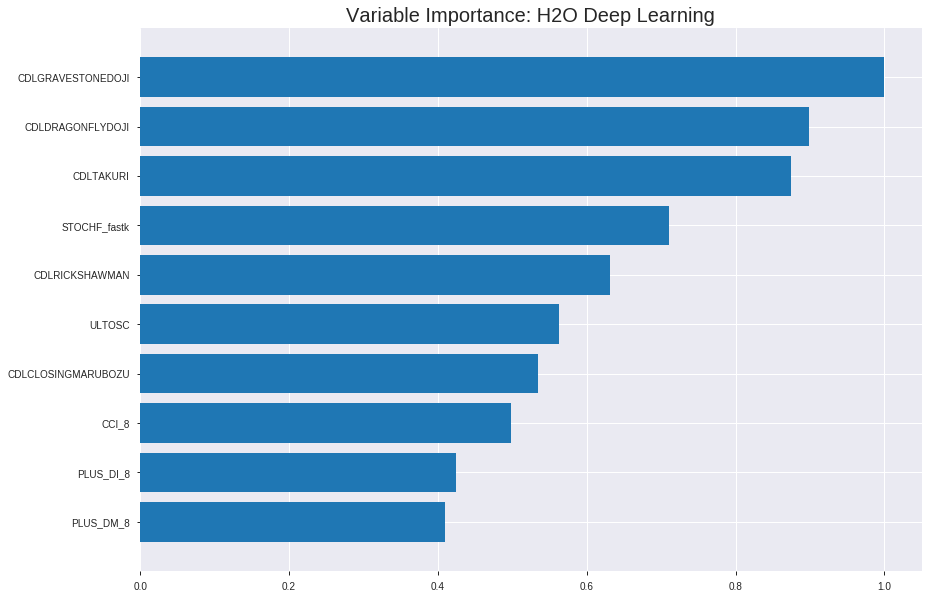

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190822_111922_model_8


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.1692977121846121
RMSE: 0.411458032106085
LogLoss: 0.5019416057648504
Mean Per-Class Error: 0.26313239935127597
AUC: 0.8315642570130121
pr_auc: 0.8390400517210718
Gini: 0.6631285140260241
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.44494854012926804: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      430  417   0.4923   (417.0/847.0)
1      60   882   0.0637   (60.0/942.0)
Total  490  1299  0.2666   (477.0/1789.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.444949     0.787149  245
max f2                       0.276501     0.883089  298
max f0point5                 0.575525     0.765633  173
max accuracy                 0.558583     0.740637  189
max precision                0.998794     1         0
max recall                   0.0232677    1         384
max specificity              0.998794     1         0
max absolute_mcc             0.444949     0.497082  245
max min_per_class_accuracy   0.57166      0.704841  178
max mean_per_class_accuracy  0.558583     0.736868  189

Gains/Lift Table: Avg response rate: 52.66 %, avg score: 51.10 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100615                   0.994868           1.89915    1.89915            1                0.996966   1                           0.996966            0.0191083       0.0191083                  89.9151   89.9151
    2        0.020123                    0.989694           1.89915    1.89915            1                0.992815   1                           0.99489             0.0191083       0.0382166                  89.9151   89.9151
    3        0.0301845                   0.980192           1.89915    1.89915            1                0.985443   1                           0.991741            0.0191083       0.0573248                  89.9151   89.9151
    4        0.0402459                   0.974205           1.79364    1.87277            0.944444         0.976817   0.986111                    0.98801             0.0180467       0.0753715                  79.3642   87.2774
    5        0.0503074                   0.967015           1.89915    1.87805            1                0.971216   0.988889                    0.984651            0.0191083       0.0944798                  89.9151   87.8049
    6        0.100056                    0.882932           1.77112    1.82488            0.932584         0.929766   0.960894                    0.957362            0.0881104       0.18259                    77.1118   82.4882
    7        0.150363                    0.764879           1.70924    1.78619            0.9              0.823655   0.94052                     0.912627            0.0859873       0.268577                   70.9236   78.619
    8        0.200112                    0.646654           1.64309    1.75061            0.865169         0.694479   0.921788                    0.858395            0.081741        0.350318                   64.3085   75.0614
    9        0.300168                    0.582702           1.40049    1.63391            0.73743          0.603967   0.860335                    0.773586            0.140127        0.490446                   40.0491   63.3906
    10       0.400224                    0.57463            1.26256    1.54107            0.664804         0.578351   0.811453                    0.724777            0.126327        0.616773                   26.2564   54.1071
    11       0.540525                    0.571652           1.02902    1.40816            0.541833         0.572059   0.741468                    0.685137            0.144374        0.761146                   2.90219   40.816
    12       0.599776                    0.552031           1.00332    1.36817            0.528302         0.562375   0.72041                     0.673009            0.059448        0.820594                   0.332492  36.8167
    13       0.699832                    0.479781           0.94427    1.30756            0.497207         0.519891   0.688498                    0.651118            0.0944798       0.915074                   -5.57295  30.7562
    14       0.799888                    0.260603           0.583538   1.217              0.307263         0.388223   0.640811                    0.618233            0.0583864       0.973461                   -41.6462  21.6996
    15       0.899944                    0.0515005          0.190976   1.10292            0.100559         0.142962   0.580745                    0.565392            0.0191083       0.992569                   -80.9024  10.2923
    16       1                           0.000313461        0.0742685  1                  0.0391061        0.0217944  0.526551   



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.18299077012552276
RMSE: 0.42777420460509624
LogLoss: 0.5445330195766028
Mean Per-Class Error: 0.29223917003736066
AUC: 0.7895297495908852
pr_auc: 0.8136374668984288
Gini: 0.5790594991817704
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4430895124072229: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      99   134  0.5751   (134.0/233.0)
1      16   262  0.0576   (16.0/278.0)
Total  115  396  0.2935   (150.0/511.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.44309      0.777448  293
max f2                       0.0938181    0.881596  338
max f0point5                 0.586148     0.7358    183
max accuracy                 0.537447     0.716243  254
max precision                0.999442     1         0
max recall                   0.0137212    1         386
max specificity              0.999442     1         0
max absolute_mcc             0.484662     0.439572  279
max min_per_class_accuracy   0.575483     0.701439  204
max mean_per_class_accuracy  0.57408      0.707761  209

Gains/Lift Table: Avg response rate: 54.40 %, avg score: 56.76 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117417                   0.997689           1.83813   1.83813            1                0.998362  1                           0.998362            0.0215827       0.0215827                  83.8129   83.8129
    2        0.0215264                   0.995565           1.83813   1.83813            1                0.995958  1                           0.997269            0.0179856       0.0395683                  83.8129   83.8129
    3        0.0313112                   0.994433           1.83813   1.83813            1                0.9947    1                           0.996467            0.0179856       0.057554                   83.8129   83.8129
    4        0.0410959                   0.990451           1.83813   1.83813            1                0.992678  1                           0.995565            0.0179856       0.0755396                  83.8129   83.8129
    5        0.0508806                   0.989554           1.83813   1.83813            1                0.989973  1                           0.994489            0.0179856       0.0935252                  83.8129   83.8129
    6        0.101761                    0.974093           1.69673   1.76743            0.923077         0.982036  0.961538                    0.988263            0.0863309       0.179856                   69.6735   76.7432
    7        0.150685                    0.928848           1.4705    1.67103            0.8              0.954867  0.909091                    0.97742             0.0719424       0.251799                   47.0504   67.1027
    8        0.201566                    0.835729           1.55534   1.64182            0.846154         0.887962  0.893204                    0.954838            0.0791367       0.330935                   55.534    64.1824
    9        0.30137                     0.706641           1.26146   1.51586            0.686275         0.768194  0.824675                    0.893028            0.125899        0.456835                   26.1461   51.586
    10       0.401174                    0.59472            1.08125   1.40774            0.588235         0.643594  0.765854                    0.830973            0.107914        0.564748                   8.12526   40.7738
    11       0.500978                    0.576665           1.18938   1.36424            0.647059         0.583178  0.742188                    0.781608            0.118705        0.683453                   18.9378   36.4237
    12       0.600783                    0.571327           0.937086  1.29328            0.509804         0.573529  0.703583                    0.747041            0.0935252       0.776978                   -6.29144  29.3277
    13       0.700587                    0.534318           1.04521   1.25794            0.568627         0.55544   0.684358                    0.719746            0.104317        0.881295                   4.52109   25.7938
    14       0.800391                    0.331457           0.756877  1.19546            0.411765         0.463857  0.650367                    0.687838            0.0755396       0.956835                   -24.3123  19.5458
    15       0.900196                    0.050352           0.324376  1.09888            0.176471         0.147767  0.597826                    0.627961            0.0323741       0.989209                   -67.5624  9.88818
    16       1                           0.000938921        0.108125  1                  0.0588235        0.022926  0.544031                    0.567576          


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-22 11:31:12  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-22 11:31:14  2 min 12.608 sec  392 obs/sec       0.419788  1             751        0.595487         1.19899             -0.422428      0.525468        0.539768           1.16059          0.471772                         0.538014           0.827448              -0.166884        0.537469          0.582883             1.53177            0.454012
    2019-08-22 11:31:33  2 min 32.358 sec  534 obs/sec       5.89324   14            10543      0.475719         0.642316            0.092205       0.76446         0.770786           1.89915          0.299609                         0.454016           0.597314              0.169034         0.795759          0.810223             1.53177            0.287671
    2019-08-22 11:31:54  2 min 52.823 sec  571 obs/sec       12.2169   29            21856      0.45324          0.593056            0.17597        0.749518        0.759436           1.89915          0.294578                         0.440689           0.566149              0.217103         0.771143          0.794871             1.83813            0.307241
    2019-08-22 11:32:13  3 min 12.411 sec  595 obs/sec       18.6182   44            33308      0.433333         0.550097            0.246766       0.802881        0.815901           1.89915          0.281722                         0.433076           0.548355              0.243916         0.777766          0.799891             1.83813            0.287671
    2019-08-22 11:32:33  3 min 32.385 sec  613 obs/sec       25.398    60            45437      0.427468         0.537474            0.267017       0.812235        0.818288           1.89915          0.272219                         0.442252           0.577095              0.211538         0.770325          0.794075             1.83813            0.303327
    2019-08-22 11:32:53  3 min 51.887 sec  620 obs/sec       31.7792   75            56853      0.411458         0.501942            0.320894       0.831564        0.83904            1.89915          0.266629                         0.427774           0.544533              0.262316         0.78953           0.813637             1.83813            0.293542
    2019-08-22 11:33:13  4 min 11.941 sec  628 obs/sec       38.5539   91            68973      0.43111          0.543687            0.254475       0.80585         0.812509           1.89915          0.267188                         0.43591            0.563676              0.233991         0.763995          0.781379             1.83813            0.291585
    2019-08-22 11:33:33  4 min 32.094 sec  633 obs/sec       45.3572   107           81144      0.419061         0.520365            0.295565       0.821553        0.806653           1.89915          0.26607                          0.444533           0.655271              0.203385         0.76655           0.747833             1.53177            0.303327
    2019-08-22 11:33:35

Variable Importances: 


variable                  relative_importance    scaled_importance    percentage
------------------------  ---------------------  -------------------  ---------------------
CDLGRAVESTONEDOJI         1.0                    1.0                  0.009936801742509915
CDLDRAGONFLYDOJI          0.8981808423995972     0.8981808423995972   0.00892504495984534
CDLTAKURI                 0.8742983937263489     0.8742983937263489   0.008687729802253602
STOCHF_fastk              0.7106935381889343     0.7106935381889343   0.007062020788666339
CDLRICKSHAWMAN            0.6308896541595459     0.6308896541595459   0.006269025414784053
---                       ---                    ---                  ---
BBANDS_middleband_14_5_4  0.12753967940807343    0.12753967940807343  0.0012673365085812999
MA_14_2                   0.1268741339445114     0.1268741339445114   0.0012607231152592573
BBANDS_middleband_14_1_5  0.12655362486839294    0.12655362486839294  0.0012575382801131932
BBANDS_middleband_20_3_4  0.12641341984272003    0.12641341984272003  0.0012561450905697778
CDLLADDERBOTTOM           0.12129276245832443    0.12129276245832443  0.0012052621333497194


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7734375)

('F1', 0.7732342007434944)

('auc', 0.8410721953014783)

('logloss', 0.5184811454259395)

('mean_per_class_error', 0.23090842176286575)

('rmse', 0.41276535587562346)

('mse', 0.17037523901113008)

deeplearning prediction progress: |███████████████████████████████████████| 100%


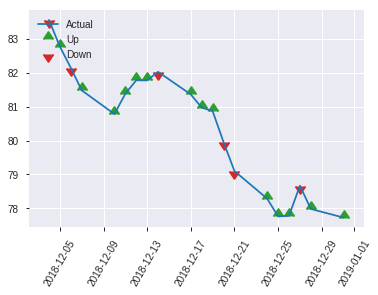


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.17037523901113008
RMSE: 0.41276535587562346
LogLoss: 0.5184811454259395
Mean Per-Class Error: 0.23090842176286575
AUC: 0.8410721953014783
pr_auc: 0.8079013010060971
Gini: 0.6821443906029565
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4883109003287132: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      91   46   0.3358   (46.0/137.0)
1      15   104  0.1261   (15.0/119.0)
Total  106  150  0.2383   (61.0/256.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.488311     0.773234  145
max f2                       0.216202     0.849335  196
max f0point5                 0.57883      0.788337  85
max accuracy                 0.57622      0.773438  92
max precision                0.989684     1         0
max recall                   0.0112459    1         241
max specificity              0.989684     1         0
max absolute_mcc             0.57622      0.549915  92
max min_per_class_accuracy   0.553868     0.744526  119
max mean_per_class_accuracy  0.488311     0.769092  145

Gains/Lift Table: Avg response rate: 46.48 %, avg score: 49.19 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0117188                   0.988962           2.15126   2.15126            1                0.98954    1                           0.98954             0.0252101       0.0252101                  115.126    115.126
    2        0.0234375                   0.982992           2.15126   2.15126            1                0.986102   1                           0.987821            0.0252101       0.0504202                  115.126    115.126
    3        0.03125                     0.978042           2.15126   2.15126            1                0.981622   1                           0.986271            0.0168067       0.0672269                  115.126    115.126
    4        0.0429688                   0.969398           2.15126   2.15126            1                0.973258   1                           0.982722            0.0252101       0.092437                   115.126    115.126
    5        0.0507812                   0.962545           2.15126   2.15126            1                0.967828   1                           0.980431            0.0168067       0.109244                   115.126    115.126
    6        0.101562                    0.901131           1.65482   1.90304            0.769231         0.934494   0.884615                    0.957462            0.0840336       0.193277                   65.4816    90.3038
    7        0.152344                    0.837097           1.98578   1.93062            0.923077         0.869431   0.897436                    0.928118            0.10084         0.294118                   98.5779    93.0618
    8        0.203125                    0.769784           1.65482   1.86167            0.769231         0.798362   0.865385                    0.895679            0.0840336       0.378151                   65.4816    86.1668
    9        0.300781                    0.586942           1.80706   1.84394            0.84             0.654459   0.857143                    0.817361            0.176471        0.554622                   80.7059    84.3938
    10       0.402344                    0.571932           1.15837   1.67088            0.538462         0.577343   0.776699                    0.756774            0.117647        0.672269                   15.8371    67.0882
    11       0.5                         0.545774           1.03261   1.54622            0.48             0.565486   0.71875                     0.719413            0.10084         0.773109                   3.2605     54.6218
    12       0.601562                    0.483696           0.992889  1.4528             0.461538         0.513376   0.675325                    0.684627            0.10084         0.87395                    -0.711054  45.2799
    13       0.699219                    0.384197           0.516303  1.322              0.24             0.425332   0.614525                    0.648413            0.0504202       0.92437                    -48.3697   32.2004
    14       0.800781                    0.152115           0.413704  1.2068             0.192308         0.291883   0.560976                    0.603195            0.0420168       0.966387                   -58.6296   20.6805
    15       0.898438                    0.0248577          0.172101  1.09434            0.08             0.0768716  0.508696                    0.545986            0.0168067       0.983193                   -82.7899   9.43369
    16       1                           0.00404014         0.165482  1                  0.0769231        0.0131657  0.464844  

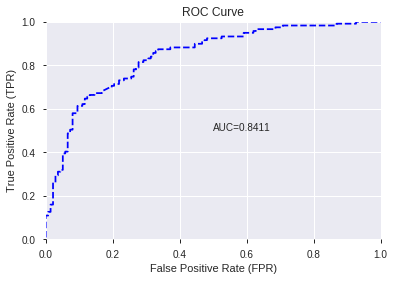

This function is available for GLM models only


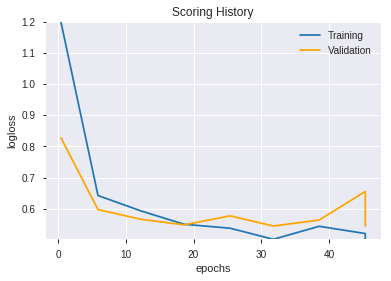

--2019-08-22 11:37:39--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.171.27
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.171.27|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190822_111922_model_8',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190822_111922_model_8',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_98_sid_a945',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['CDLGRAVESTONEDOJI',
 'CDLDRAGONFLYDOJI',
 'CDLTAKURI',
 'STOCHF_fastk',
 'CDLRICKSHAWMAN',
 'ULTOSC',
 'CDLCLOSINGMARUBOZU',
 'CCI_8',
 'PLUS_DI_8',
 'PLUS_DM_8',
 'WILLR_8',
 'CDLSHOOTINGSTAR',
 'CCI_20',
 'CCI_30',
 'CCI_12',
 'CCI_24',
 'PLUS_DI_12',
 'CDLINVERTEDHAMMER',
 'TRANGE',
 'STOCH_slowd',
 'WILLR_12',
 'MINUS_DI_8',
 'CDLLONGLEGGEDDOJI',
 'aroonup_8',
 'CCI_14',
 'WILLR_14',
 'CDLSPINNINGTOP',
 'PLUS_DI_20',
 'BETA_8',
 'aroondown_14',
 'PLUS_DI_14',
 'aroondown_12',
 'aroondown_20',
 'DX_8',
 'BETA_12',
 'CORREL_14',
 'CORREL_12',
 'PLUS_DM_12',
 'HT_TRENDMODE',
 'aroonup_30',
 'MINUS_DI_12',
 'MINUS_DI_30',
 'STOCHRSI_fastk',
 'ADX_24',
 'ADX_20',
 'CDLHIGHWAVE',
 'HT_PHASOR_inphase',
 'WILLR_20',
 'AROONOSC_8',
 'BETA_30',
 'CORREL_20',
 'aroondown_24',
 'MINUS_DM_8',
 'AROONOSC_20',
 'STDDEV_8',
 'PLUS_DI_30',
 'PLUS_DM_14',
 'BETA_20',
 'ADX_8',
 'BETA_14',
 'VAR_8',
 'BETA_24',
 'aroonup_14',
 'CDLHANGINGMAN',
 'MACDEXT_hist',
 'HT_PHASOR_quadrature',
 'DX_12',
 'M

In [51]:
# DeepLearning with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id      auc   logloss  mean_per_class_error      rmse      mse
0  GLM_grid_1_AutoML_20190822_113747_model_1  0.87671  0.462465              0.180028  0.388535  0.15096

variable  relative_importance  scaled_importance    percentage
0                STOCHF_fastk             0.826696           1.000000  1.781010e-02
1           CDLGRAVESTONEDOJI             0.763770           0.923882  1.645444e-02
2                    MEDPRICE             0.737050           0.891561  1.587879e-02
3                       CCI_8             0.687731           0.831903  1.481628e-02
4                   PLUS_DI_8             0.665638           0.805179  1.434032e-02
..                        ...                  ...                ...           ...
552   BBANDS_lowerband_30_6_4             0.000111           0.000134  2.393611e-06
553  BBANDS_middleband_20_3_2             0.000085           0.000102  1.823687e-06
554                   MA_14_2             0.000065           0.000078  1.395744e-06
555  BBANDS_middleband_14_3_3             0.000064           0.000077  1.373850e-06
556                   ROCR_30             0.000012           0.000014  2.485030e-07

[557 rows x 4 columns]

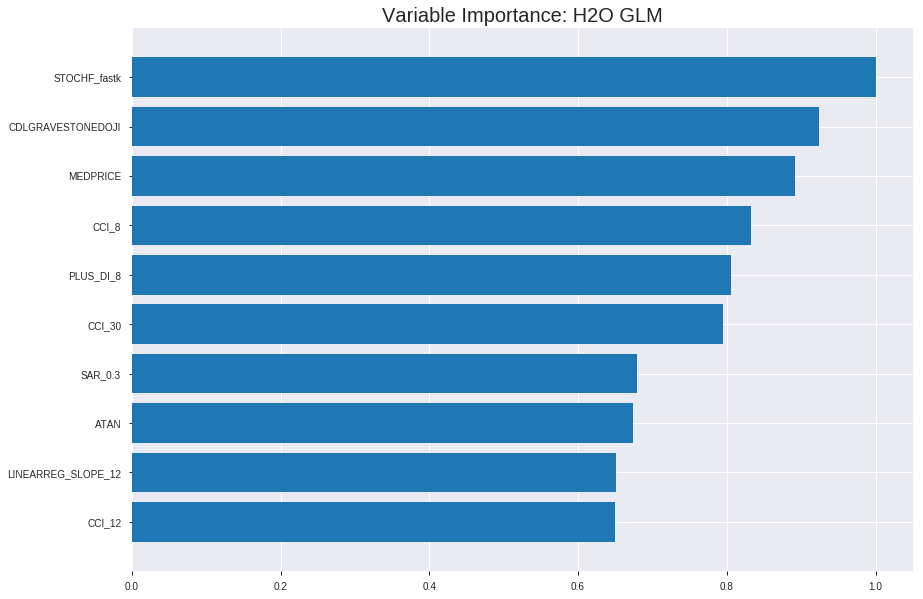

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190822_113747_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.15968440992792884
RMSE: 0.399605317692256
LogLoss: 0.4839115965247298
Null degrees of freedom: 1788
Residual degrees of freedom: 1231
Null deviance: 2475.0335207517455
Residual deviance: 1731.4356923654832
AIC: 2847.435692365483
AUC: 0.847494090545625
pr_auc: 0.852068758029419
Gini: 0.6949881810912499
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.47028435860417667: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      556  291   0.3436   (291.0/847.0)
1      132  810   0.1401   (132.0/942.0)
Total  688  1101  0.2364   (423.0/1789.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.470284     0.792952  221
max f2                       0.233507     0.877193  308
max f0point5                 0.600781     0.790754  163
max accuracy                 0.515183     0.771381  200
max precision                0.997724     1         0
max recall                   0.0196342    1         390
max specificity              0.997724     1         0
max absolute_mcc             0.510155     0.541137  202
max min_per_class_accuracy   0.547252     0.762692  187
max mean_per_class_accuracy  0.515183     0.769157  200

Gains/Lift Table: Avg response rate: 52.66 %, avg score: 52.66 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100615                   0.990225           1.89915   1.89915            1                0.993553  1                           0.993553            0.0191083       0.0191083                  89.9151   89.9151
    2        0.020123                    0.980355           1.89915   1.89915            1                0.984806  1                           0.98918             0.0191083       0.0382166                  89.9151   89.9151
    3        0.0301845                   0.973656           1.89915   1.89915            1                0.976805  1                           0.985055            0.0191083       0.0573248                  89.9151   89.9151
    4        0.0402459                   0.966809           1.79364   1.87277            0.944444         0.969536  0.986111                    0.981175            0.0180467       0.0753715                  79.3642   87.2774
    5        0.0503074                   0.957258           1.89915   1.87805            1                0.962966  0.988889                    0.977533            0.0191083       0.0944798                  89.9151   87.8049
    6        0.100056                    0.90769            1.77112   1.82488            0.932584         0.933288  0.960894                    0.955534            0.0881104       0.18259                    77.1118   82.4882
    7        0.150363                    0.84497            1.62483   1.75795            0.855556         0.87695   0.925651                    0.929242            0.081741        0.264331                   62.4829   75.795
    8        0.200112                    0.799012           1.7071    1.74531            0.898876         0.820503  0.918994                    0.902209            0.0849257       0.349257                   70.7102   74.5309
    9        0.300168                    0.709516           1.50659   1.66574            0.793296         0.752842  0.877095                    0.85242             0.150743        0.5                        50.6589   66.5736
    10       0.400224                    0.630079           1.34744   1.58616            0.709497         0.669844  0.835196                    0.806776            0.13482         0.63482                    34.7442   58.6162
    11       0.500279                    0.559786           1.15647   1.50022            0.608939         0.594265  0.789944                    0.764274            0.115711        0.750531                   15.6466   50.0223
    12       0.599776                    0.477853           0.938906  1.40711            0.494382         0.519591  0.740913                    0.723683            0.0934183       0.843949                   -6.1094   40.7106
    13       0.699832                    0.374412           0.721465  1.30908            0.379888         0.4307    0.689297                    0.681795            0.0721868       0.916136                   -27.8535  30.9079
    14       0.799888                    0.218729           0.49866   1.20771            0.26257          0.299884  0.635919                    0.634023            0.0498938       0.96603                    -50.134   20.7706
    15       0.899944                    0.0920002          0.244025  1.10056            0.128492         0.144527  0.579503                    0.579601            0.0244161       0.990446                   -75.5975  10.0564
    16       1                           0.0011103          0.095488  1                  0.0502793        0.049402  0.526551                    0.526551          



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.17123141511791323
RMSE: 0.4138011782461636
LogLoss: 0.513787190830641
Null degrees of freedom: 510
Residual degrees of freedom: -47
Null deviance: 705.0556929735951
Residual deviance: 525.090509028915
AIC: 1641.090509028915
AUC: 0.8204603699015037
pr_auc: 0.8375847297206184
Gini: 0.6409207398030075
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.34972911640809545: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      113  120  0.515    (120.0/233.0)
1      18   260  0.0647   (18.0/278.0)
Total  131  380  0.2701   (138.0/511.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.349729     0.790274  290
max f2                       0.243418     0.887574  313
max f0point5                 0.635598     0.767652  176
max accuracy                 0.483237     0.74364   245
max precision                0.997023     1         0
max recall                   0.00469805   1         398
max specificity              0.997023     1         0
max absolute_mcc             0.471194     0.484217  249
max min_per_class_accuracy   0.587182     0.719424  196
max mean_per_class_accuracy  0.483237     0.733821  245

Gains/Lift Table: Avg response rate: 54.40 %, avg score: 56.60 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117417                   0.991284           1.83813    1.83813            1                0.994261  1                           0.994261            0.0215827       0.0215827                  83.8129   83.8129
    2        0.0215264                   0.987388           1.83813    1.83813            1                0.989214  1                           0.991967            0.0179856       0.0395683                  83.8129   83.8129
    3        0.0313112                   0.980434           1.83813    1.83813            1                0.983713  1                           0.989387            0.0179856       0.057554                   83.8129   83.8129
    4        0.0410959                   0.975969           1.83813    1.83813            1                0.978026  1                           0.986682            0.0179856       0.0755396                  83.8129   83.8129
    5        0.0508806                   0.968869           1.83813    1.83813            1                0.973792  1                           0.984203            0.0179856       0.0935252                  83.8129   83.8129
    6        0.101761                    0.936645           1.62604    1.73208            0.884615         0.951269  0.942308                    0.967736            0.0827338       0.176259                   62.6038   73.2084
    7        0.150685                    0.912481           1.61755    1.6949             0.88             0.925753  0.922078                    0.954105            0.0791367       0.255396                   61.7554   69.4899
    8        0.201566                    0.874851           1.48464    1.64182            0.807692         0.892482  0.893204                    0.93855             0.0755396       0.330935                   48.4643   64.1824
    9        0.30137                     0.787197           1.47771    1.58748            0.803922         0.824424  0.863636                    0.900755            0.147482        0.478417                   47.7712   58.7475
    10       0.401174                    0.679351           1.22542    1.4974             0.666667         0.727862  0.814634                    0.857743            0.122302        0.600719                   22.542    49.7403
    11       0.500978                    0.596347           1.11729    1.42168            0.607843         0.640952  0.773438                    0.814554            0.111511        0.71223                    11.7294   42.1678
    12       0.600783                    0.5094             0.937086   1.34118            0.509804         0.548039  0.729642                    0.770279            0.0935252       0.805755                   -6.29144  34.1176
    13       0.700587                    0.417388           0.865002   1.27334            0.470588         0.465187  0.692737                    0.726817            0.0863309       0.892086                   -13.4998  27.3341
    14       0.800391                    0.243385           0.792919   1.21344            0.431373         0.331788  0.660147                    0.677559            0.0791367       0.971223                   -20.7081  21.3435
    15       0.900196                    0.116132           0.216251   1.10288            0.117647         0.176249  0.6                         0.621979            0.0215827       0.992806                   -78.3749  10.2878
    16       1                           0.00243524         0.0720835  1                  0.0392157        0.061208  0.544031                   


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train      deviance_test
---  -------------------  ----------  -----------  --------  ------------  ------------------  ------------------
     2019-08-22 11:37:49  0.000 sec   2            .17E2     557           1.360912698966225   1.355228370511299
     2019-08-22 11:37:50  0.713 sec   4            .12E2     557           1.353802447090906   1.3473332625793828
     2019-08-22 11:37:50  1.415 sec   6            .91E1     557           1.3446926544778535  1.337249751648972
     2019-08-22 11:37:51  2.119 sec   8            .66E1     558           1.3331779944462792  1.324565214491474
     2019-08-22 11:37:52  2.853 sec   10           .48E1     558           1.3189335037158318  1.3089417082767723
---  ---                  ---         ---          ---       ---           ---                 ---
     2019-08-22 11:38:07  18.126 sec  52           .61E-2    558           0.9890728901773334  1.0402337614888568
     2019-08-22 11:38:08  18.844 sec  54           .44E-2    558           0.9831169122814957  1.0364581804543396
     2019-08-22 11:38:09  19.592 sec  56           .32E-2    558           0.9776291412167768  1.0332504517334296
     2019-08-22 11:38:09  20.342 sec  58           .23E-2    558           0.9725753020880035  1.0302645152995946
     2019-08-22 11:38:10  21.104 sec  60           .17E-2    558           0.9678231930494597  1.027574381661282


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.8203125)

('F1', 0.8083333333333333)

('auc', 0.8767098080107956)

('logloss', 0.4624652243059152)

('mean_per_class_error', 0.18002821566582838)

('rmse', 0.38853549578089025)

('mse', 0.15095983148170217)

glm prediction progress: |████████████████████████████████████████████████| 100%


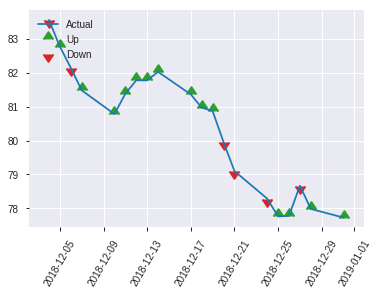


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.15095983148170217
RMSE: 0.38853549578089025
LogLoss: 0.4624652243059152
Null degrees of freedom: 255
Residual degrees of freedom: -302
Null deviance: 357.52774107262724
Residual deviance: 236.7821948446286
AIC: 1352.7821948446285
AUC: 0.8767098080107956
pr_auc: 0.853752681654877
Gini: 0.7534196160215911
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.6016667865252666: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      113  24   0.1752   (24.0/137.0)
1      22   97   0.1849   (22.0/119.0)
Total  135  121  0.1797   (46.0/256.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.601667     0.808333  120
max f2                       0.345935     0.86128   179
max f0point5                 0.647522     0.804388  106
max accuracy                 0.601667     0.820312  120
max precision                0.990983     1         0
max recall                   0.0481137    1         243
max specificity              0.990983     1         0
max absolute_mcc             0.601667     0.639316  120
max min_per_class_accuracy   0.601667     0.815126  120
max mean_per_class_accuracy  0.601667     0.819972  120

Gains/Lift Table: Avg response rate: 46.48 %, avg score: 53.89 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117188                   0.987593           2.15126    2.15126            1                0.989494   1                           0.989494            0.0252101       0.0252101                  115.126   115.126
    2        0.0234375                   0.986603           2.15126    2.15126            1                0.987073   1                           0.988284            0.0252101       0.0504202                  115.126   115.126
    3        0.03125                     0.980098           2.15126    2.15126            1                0.982203   1                           0.986763            0.0168067       0.0672269                  115.126   115.126
    4        0.0429688                   0.973197           2.15126    2.15126            1                0.975854   1                           0.983788            0.0252101       0.092437                   115.126   115.126
    5        0.0507812                   0.970461           1.07563    1.98578            0.5              0.971629   0.923077                    0.981917            0.00840336      0.10084                    7.56303   98.5779
    6        0.101562                    0.93833            2.15126    2.06852            1                0.956598   0.961538                    0.969258            0.109244        0.210084                   115.126   106.852
    7        0.152344                    0.890542           2.15126    2.0961             1                0.914231   0.974359                    0.950915            0.109244        0.319328                   115.126   109.61
    8        0.203125                    0.816158           1.65482    1.98578            0.769231         0.851306   0.923077                    0.926013            0.0840336       0.403361                   65.4816   98.5779
    9        0.300781                    0.751946           1.72101    1.89981            0.8              0.78691    0.883117                    0.88085             0.168067        0.571429                   72.1008   89.9814
    10       0.402344                    0.677409           1.32385    1.75443            0.615385         0.712824   0.815534                    0.838435            0.134454        0.705882                   32.3853   75.4426
    11       0.5                         0.575424           1.29076    1.66387            0.6              0.62117    0.773438                    0.796001            0.12605         0.831933                   29.0756   66.3866
    12       0.601562                    0.447327           0.661926   1.49471            0.307692         0.518984   0.694805                    0.749232            0.0672269       0.89916                    -33.8074  49.4707
    13       0.699219                    0.34793            0.430252   1.34604            0.2              0.398764   0.625698                    0.700284            0.0420168       0.941176                   -56.9748  34.604
    14       0.800781                    0.220444           0.248222   1.2068             0.115385         0.28456    0.560976                    0.647558            0.0252101       0.966387                   -75.1778  20.6805
    15       0.898438                    0.107541           0.258151   1.10369            0.12             0.156029   0.513043                    0.594131            0.0252101       0.991597                   -74.1849  10.369
    16       1                           0.00177242         0.0827408  1                  0.0384615        0.0499405  0.464844    

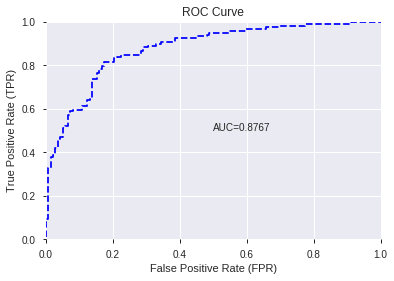

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


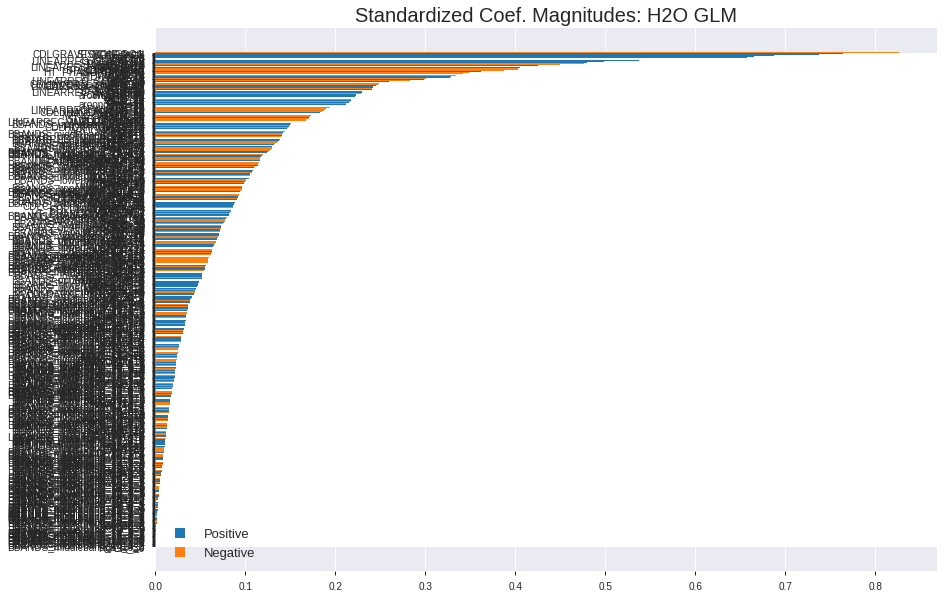

'log_likelihood'
--2019-08-22 11:38:28--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.107.204
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.107.204|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190822_113747_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190822_113747_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_106_sid_a945',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_106

['STOCHF_fastk',
 'CDLGRAVESTONEDOJI',
 'MEDPRICE',
 'CCI_8',
 'PLUS_DI_8',
 'CCI_30',
 'SAR_0.3',
 'ATAN',
 'LINEARREG_SLOPE_12',
 'CCI_12',
 'STOCH_slowd',
 'PLUS_DM_8',
 'MINUS_DI_8',
 'SAR_0.2',
 'LINEARREG_ANGLE_14',
 'SAR_0.14',
 'WILLR_8',
 'TYPPRICE',
 'STOCHRSI_fastd',
 'CDLTAKURI',
 'MIDPRICE_14',
 'HT_PHASOR_inphase',
 'ULTOSC',
 'MOM_30',
 'WILLR_12',
 'MIDPOINT_14',
 'ADX_8',
 'NATR_8',
 'DX_12',
 'DX_8',
 'LINEARREG_SLOPE_14',
 'VAR_20',
 'NATR_30',
 'ATR_20',
 'TRIX_14',
 'CDLINVERTEDHAMMER',
 'LINEARREG_ANGLE_12',
 'CDLSHOOTINGSTAR',
 'MOM_12',
 'STOCHF_fastd',
 'ATR_14',
 'STOCH_slowk',
 'VAR_12',
 'LINEARREG_SLOPE_20',
 'BOP',
 'AVGPRICE',
 'aroondown_20',
 'WCLPRICE',
 'BETA_14',
 'CMO_30',
 'ADX_12',
 'CCI_24',
 'MOM_14',
 'CMO_12',
 'ADX_14',
 'CEIL',
 'aroondown_14',
 'RSI_12',
 'RSI_30',
 'ATR_24',
 'ADXR_8',
 'ATR_12',
 'PLUS_DI_20',
 'LINEARREG_ANGLE_20',
 'TSF_12',
 'LINEARREG_12',
 'CDLDRAGONFLYDOJI',
 'MACDFIX_hist_24',
 'MOM_20',
 'WILLR_20',
 'DX_30',
 'CM

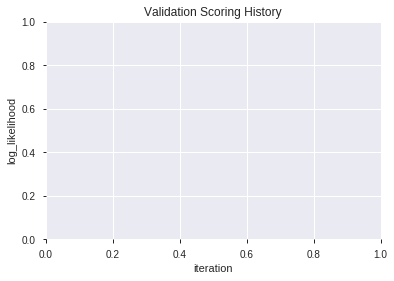

In [52]:
# GLM with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0               XGBoost_1_AutoML_20190822_113835  0.858799  0.487209              0.205576  0.398550  0.158842
1               XGBoost_3_AutoML_20190822_113835  0.858676  0.487173              0.236214  0.399767  0.159814
2  XGBoost_grid_1_AutoML_20190822_113835_model_2  0.856529  0.496920              0.241643  0.404194  0.163373
3  XGBoost_grid_1_AutoML_20190822_113835_model_6  0.855793  0.500144              0.218855  0.405490  0.164422
4  XGBoost_grid_1_AutoML_20190822_113835_model_3  0.853401  0.498221              0.213090  0.404999  0.164024
5  XGBoost_grid_1_AutoML_20190822_113835_model_1  0.853033  0.498571              0.217629  0.405623  0.164530
6  XGBoost_grid_1_AutoML_20190822_113835_model_7  0.851316  0.496775              0.239864  0.403935  0.163164
7               XGBoost_2_AutoML_20190822_113835  0.850948  0.497616              0.205238  0.403671  0.162950
8  XGBoost_grid_1_AutoML_20190822_113835_model_4  0.850212  0.504147              0.226369  0.407314  0.165905
9  XGBoost_grid_1_AutoML_20190822_113835_model_5  0.848678  0.494789              0.242747  0.405459  0.164397

variable  relative_importance  scaled_importance    percentage
0                  CDLTAKURI           861.603760           1.000000  7.105163e-02
1          CDLGRAVESTONEDOJI           765.932434           0.888961  6.316215e-02
2           CDLDRAGONFLYDOJI           569.598755           0.661091  4.697161e-02
3               STOCHF_fastk           488.087616           0.566487  4.024985e-02
4                      CCI_8           339.684753           0.394247  2.801190e-02
..                       ...                  ...                ...           ...
321  BBANDS_lowerband_20_6_4             0.575758           0.000668  4.747953e-05
322                MAVP_12_6             0.571716           0.000664  4.714624e-05
323  BBANDS_upperband_20_1_4             0.227140           0.000264  1.873100e-05
324                   SMA_20             0.139256           0.000162  1.148362e-05
325  BBANDS_lowerband_30_6_2             0.001156           0.000001  9.531673e-08

[326 rows x 4 columns]

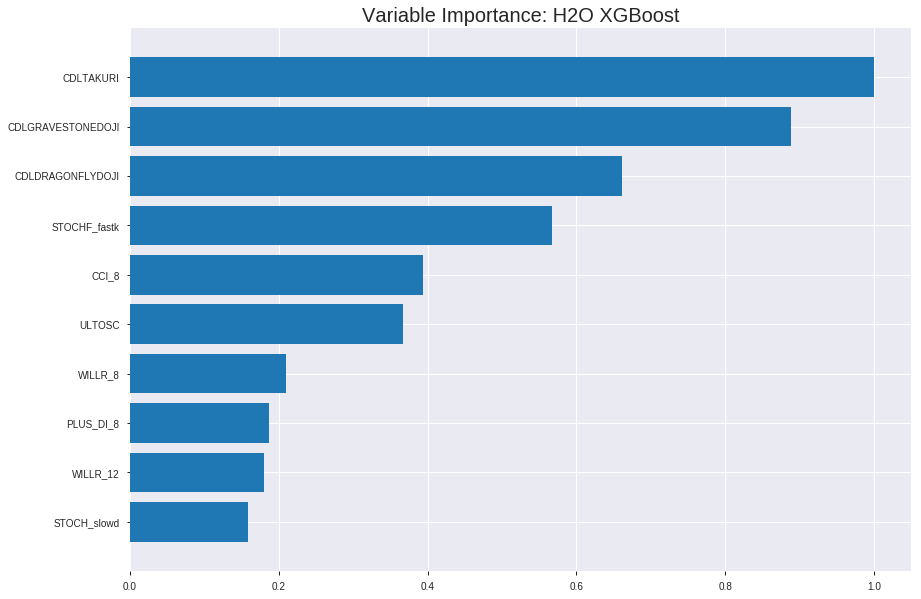

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_1_AutoML_20190822_113835


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.08606401454541618
RMSE: 0.2933666895634475
LogLoss: 0.31780188255071334
Mean Per-Class Error: 0.05717130775034651
AUC: 0.980542667137919
pr_auc: 0.9829750723459908
Gini: 0.9610853342758381
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5502959787845612: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      805  42   0.0496   (42.0/847.0)
1      61   881  0.0648   (61.0/942.0)
Total  866  923  0.0576   (103.0/1789.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.550296     0.944772  192
max f2                       0.482212     0.952281  214
max f0point5                 0.609177     0.958084  169
max accuracy                 0.550296     0.942426  192
max precision                0.961041     1         0
max recall                   0.204606     1         327
max specificity              0.961041     1         0
max absolute_mcc             0.550296     0.884857  192
max min_per_class_accuracy   0.535231     0.941614  197
max mean_per_class_accuracy  0.550296     0.942829  192

Gains/Lift Table: Avg response rate: 52.66 %, avg score: 52.65 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100615                   0.942849           1.89915    1.89915            1                0.950175   1                           0.950175            0.0191083       0.0191083                  89.9151   89.9151
    2        0.020123                    0.934981           1.89915    1.89915            1                0.939555   1                           0.944865            0.0191083       0.0382166                  89.9151   89.9151
    3        0.0301845                   0.928728           1.89915    1.89915            1                0.931798   1                           0.94051             0.0191083       0.0573248                  89.9151   89.9151
    4        0.0402459                   0.920662           1.89915    1.89915            1                0.9252     1                           0.936682            0.0191083       0.0764331                  89.9151   89.9151
    5        0.0503074                   0.914139           1.89915    1.89915            1                0.917464   1                           0.932839            0.0191083       0.0955414                  89.9151   89.9151
    6        0.100056                    0.883974           1.89915    1.89915            1                0.899391   1                           0.916208            0.0944798       0.190021                   89.9151   89.9151
    7        0.150363                    0.847692           1.89915    1.89915            1                0.864476   1                           0.8989              0.0955414       0.285563                   89.9151   89.9151
    8        0.200112                    0.816364           1.89915    1.89915            1                0.83079    1                           0.881968            0.0944798       0.380042                   89.9151   89.9151
    9        0.300168                    0.753921           1.87793    1.89208            0.988827         0.78626    0.996276                    0.850065            0.187898        0.567941                   87.7931   89.2078
    10       0.400224                    0.690503           1.81427    1.87263            0.955307         0.720726   0.986034                    0.81773             0.181529        0.749469                   81.4272   87.2626
    11       0.500279                    0.575416           1.66574    1.83125            0.877095         0.636287   0.964246                    0.781442            0.166667        0.916136                   66.5736   83.1248
    12       0.599776                    0.413537           0.586816   1.62481            0.308989         0.488395   0.855545                    0.732828            0.0583864       0.974522                   -41.3184  62.4809
    13       0.699832                    0.304271           0.106098   1.40768            0.0558659        0.355886   0.741214                    0.678936            0.0106157       0.985138                   -89.3902  40.7677
    14       0.799888                    0.218706           0.116708   1.24619            0.0614525        0.260015   0.656184                    0.626535            0.0116773       0.996815                   -88.3292  24.6193
    15       0.899944                    0.115037           0.0318293  1.11118            0.0167598        0.165742   0.585093                    0.575304            0.00318471      1                          -96.8171  11.118
    16       1                           0.0480942          0          1                  0                0.0872429  0.526551  



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.17502072483303507
RMSE: 0.41835478344705834
LogLoss: 0.5212129283370904
Mean Per-Class Error: 0.2607218945873344
AUC: 0.81141353012011
pr_auc: 0.8252717569239669
Gini: 0.6228270602402199
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5054138898849487: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      140  93   0.3991   (93.0/233.0)
1      34   244  0.1223   (34.0/278.0)
Total  174  337  0.2485   (127.0/511.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.505414     0.793496  249
max f2                       0.221831     0.883691  332
max f0point5                 0.616428     0.754086  194
max accuracy                 0.505414     0.751468  249
max precision                0.957005     1         0
max recall                   0.1096       1         373
max specificity              0.957005     1         0
max absolute_mcc             0.505414     0.502972  249
max min_per_class_accuracy   0.617454     0.725322  193
max mean_per_class_accuracy  0.505414     0.739278  249

Gains/Lift Table: Avg response rate: 54.40 %, avg score: 57.83 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117417                   0.939584           1.83813   1.83813            1                0.946823   1                           0.946823            0.0215827       0.0215827                  83.8129   83.8129
    2        0.0215264                   0.935458           1.4705    1.67103            0.8              0.937534   0.909091                    0.942601            0.0143885       0.0359712                  47.0504   67.1027
    3        0.0313112                   0.93179            1.83813   1.72325            1                0.93329    0.9375                      0.939691            0.0179856       0.0539568                  83.8129   72.3246
    4        0.0410959                   0.925388           1.83813   1.7506             1                0.928045   0.952381                    0.936918            0.0179856       0.0719424                  83.8129   75.06
    5        0.0508806                   0.922308           1.83813   1.76743            1                0.923934   0.961538                    0.934421            0.0179856       0.0899281                  83.8129   76.7432
    6        0.101761                    0.902639           1.69673   1.73208            0.923077         0.9123     0.942308                    0.923361            0.0863309       0.176259                   69.6735   73.2084
    7        0.150685                    0.876702           1.7646    1.74264            0.96             0.885948   0.948052                    0.911214            0.0863309       0.26259                    76.4604   74.2642
    8        0.201566                    0.840233           1.62604   1.71321            0.884615         0.859267   0.932039                    0.898101            0.0827338       0.345324                   62.6038   71.3208
    9        0.30137                     0.763049           1.08125   1.50392            0.588235         0.79939    0.818182                    0.865411            0.107914        0.453237                   8.12526   50.3924
    10       0.401174                    0.690002           1.33354   1.46154            0.72549          0.726006   0.795122                    0.83073             0.133094        0.586331                   33.3545   46.1537
    11       0.500978                    0.631766           1.15334   1.40014            0.627451         0.660512   0.761719                    0.796819            0.115108        0.701439                   15.3336   40.0138
    12       0.600783                    0.566729           1.00917   1.33519            0.54902          0.596385   0.726384                    0.763522            0.100719        0.802158                   0.916914  33.5189
    13       0.700587                    0.450776           0.973127  1.28361            0.529412         0.512202   0.698324                    0.72772             0.0971223       0.899281                   -2.68726  28.361
    14       0.800391                    0.291624           0.576668  1.19546            0.313725         0.386081   0.650367                    0.685119            0.057554        0.956835                   -42.3332  19.5458
    15       0.900196                    0.134453           0.288334  1.09489            0.156863         0.201713   0.595652                    0.631524            0.028777        0.985612                   -71.1666  9.48858
    16       1                           0.0503013          0.144167  1                  0.0784314        0.0980213  0.544031                    0.


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-22 11:38:36  0.009 sec   0                  0.5              0.693147            0.5             0                  1                0.473449                         0.5                0.693147              0.5               0                    1                  0.455969
    2019-08-22 11:38:36  0.761 sec   5                  0.46592          0.626811            0.882636        0.802943           1.89915          0.201789                         0.472139           0.638486              0.79183           0.683619             1.6588             0.293542
    2019-08-22 11:38:37  0.960 sec   10                 0.439248         0.576633            0.91481         0.910548           1.89915          0.155394                         0.456159           0.607188              0.792185          0.804328             1.83813            0.279843
    2019-08-22 11:38:37  1.161 sec   15                 0.418321         0.537664            0.928044        0.935544           1.89915          0.138625                         0.442602           0.580286              0.80205           0.812611             1.83813            0.266145
    2019-08-22 11:38:37  1.349 sec   20                 0.401342         0.505886            0.93282         0.940745           1.89915          0.127446                         0.435033           0.564234              0.801602          0.813566             1.83813            0.260274
    2019-08-22 11:38:37  1.536 sec   25                 0.386904         0.478759            0.937686        0.94363            1.89915          0.117384                         0.429761           0.551897              0.800869          0.81537              1.83813            0.25636
    2019-08-22 11:38:37  1.729 sec   30                 0.373972         0.454821            0.943706        0.94781            1.89915          0.109558                         0.42484            0.540766              0.806466          0.820804             1.83813            0.254403
    2019-08-22 11:38:38  1.931 sec   35                 0.361941         0.433022            0.949251        0.952665           1.89915          0.102292                         0.423892           0.537616              0.803517          0.819357             1.83813            0.260274
    2019-08-22 11:38:38  2.132 sec   40                 0.351541         0.414661            0.954262        0.959546           1.89915          0.0911124                        0.422043           0.532927              0.805763          0.820523             1.83813            0.268102
    2019-08-22 11:38:38  2.342 sec   45                 0.342856         0.399296            0.958272        0.963302           1.89915          0.0860816                        0.421598           0.531211              0.805207          0.820084             1.83813            0.270059
    2019-08-22 11:38:38  2.552 sec   50                 0.333338         0.382976            0.962326        0.965835           1.89915          0.0855226                        0.420093           0.52734               0.807786          0.821796             1.83813            0.266145
    2019-08-22 11:38:38  2.763 sec   55                 0.324757         0.368591            0.967434        0.970671           1.89915          0.0743432                        0.41862            0.523892              0.810788          0.

Variable Importances: 


variable                 relative_importance    scaled_importance       percentage
-----------------------  ---------------------  ----------------------  ----------------------
CDLTAKURI                861.603759765625       1.0                     0.07105162775638005
CDLGRAVESTONEDOJI        765.9324340820312      0.888961341452806       0.06316215032271705
CDLDRAGONFLYDOJI         569.5987548828125      0.6610913060984736      0.04697161339388785
STOCHF_fastk             488.0876159667969      0.566487332993495       0.04024984711255832
CCI_8                    339.68475341796875     0.3942470649273518      0.028011895701263594
---                      ---                    ---                     ---
BBANDS_lowerband_20_6_4  0.5757579803466797     0.0006682398652755396   4.74795301595312e-05
MAVP_12_6                0.57171630859375       0.000663548994666956    4.714623616719677e-05
BBANDS_upperband_20_1_4  0.2271404266357422     0.00026362515722717987  1.8730996538522748e-05
SMA_20                   0.13925552368164062    0.00016162362582948937  1.148362169907333e-05
BBANDS_lowerband_30_6_2  0.001155853271484375   1.3415137276081435e-06  9.531673400408764e-08


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.79296875)

('F1', 0.7854251012145749)

('auc', 0.8587989940501749)

('logloss', 0.48720896064847996)

('mean_per_class_error', 0.20557566092130286)

('rmse', 0.39854986871560505)

('mse', 0.15884199785322603)

xgboost prediction progress: |████████████████████████████████████████████| 100%


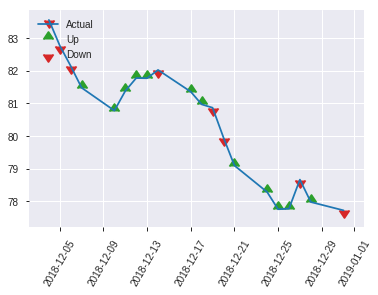


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.15884199785322603
RMSE: 0.39854986871560505
LogLoss: 0.48720896064847996
Mean Per-Class Error: 0.20557566092130286
AUC: 0.8587989940501749
pr_auc: 0.8217801738551224
Gini: 0.7175979881003498
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5364525318145752: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      106  31   0.2263   (31.0/137.0)
1      22   97   0.1849   (22.0/119.0)
Total  128  128  0.207    (53.0/256.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.536453     0.785425  127
max f2                       0.301518     0.856721  200
max f0point5                 0.693837     0.810811  71
max accuracy                 0.540752     0.792969  125
max precision                0.947751     1         0
max recall                   0.0823586    1         243
max specificity              0.947751     1         0
max absolute_mcc             0.536453     0.587391  127
max min_per_class_accuracy   0.555258     0.781022  122
max mean_per_class_accuracy  0.536453     0.794424  127

Gains/Lift Table: Avg response rate: 46.48 %, avg score: 52.10 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117188                   0.94302            2.15126    2.15126            1                0.946098   1                           0.946098            0.0252101       0.0252101                  115.126   115.126
    2        0.0234375                   0.937513           1.43417    1.79272            0.666667         0.939193   0.833333                    0.942646            0.0168067       0.0420168                  43.4174   79.2717
    3        0.03125                     0.931578           2.15126    1.88235            1                0.932702   0.875                       0.94016             0.0168067       0.0588235                  115.126   88.2353
    4        0.0429688                   0.924039           1.43417    1.76012            0.666667         0.928456   0.818182                    0.936968            0.0168067       0.0756303                  43.4174   76.0122
    5        0.0507812                   0.917088           2.15126    1.8203             1                0.91944    0.846154                    0.934271            0.0168067       0.092437                   115.126   82.0297
    6        0.101562                    0.891679           2.15126    1.98578            1                0.904701   0.923077                    0.919486            0.109244        0.201681                   115.126   98.5779
    7        0.152344                    0.845209           1.98578    1.98578            0.923077         0.863495   0.923077                    0.900823            0.10084         0.302521                   98.5779   98.5779
    8        0.203125                    0.805455           2.15126    2.02715            1                0.824683   0.942308                    0.881788            0.109244        0.411765                   115.126   102.715
    9        0.300781                    0.685784           1.54891    1.87188            0.72             0.743199   0.87013                     0.836791            0.151261        0.563025                   54.8908   87.1876
    10       0.402344                    0.602223           1.24111    1.71265            0.576923         0.646244   0.796117                    0.788692            0.12605         0.689076                   24.1112   71.2654
    11       0.5                         0.533625           1.29076    1.63025            0.6              0.567689   0.757812                    0.745527            0.12605         0.815126                   29.0756   63.0252
    12       0.601562                    0.435257           0.496445   1.43883            0.230769         0.485187   0.668831                    0.701574            0.0504202       0.865546                   -50.3555  43.883
    13       0.699219                    0.36267            0.602353   1.322              0.28             0.397391   0.614525                    0.65909             0.0588235       0.92437                    -39.7647  32.2004
    14       0.800781                    0.27593            0.496445   1.2173             0.230769         0.331185   0.565854                    0.617502            0.0504202       0.97479                    -50.3555  21.7299
    15       0.898438                    0.113287           0.0860504  1.09434            0.04             0.186296   0.508696                    0.570632            0.00840336      0.983193                   -91.395   9.43369
    16       1                           0.0462157          0.165482   1                  0.0769231        0.0819126  0.464844  

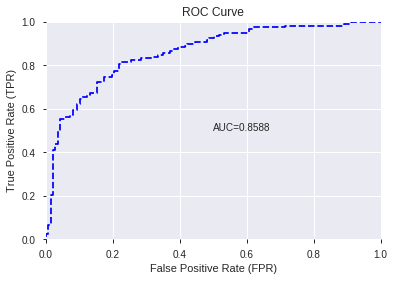

This function is available for GLM models only


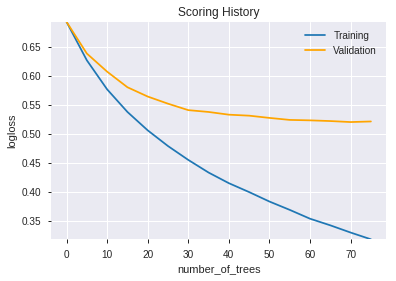

--2019-08-22 11:39:26--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.81.48
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.81.48|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.algos.tree.SharedTreeNode.calculateChildInclusiveNa(SharedT

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_1_AutoML_20190822_113835',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_1_AutoML_20190822_113835',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_114_sid_a945',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_114_sid_a945',
   'ty

['CDLTAKURI',
 'CDLGRAVESTONEDOJI',
 'CDLDRAGONFLYDOJI',
 'STOCHF_fastk',
 'CCI_8',
 'ULTOSC',
 'WILLR_8',
 'PLUS_DI_8',
 'WILLR_12',
 'STOCH_slowd',
 'TRANGE',
 'DX_8',
 'WILLR_30',
 'HT_PHASOR_quadrature',
 'STDDEV_8',
 'BOP',
 'WILLR_20',
 'CORREL_12',
 'aroonup_8',
 'WILLR_14',
 'MINUS_DI_8',
 'aroondown_8',
 'ADX_12',
 'BETA_12',
 'HT_PHASOR_inphase',
 'BETA_30',
 'PLUS_DM_8',
 'LINEARREG_ANGLE_8',
 'CORREL_30',
 'WILLR_24',
 'CCI_24',
 'MACDEXT_hist',
 'STOCHRSI_fastk',
 'CCI_30',
 'CORREL_8',
 'CORREL_20',
 'ADX_14',
 'MACDFIX_hist_8',
 'STOCHRSI_fastd',
 'BETA_24',
 'BETA_14',
 'STDDEV_12',
 'PLUS_DI_12',
 'AROONOSC_20',
 'CMO_8',
 'CCI_12',
 'STOCH_slowk',
 'PLUS_DM_12',
 'CCI_20',
 'MOM_12',
 'BETA_8',
 'ADX_24',
 'ADXR_8',
 'CORREL_14',
 'BETA_20',
 'aroondown_12',
 'aroondown_30',
 'NATR_24',
 'CCI_14',
 'PLUS_DI_20',
 'LINEARREG_ANGLE_20',
 'CMO_14',
 'MOM_30',
 'MINUS_DM_30',
 'DX_12',
 'CORREL_24',
 'MOM_8',
 'MOM_24',
 'DX_24',
 'MINUS_DI_12',
 'AROONOSC_14',
 'MINUS_DI

In [53]:
# XGBoost with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="XGBoost",features_list=features_list)

In [54]:
# Experiment Summary
pd.set_option('precision', 3) 

for k in models_summary:
  print(k)
  display(models_summary[k].max())
  print('\n'*3)
  display(models_summary[k].groupby(models_summary[k].index).max())
  print('\n'*3)
  
display(models_summary)

pd.set_option('precision', 6) 

accuracy


DeepLearning    0.797
GLM             0.820
XGBoost         0.805
dtype: float64

DeepLearning    GLM  XGBoost
All          0.781  0.812    0.805
DLF          0.797  0.793    0.801
Fwe          0.793  0.820    0.805
RFE          0.773  0.820    0.793
XGBF         0.777  0.793    0.801





F1


DeepLearning    0.780
GLM             0.810
XGBoost         0.797
dtype: float64

DeepLearning    GLM  XGBoost
All          0.770  0.810    0.797
DLF          0.772  0.777    0.782
Fwe          0.780  0.793    0.783
RFE          0.773  0.808    0.785
XGBF         0.768  0.777    0.782





auc


DeepLearning    0.861
GLM             0.878
XGBoost         0.874
dtype: float64

DeepLearning    GLM  XGBoost
All          0.844  0.878    0.874
DLF          0.851  0.861    0.862
Fwe          0.861  0.871    0.856
RFE          0.841  0.877    0.859
XGBF         0.842  0.861    0.862





logloss


DeepLearning    0.544
GLM             0.489
XGBoost         0.503
dtype: float64

DeepLearning    GLM  XGBoost
All          0.504  0.458    0.487
DLF          0.542  0.489    0.503
Fwe          0.541  0.486    0.490
RFE          0.518  0.462    0.487
XGBF         0.544  0.489    0.503





mean_per_class_error


DeepLearning    0.231
GLM             0.211
XGBoost         0.206
dtype: float64

DeepLearning    GLM  XGBoost
All          0.219  0.185    0.194
DLF          0.207  0.211    0.202
Fwe          0.214  0.185    0.200
RFE          0.231  0.180    0.206
XGBF         0.224  0.211    0.202





rmse


DeepLearning    0.428
GLM             0.403
XGBoost         0.407
dtype: float64

DeepLearning    GLM  XGBoost
All          0.408  0.387    0.399
DLF          0.425  0.403    0.407
Fwe          0.427  0.400    0.399
RFE          0.413  0.389    0.399
XGBF         0.428  0.403    0.407





mse


DeepLearning    0.183
GLM             0.162
XGBoost         0.166
dtype: float64

DeepLearning    GLM  XGBoost
All          0.166  0.149    0.159
DLF          0.181  0.162    0.166
Fwe          0.182  0.160    0.159
RFE          0.170  0.151    0.159
XGBF         0.183  0.162    0.166

{'F1':       DeepLearning    GLM  XGBoost
 All          0.770    NaN      NaN
 DLF          0.772    NaN      NaN
 DLF            NaN  0.777      NaN
 DLF            NaN    NaN    0.782
 All            NaN  0.810      NaN
 All            NaN    NaN    0.797
 XGBF         0.768    NaN      NaN
 XGBF           NaN  0.777      NaN
 XGBF           NaN    NaN    0.782
 Fwe          0.780    NaN      NaN
 Fwe            NaN  0.793      NaN
 Fwe            NaN    NaN    0.783
 RFE          0.773    NaN      NaN
 RFE            NaN  0.808      NaN
 RFE            NaN    NaN    0.785,
 'accuracy':       DeepLearning    GLM  XGBoost
 All          0.781    NaN      NaN
 DLF          0.797    NaN      NaN
 DLF            NaN  0.793      NaN
 DLF            NaN    NaN    0.801
 All            NaN  0.812      NaN
 All            NaN    NaN    0.805
 XGBF         0.777    NaN      NaN
 XGBF           NaN  0.793      NaN
 XGBF           NaN    NaN    0.801
 Fwe          0.793    NaN      NaN
 Fwe     